In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, 2, 2) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price #買入成本 = 今天收盤
                    Sold = last_trade_price #賣出成本 = 明天開盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本




                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price #買入成本 = 明天開盤
                    Sold = current_price #賣出成本 = 今天收盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price
                    Sold = last_trade_price

                    price_diff = Sold - Buy#最後賺到的錢
                    long_profit_percentage = (Sold - Buy)/Buy
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price
                    Sold = current_price

                    price_diff = Sold - Buy#最後賺到的錢
                    short_profit_percentage = (Sold - Buy)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('TSLA', str):
    # load it from yahoo_fin library
    df = si.get_data('TSLA')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2010-07-27,1.394,1.412,1.351,1.370,1.370,9295500,TSLA,1.267,1.483,...,68.083,65.280,69.781,-0.027,-0.049,1.623,1.325,1.026,0,1
1,2010-07-28,1.370,1.393,1.367,1.381,1.381,7008000,TSLA,1.300,1.483,...,71.512,58.308,65.957,-0.023,-0.044,1.588,1.314,1.041,0,1
2,2010-07-29,1.385,1.392,1.333,1.357,1.357,9240000,TSLA,1.300,1.483,...,64.149,49.175,60.363,-0.023,-0.040,1.547,1.303,1.058,0,1
3,2010-07-30,1.347,1.363,1.303,1.329,1.329,6403500,TSLA,1.300,1.457,...,50.767,39.025,53.250,-0.024,-0.036,1.529,1.296,1.063,0,1
4,2010-08-02,1.367,1.398,1.355,1.395,1.395,10771500,TSLA,1.300,1.437,...,56.913,48.994,51.831,-0.019,-0.033,1.539,1.302,1.065,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3167,2023-02-24,196.330,197.670,192.800,196.880,196.880,142228100,TSLA,187.610,217.650,...,50.043,44.797,55.241,12.738,14.454,219.162,195.008,170.855,0,1
3168,2023-02-27,202.030,209.420,201.260,207.630,207.630,161028300,TSLA,189.440,217.650,...,53.588,51.358,53.947,12.556,14.074,219.902,196.495,173.088,0,1
3169,2023-02-28,210.590,211.230,203.750,205.710,205.710,153144900,TSLA,191.780,217.650,...,49.045,52.188,53.361,12.116,13.683,217.724,198.448,179.171,0,1
3170,2023-03-01,206.210,207.200,198.520,202.770,202.770,156852800,TSLA,191.780,217.650,...,53.830,48.952,51.891,11.399,13.226,215.394,199.925,184.456,0,1


# 查找DF的標籤

In [7]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

2375

In [8]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

3130

In [9]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
2375,2020-01-02,28.300,28.713,28.114,28.684,28.684,142981500,TSLA,26.433,29.021,...,82.856,82.094,85.263,1.671,1.507,30.421,25.636,20.850,0,1
2376,2020-01-03,29.367,30.267,29.128,29.534,29.534,266677500,TSLA,26.679,30.267,...,81.063,81.255,83.927,1.731,1.552,30.803,26.003,21.202,1,0
2377,2020-01-06,29.365,30.104,29.333,30.103,30.103,151995000,TSLA,26.805,30.267,...,84.538,85.924,84.593,1.804,1.602,31.159,26.406,21.654,0,1
2378,2020-01-07,30.760,31.442,30.224,31.271,31.271,268231500,TSLA,26.805,31.442,...,85.017,89.384,86.190,1.933,1.668,31.679,26.850,22.022,1,0
2379,2020-01-08,31.580,33.233,31.215,32.809,32.809,467164500,TSLA,26.805,33.233,...,86.532,90.727,87.702,2.135,1.762,32.441,27.359,22.277,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,2022-12-23,126.370,128.620,121.020,123.150,123.150,166989700,TSLA,121.020,175.050,...,10.149,4.965,7.012,-17.245,-13.665,208.812,165.201,121.590,1,0
3127,2022-12-27,117.500,119.670,108.760,109.100,109.100,208643400,TSLA,108.760,161.620,...,8.383,3.524,5.849,-19.073,-14.747,210.643,161.510,112.377,1,0
3128,2022-12-28,110.350,116.270,108.240,112.710,112.710,221070500,TSLA,108.240,160.990,...,5.950,5.174,5.624,-20.000,-15.797,210.728,158.104,105.480,1,0
3129,2022-12-29,120.390,123.570,117.500,121.820,121.820,221923300,TSLA,108.240,160.990,...,18.571,12.031,7.760,-19.772,-16.592,206.533,154.460,102.387,1,0


In [10]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['UpLine', 'DownLine', 'Volume_lower', 'Volume_greater']].to_numpy()[start:end]#抓取特徵資料
    signal_features = signal_features.reshape(len(signal_features), 2, 2)#變成[['FL','FH'],['UpLine', 'DownLine']]
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | -0.194   |
| fps                | 1        |
| nupdates           | 1        |
| policy_entropy     | 0.69     |
| total_timesteps    | 5        |
| value_loss         | 0.0637   |
---------------------------------
---------------------------------
| explained_variance | 0.766    |
| fps                | 91       |
| nupdates           | 100      |
| policy_entropy     | 0.686    |
| total_timesteps    | 500      |
| value_loss         | 0.00747  |
---------------------------------
---------------------------------
| explained_variance | -0.101 

---------------------------------
| explained_variance | 0.0535   |
| fps                | 137      |
| nupdates           | 1500     |
| policy_entropy     | 0.0515   |
| total_timesteps    | 7500     |
| value_loss         | 2.36     |
---------------------------------
---------------------------------
| explained_variance | 0.00983  |
| fps                | 137      |
| nupdates           | 1600     |
| policy_entropy     | 0.041    |
| total_timesteps    | 8000     |
| value_loss         | 26.1     |
---------------------------------
---------------------------------
| explained_variance | -0.141   |
| fps                | 138      |
| nupdates           | 1700     |
| policy_entropy     | 0.587    |
| total_timesteps    | 8500     |
| value_loss         | 0.373    |
---------------------------------
---------------------------------
| explained_variance | -0.00668 |
| fps                | 138      |
| nupdates           | 1800     |
| policy_entropy     | 0.481    |
| total_timest

---------------------------------
| explained_variance | -0.0706  |
| fps                | 140      |
| nupdates           | 4600     |
| policy_entropy     | 0.195    |
| total_timesteps    | 23000    |
| value_loss         | 0.0811   |
---------------------------------
---------------------------------
| explained_variance | 0.053    |
| fps                | 140      |
| nupdates           | 4700     |
| policy_entropy     | 0.113    |
| total_timesteps    | 23500    |
| value_loss         | 2.22     |
---------------------------------
---------------------------------
| explained_variance | 0.000782 |
| fps                | 140      |
| nupdates           | 4800     |
| policy_entropy     | 0.0492   |
| total_timesteps    | 24000    |
| value_loss         | 91.1     |
---------------------------------
---------------------------------
| explained_variance | -1.38    |
| fps                | 141      |
| nupdates           | 4900     |
| policy_entropy     | 0.145    |
| total_timest

---------------------------------
| explained_variance | 0.0806   |
| fps                | 142      |
| nupdates           | 7700     |
| policy_entropy     | 0.117    |
| total_timesteps    | 38500    |
| value_loss         | 0.018    |
---------------------------------
---------------------------------
| explained_variance | -0.444   |
| fps                | 142      |
| nupdates           | 7800     |
| policy_entropy     | 0.127    |
| total_timesteps    | 39000    |
| value_loss         | 0.0152   |
---------------------------------
---------------------------------
| explained_variance | 0.0122   |
| fps                | 142      |
| nupdates           | 7900     |
| policy_entropy     | 0.06     |
| total_timesteps    | 39500    |
| value_loss         | 0.121    |
---------------------------------
---------------------------------
| explained_variance | 0.0247   |
| fps                | 142      |
| nupdates           | 8000     |
| policy_entropy     | 0.0155   |
| total_timest

---------------------------------
| explained_variance | 0.0152   |
| fps                | 143      |
| nupdates           | 10800    |
| policy_entropy     | 0.115    |
| total_timesteps    | 54000    |
| value_loss         | 0.882    |
---------------------------------
---------------------------------
| explained_variance | 0.0439   |
| fps                | 143      |
| nupdates           | 10900    |
| policy_entropy     | 0.165    |
| total_timesteps    | 54500    |
| value_loss         | 0.0899   |
---------------------------------
---------------------------------
| explained_variance | 0.262    |
| fps                | 144      |
| nupdates           | 11000    |
| policy_entropy     | 0.413    |
| total_timesteps    | 55000    |
| value_loss         | 0.434    |
---------------------------------
---------------------------------
| explained_variance | -0.357   |
| fps                | 144      |
| nupdates           | 11100    |
| policy_entropy     | 0.623    |
| total_timest

---------------------------------
| explained_variance | -0.0588  |
| fps                | 145      |
| nupdates           | 13900    |
| policy_entropy     | 0.013    |
| total_timesteps    | 69500    |
| value_loss         | 0.255    |
---------------------------------
---------------------------------
| explained_variance | 0.000377 |
| fps                | 145      |
| nupdates           | 14000    |
| policy_entropy     | 0.0928   |
| total_timesteps    | 70000    |
| value_loss         | 22.1     |
---------------------------------
---------------------------------
| explained_variance | 0.019    |
| fps                | 145      |
| nupdates           | 14100    |
| policy_entropy     | 0.0224   |
| total_timesteps    | 70500    |
| value_loss         | 0.93     |
---------------------------------
---------------------------------
| explained_variance | -0.0645  |
| fps                | 145      |
| nupdates           | 14200    |
| policy_entropy     | 0.0221   |
| total_timest

----------------------------------
| explained_variance | -8.49e-05 |
| fps                | 145       |
| nupdates           | 16900     |
| policy_entropy     | 0.0899    |
| total_timesteps    | 84500     |
| value_loss         | 26.7      |
----------------------------------
---------------------------------
| explained_variance | -0.211   |
| fps                | 145      |
| nupdates           | 17000    |
| policy_entropy     | 0.314    |
| total_timesteps    | 85000    |
| value_loss         | 0.0214   |
---------------------------------
---------------------------------
| explained_variance | -0.00871 |
| fps                | 145      |
| nupdates           | 17100    |
| policy_entropy     | 0.077    |
| total_timesteps    | 85500    |
| value_loss         | 0.0653   |
---------------------------------
---------------------------------
| explained_variance | 0.000633 |
| fps                | 145      |
| nupdates           | 17200    |
| policy_entropy     | 0.271    |
| tota

---------------------------------
| explained_variance | 0.00205  |
| fps                | 146      |
| nupdates           | 20000    |
| policy_entropy     | 0.0152   |
| total_timesteps    | 100000   |
| value_loss         | 3.77     |
---------------------------------
----------------------------------
| explained_variance | -2.73e-05 |
| fps                | 146       |
| nupdates           | 20100     |
| policy_entropy     | 0.00487   |
| total_timesteps    | 100500    |
| value_loss         | 4.32      |
----------------------------------
---------------------------------
| explained_variance | -0.0865  |
| fps                | 146      |
| nupdates           | 20200    |
| policy_entropy     | 0.0797   |
| total_timesteps    | 101000   |
| value_loss         | 0.329    |
---------------------------------
---------------------------------
| explained_variance | -0.0423  |
| fps                | 146      |
| nupdates           | 20300    |
| policy_entropy     | 0.102    |
| tota

---------------------------------
| explained_variance | -0.197   |
| fps                | 146      |
| nupdates           | 23000    |
| policy_entropy     | 0.181    |
| total_timesteps    | 115000   |
| value_loss         | 0.0128   |
---------------------------------
---------------------------------
| explained_variance | 0.271    |
| fps                | 146      |
| nupdates           | 23100    |
| policy_entropy     | 0.336    |
| total_timesteps    | 115500   |
| value_loss         | 0.0138   |
---------------------------------
---------------------------------
| explained_variance | 0.316    |
| fps                | 146      |
| nupdates           | 23200    |
| policy_entropy     | 0.184    |
| total_timesteps    | 116000   |
| value_loss         | 0.0167   |
---------------------------------
---------------------------------
| explained_variance | 0.00176  |
| fps                | 146      |
| nupdates           | 23300    |
| policy_entropy     | 0.0891   |
| total_timest

---------------------------------
| explained_variance | -0.00712 |
| fps                | 146      |
| nupdates           | 26100    |
| policy_entropy     | 0.00637  |
| total_timesteps    | 130500   |
| value_loss         | 38.6     |
---------------------------------
---------------------------------
| explained_variance | -0.149   |
| fps                | 146      |
| nupdates           | 26200    |
| policy_entropy     | 0.189    |
| total_timesteps    | 131000   |
| value_loss         | 0.233    |
---------------------------------
---------------------------------
| explained_variance | 0.0376   |
| fps                | 146      |
| nupdates           | 26300    |
| policy_entropy     | 0.126    |
| total_timesteps    | 131500   |
| value_loss         | 0.0364   |
---------------------------------
---------------------------------
| explained_variance | 0.0524   |
| fps                | 146      |
| nupdates           | 26400    |
| policy_entropy     | 0.3      |
| total_timest

---------------------------------
| explained_variance | -0.179   |
| fps                | 146      |
| nupdates           | 29200    |
| policy_entropy     | 0.0711   |
| total_timesteps    | 146000   |
| value_loss         | 0.0786   |
---------------------------------
---------------------------------
| explained_variance | -0.0271  |
| fps                | 146      |
| nupdates           | 29300    |
| policy_entropy     | 0.159    |
| total_timesteps    | 146500   |
| value_loss         | 343      |
---------------------------------
---------------------------------
| explained_variance | 0.00458  |
| fps                | 146      |
| nupdates           | 29400    |
| policy_entropy     | 0.0149   |
| total_timesteps    | 147000   |
| value_loss         | 8.95     |
---------------------------------
---------------------------------
| explained_variance | 0.104    |
| fps                | 146      |
| nupdates           | 29500    |
| policy_entropy     | 0.00593  |
| total_timest

---------------------------------
| explained_variance | -0.096   |
| fps                | 147      |
| nupdates           | 32300    |
| policy_entropy     | 0.27     |
| total_timesteps    | 161500   |
| value_loss         | 0.321    |
---------------------------------
---------------------------------
| explained_variance | 0.243    |
| fps                | 147      |
| nupdates           | 32400    |
| policy_entropy     | 0.405    |
| total_timesteps    | 162000   |
| value_loss         | 0.995    |
---------------------------------
---------------------------------
| explained_variance | -3.59    |
| fps                | 147      |
| nupdates           | 32500    |
| policy_entropy     | 0.233    |
| total_timesteps    | 162500   |
| value_loss         | 26.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0017   |
| fps                | 147      |
| nupdates           | 32600    |
| policy_entropy     | 0.0907   |
| total_timest

---------------------------------
| explained_variance | -0.16    |
| fps                | 147      |
| nupdates           | 35400    |
| policy_entropy     | 0.0497   |
| total_timesteps    | 177000   |
| value_loss         | 112      |
---------------------------------
---------------------------------
| explained_variance | -0.0318  |
| fps                | 147      |
| nupdates           | 35500    |
| policy_entropy     | 0.34     |
| total_timesteps    | 177500   |
| value_loss         | 0.161    |
---------------------------------
---------------------------------
| explained_variance | 0.099    |
| fps                | 147      |
| nupdates           | 35600    |
| policy_entropy     | 0.212    |
| total_timesteps    | 178000   |
| value_loss         | 0.00429  |
---------------------------------
---------------------------------
| explained_variance | -0.0136  |
| fps                | 147      |
| nupdates           | 35700    |
| policy_entropy     | 0.314    |
| total_timest

---------------------------------
| explained_variance | 0.178    |
| fps                | 147      |
| nupdates           | 38500    |
| policy_entropy     | 0.145    |
| total_timesteps    | 192500   |
| value_loss         | 0.0358   |
---------------------------------
---------------------------------
| explained_variance | -0.00223 |
| fps                | 147      |
| nupdates           | 38600    |
| policy_entropy     | 0.0407   |
| total_timesteps    | 193000   |
| value_loss         | 52.3     |
---------------------------------
---------------------------------
| explained_variance | 0.194    |
| fps                | 147      |
| nupdates           | 38700    |
| policy_entropy     | 0.0686   |
| total_timesteps    | 193500   |
| value_loss         | 1.81     |
---------------------------------
---------------------------------
| explained_variance | -1.77    |
| fps                | 147      |
| nupdates           | 38800    |
| policy_entropy     | 0.046    |
| total_timest

---------------------------------
| explained_variance | 0.17     |
| fps                | 147      |
| nupdates           | 41600    |
| policy_entropy     | 0.292    |
| total_timesteps    | 208000   |
| value_loss         | 0.0239   |
---------------------------------
---------------------------------
| explained_variance | 0.0846   |
| fps                | 147      |
| nupdates           | 41700    |
| policy_entropy     | 0.274    |
| total_timesteps    | 208500   |
| value_loss         | 0.0412   |
---------------------------------
---------------------------------
| explained_variance | 0.11     |
| fps                | 147      |
| nupdates           | 41800    |
| policy_entropy     | 0.043    |
| total_timesteps    | 209000   |
| value_loss         | 172      |
---------------------------------
---------------------------------
| explained_variance | 0.215    |
| fps                | 147      |
| nupdates           | 41900    |
| policy_entropy     | 0.242    |
| total_timest

----------------------------------
| explained_variance | -0.000527 |
| fps                | 147       |
| nupdates           | 44700     |
| policy_entropy     | 0.0227    |
| total_timesteps    | 223500    |
| value_loss         | 42.8      |
----------------------------------
---------------------------------
| explained_variance | 0.0604   |
| fps                | 147      |
| nupdates           | 44800    |
| policy_entropy     | 0.0256   |
| total_timesteps    | 224000   |
| value_loss         | 0.0531   |
---------------------------------
---------------------------------
| explained_variance | 0.067    |
| fps                | 147      |
| nupdates           | 44900    |
| policy_entropy     | 0.0747   |
| total_timesteps    | 224500   |
| value_loss         | 7.35     |
---------------------------------
---------------------------------
| explained_variance | 0.447    |
| fps                | 147      |
| nupdates           | 45000    |
| policy_entropy     | 0.0511   |
| tota

---------------------------------
| explained_variance | 0.428    |
| fps                | 147      |
| nupdates           | 47800    |
| policy_entropy     | 0.135    |
| total_timesteps    | 239000   |
| value_loss         | 10.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0776  |
| fps                | 147      |
| nupdates           | 47900    |
| policy_entropy     | 0.0339   |
| total_timesteps    | 239500   |
| value_loss         | 86.4     |
---------------------------------
---------------------------------
| explained_variance | -0.591   |
| fps                | 147      |
| nupdates           | 48000    |
| policy_entropy     | 0.318    |
| total_timesteps    | 240000   |
| value_loss         | 0.0122   |
---------------------------------
---------------------------------
| explained_variance | -0.206   |
| fps                | 147      |
| nupdates           | 48100    |
| policy_entropy     | 0.2      |
| total_timest

---------------------------------
| explained_variance | -0.142   |
| fps                | 147      |
| nupdates           | 50900    |
| policy_entropy     | 0.195    |
| total_timesteps    | 254500   |
| value_loss         | 0.0385   |
---------------------------------
---------------------------------
| explained_variance | -0.00109 |
| fps                | 147      |
| nupdates           | 51000    |
| policy_entropy     | 0.18     |
| total_timesteps    | 255000   |
| value_loss         | 0.498    |
---------------------------------
---------------------------------
| explained_variance | 0.608    |
| fps                | 147      |
| nupdates           | 51100    |
| policy_entropy     | 0.0197   |
| total_timesteps    | 255500   |
| value_loss         | 77       |
---------------------------------
---------------------------------
| explained_variance | -0.502   |
| fps                | 147      |
| nupdates           | 51200    |
| policy_entropy     | 0.301    |
| total_timest

---------------------------------
| explained_variance | 0.12     |
| fps                | 147      |
| nupdates           | 54000    |
| policy_entropy     | 0.115    |
| total_timesteps    | 270000   |
| value_loss         | 0.0285   |
---------------------------------
---------------------------------
| explained_variance | -0.145   |
| fps                | 147      |
| nupdates           | 54100    |
| policy_entropy     | 0.181    |
| total_timesteps    | 270500   |
| value_loss         | 0.274    |
---------------------------------
---------------------------------
| explained_variance | -0.227   |
| fps                | 147      |
| nupdates           | 54200    |
| policy_entropy     | 0.228    |
| total_timesteps    | 271000   |
| value_loss         | 0.0384   |
---------------------------------
---------------------------------
| explained_variance | -4.63    |
| fps                | 147      |
| nupdates           | 54300    |
| policy_entropy     | 0.00575  |
| total_timest

---------------------------------
| explained_variance | 0.00877  |
| fps                | 147      |
| nupdates           | 57100    |
| policy_entropy     | 0.014    |
| total_timesteps    | 285500   |
| value_loss         | 9.46     |
---------------------------------
---------------------------------
| explained_variance | -0.0934  |
| fps                | 147      |
| nupdates           | 57200    |
| policy_entropy     | 0.0889   |
| total_timesteps    | 286000   |
| value_loss         | 0.279    |
---------------------------------
---------------------------------
| explained_variance | -0.931   |
| fps                | 147      |
| nupdates           | 57300    |
| policy_entropy     | 0.182    |
| total_timesteps    | 286500   |
| value_loss         | 0.00881  |
---------------------------------
---------------------------------
| explained_variance | -1.77    |
| fps                | 147      |
| nupdates           | 57400    |
| policy_entropy     | 0.113    |
| total_timest

---------------------------------
| explained_variance | 0.432    |
| fps                | 147      |
| nupdates           | 60200    |
| policy_entropy     | 0.0267   |
| total_timesteps    | 301000   |
| value_loss         | 1.98     |
---------------------------------
---------------------------------
| explained_variance | -1.83    |
| fps                | 147      |
| nupdates           | 60300    |
| policy_entropy     | 0.0705   |
| total_timesteps    | 301500   |
| value_loss         | 53.8     |
---------------------------------
---------------------------------
| explained_variance | 0.386    |
| fps                | 147      |
| nupdates           | 60400    |
| policy_entropy     | 0.0106   |
| total_timesteps    | 302000   |
| value_loss         | 140      |
---------------------------------
---------------------------------
| explained_variance | -0.427   |
| fps                | 147      |
| nupdates           | 60500    |
| policy_entropy     | 0.126    |
| total_timest

---------------------------------
| explained_variance | -0.086   |
| fps                | 147      |
| nupdates           | 63300    |
| policy_entropy     | 0.11     |
| total_timesteps    | 316500   |
| value_loss         | 0.282    |
---------------------------------
---------------------------------
| explained_variance | 0.0656   |
| fps                | 147      |
| nupdates           | 63400    |
| policy_entropy     | 0.18     |
| total_timesteps    | 317000   |
| value_loss         | 0.151    |
---------------------------------
---------------------------------
| explained_variance | -0.231   |
| fps                | 147      |
| nupdates           | 63500    |
| policy_entropy     | 0.137    |
| total_timesteps    | 317500   |
| value_loss         | 45.1     |
---------------------------------
---------------------------------
| explained_variance | 0.242    |
| fps                | 147      |
| nupdates           | 63600    |
| policy_entropy     | 0.0306   |
| total_timest

---------------------------------
| explained_variance | -0.0518  |
| fps                | 147      |
| nupdates           | 66400    |
| policy_entropy     | 0.00138  |
| total_timesteps    | 332000   |
| value_loss         | 7.28     |
---------------------------------
---------------------------------
| explained_variance | 0.0438   |
| fps                | 147      |
| nupdates           | 66500    |
| policy_entropy     | 0.0252   |
| total_timesteps    | 332500   |
| value_loss         | 0.0639   |
---------------------------------
---------------------------------
| explained_variance | -1.23    |
| fps                | 147      |
| nupdates           | 66600    |
| policy_entropy     | 0.0283   |
| total_timesteps    | 333000   |
| value_loss         | 0.116    |
---------------------------------
---------------------------------
| explained_variance | -0.117   |
| fps                | 147      |
| nupdates           | 66700    |
| policy_entropy     | 0.151    |
| total_timest

---------------------------------
| explained_variance | 0.153    |
| fps                | 147      |
| nupdates           | 69500    |
| policy_entropy     | 0.0326   |
| total_timesteps    | 347500   |
| value_loss         | 0.227    |
---------------------------------
---------------------------------
| explained_variance | -0.146   |
| fps                | 147      |
| nupdates           | 69600    |
| policy_entropy     | 0.14     |
| total_timesteps    | 348000   |
| value_loss         | 12       |
---------------------------------
---------------------------------
| explained_variance | 0.331    |
| fps                | 147      |
| nupdates           | 69700    |
| policy_entropy     | 0.144    |
| total_timesteps    | 348500   |
| value_loss         | 0.0649   |
---------------------------------
---------------------------------
| explained_variance | 0.0618   |
| fps                | 147      |
| nupdates           | 69800    |
| policy_entropy     | 0.101    |
| total_timest

---------------------------------
| explained_variance | 0.28     |
| fps                | 147      |
| nupdates           | 72600    |
| policy_entropy     | 0.00436  |
| total_timesteps    | 363000   |
| value_loss         | 0.022    |
---------------------------------
---------------------------------
| explained_variance | 0.0389   |
| fps                | 147      |
| nupdates           | 72700    |
| policy_entropy     | 0.0154   |
| total_timesteps    | 363500   |
| value_loss         | 0.363    |
---------------------------------
---------------------------------
| explained_variance | -1.66    |
| fps                | 147      |
| nupdates           | 72800    |
| policy_entropy     | 0.00279  |
| total_timesteps    | 364000   |
| value_loss         | 170      |
---------------------------------
---------------------------------
| explained_variance | 0.232    |
| fps                | 147      |
| nupdates           | 72900    |
| policy_entropy     | 0.00212  |
| total_timest

---------------------------------
| explained_variance | -2.16    |
| fps                | 147      |
| nupdates           | 75700    |
| policy_entropy     | 0.0585   |
| total_timesteps    | 378500   |
| value_loss         | 148      |
---------------------------------
---------------------------------
| explained_variance | 0.636    |
| fps                | 147      |
| nupdates           | 75800    |
| policy_entropy     | 0.133    |
| total_timesteps    | 379000   |
| value_loss         | 0.0828   |
---------------------------------
---------------------------------
| explained_variance | -0.0861  |
| fps                | 147      |
| nupdates           | 75900    |
| policy_entropy     | 0.0318   |
| total_timesteps    | 379500   |
| value_loss         | 1.16     |
---------------------------------
---------------------------------
| explained_variance | 0.348    |
| fps                | 147      |
| nupdates           | 76000    |
| policy_entropy     | 0.0341   |
| total_timest

---------------------------------
| explained_variance | 0.0356   |
| fps                | 147      |
| nupdates           | 78800    |
| policy_entropy     | 0.0912   |
| total_timesteps    | 394000   |
| value_loss         | 5.63     |
---------------------------------
---------------------------------
| explained_variance | 0.766    |
| fps                | 147      |
| nupdates           | 78900    |
| policy_entropy     | 0.142    |
| total_timesteps    | 394500   |
| value_loss         | 5.01     |
---------------------------------
---------------------------------
| explained_variance | 0.434    |
| fps                | 147      |
| nupdates           | 79000    |
| policy_entropy     | 0.145    |
| total_timesteps    | 395000   |
| value_loss         | 0.228    |
---------------------------------
---------------------------------
| explained_variance | -0.159   |
| fps                | 147      |
| nupdates           | 79100    |
| policy_entropy     | 0.0338   |
| total_timest

---------------------------------
| explained_variance | -0.234   |
| fps                | 147      |
| nupdates           | 81900    |
| policy_entropy     | 0.0124   |
| total_timesteps    | 409500   |
| value_loss         | 0.104    |
---------------------------------
---------------------------------
| explained_variance | -0.0144  |
| fps                | 147      |
| nupdates           | 82000    |
| policy_entropy     | 0.0564   |
| total_timesteps    | 410000   |
| value_loss         | 0.141    |
---------------------------------
---------------------------------
| explained_variance | -0.986   |
| fps                | 147      |
| nupdates           | 82100    |
| policy_entropy     | 0.000451 |
| total_timesteps    | 410500   |
| value_loss         | 14.7     |
---------------------------------
---------------------------------
| explained_variance | 0.684    |
| fps                | 147      |
| nupdates           | 82200    |
| policy_entropy     | 0.132    |
| total_timest

---------------------------------
| explained_variance | -0.411   |
| fps                | 147      |
| nupdates           | 85000    |
| policy_entropy     | 0.00775  |
| total_timesteps    | 425000   |
| value_loss         | 0.0107   |
---------------------------------
---------------------------------
| explained_variance | 0.0812   |
| fps                | 147      |
| nupdates           | 85100    |
| policy_entropy     | 0.00266  |
| total_timesteps    | 425500   |
| value_loss         | 0.11     |
---------------------------------
---------------------------------
| explained_variance | 0.504    |
| fps                | 147      |
| nupdates           | 85200    |
| policy_entropy     | 0.014    |
| total_timesteps    | 426000   |
| value_loss         | 0.661    |
---------------------------------
---------------------------------
| explained_variance | 0.728    |
| fps                | 147      |
| nupdates           | 85300    |
| policy_entropy     | 0.0157   |
| total_timest

---------------------------------
| explained_variance | 0.112    |
| fps                | 147      |
| nupdates           | 88100    |
| policy_entropy     | 0.155    |
| total_timesteps    | 440500   |
| value_loss         | 176      |
---------------------------------
---------------------------------
| explained_variance | 0.697    |
| fps                | 147      |
| nupdates           | 88200    |
| policy_entropy     | 0.00172  |
| total_timesteps    | 441000   |
| value_loss         | 27.2     |
---------------------------------
---------------------------------
| explained_variance | 0.594    |
| fps                | 147      |
| nupdates           | 88300    |
| policy_entropy     | 0.167    |
| total_timesteps    | 441500   |
| value_loss         | 0.00754  |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 147      |
| nupdates           | 88400    |
| policy_entropy     | 0.0365   |
| total_timest

---------------------------------
| explained_variance | -0.276   |
| fps                | 147      |
| nupdates           | 91200    |
| policy_entropy     | 0.211    |
| total_timesteps    | 456000   |
| value_loss         | 0.0474   |
---------------------------------
---------------------------------
| explained_variance | -21.6    |
| fps                | 147      |
| nupdates           | 91300    |
| policy_entropy     | 0.0304   |
| total_timesteps    | 456500   |
| value_loss         | 105      |
---------------------------------
---------------------------------
| explained_variance | 0.136    |
| fps                | 147      |
| nupdates           | 91400    |
| policy_entropy     | 0.00396  |
| total_timesteps    | 457000   |
| value_loss         | 6.82     |
---------------------------------
---------------------------------
| explained_variance | -2.38    |
| fps                | 147      |
| nupdates           | 91500    |
| policy_entropy     | 0.144    |
| total_timest

---------------------------------
| explained_variance | -2.44    |
| fps                | 147      |
| nupdates           | 94300    |
| policy_entropy     | 0.247    |
| total_timesteps    | 471500   |
| value_loss         | 0.0012   |
---------------------------------
---------------------------------
| explained_variance | 0.0687   |
| fps                | 147      |
| nupdates           | 94400    |
| policy_entropy     | 0.0221   |
| total_timesteps    | 472000   |
| value_loss         | 0.0289   |
---------------------------------
---------------------------------
| explained_variance | -0.0172  |
| fps                | 147      |
| nupdates           | 94500    |
| policy_entropy     | 0.113    |
| total_timesteps    | 472500   |
| value_loss         | 0.0351   |
---------------------------------
---------------------------------
| explained_variance | 0.797    |
| fps                | 147      |
| nupdates           | 94600    |
| policy_entropy     | 0.0398   |
| total_timest

---------------------------------
| explained_variance | -0.442   |
| fps                | 147      |
| nupdates           | 97400    |
| policy_entropy     | 0.00334  |
| total_timesteps    | 487000   |
| value_loss         | 10.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0336   |
| fps                | 147      |
| nupdates           | 97500    |
| policy_entropy     | 0.147    |
| total_timesteps    | 487500   |
| value_loss         | 0.032    |
---------------------------------
---------------------------------
| explained_variance | 0.563    |
| fps                | 147      |
| nupdates           | 97600    |
| policy_entropy     | 0.0971   |
| total_timesteps    | 488000   |
| value_loss         | 0.0283   |
---------------------------------
---------------------------------
| explained_variance | -7.73    |
| fps                | 147      |
| nupdates           | 97700    |
| policy_entropy     | 0.22     |
| total_timest

---------------------------------
| explained_variance | 0.543    |
| fps                | 147      |
| nupdates           | 100500   |
| policy_entropy     | 0.121    |
| total_timesteps    | 502500   |
| value_loss         | 0.0194   |
---------------------------------
---------------------------------
| explained_variance | -0.0115  |
| fps                | 147      |
| nupdates           | 100600   |
| policy_entropy     | 0.00493  |
| total_timesteps    | 503000   |
| value_loss         | 16       |
---------------------------------
---------------------------------
| explained_variance | -12      |
| fps                | 147      |
| nupdates           | 100700   |
| policy_entropy     | 0.0429   |
| total_timesteps    | 503500   |
| value_loss         | 7.02e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.577    |
| fps                | 147      |
| nupdates           | 100800   |
| policy_entropy     | 0.00628  |
| total_timest

---------------------------------
| explained_variance | 0.262    |
| fps                | 147      |
| nupdates           | 103600   |
| policy_entropy     | 0.0823   |
| total_timesteps    | 518000   |
| value_loss         | 0.0643   |
---------------------------------
---------------------------------
| explained_variance | -0.997   |
| fps                | 147      |
| nupdates           | 103700   |
| policy_entropy     | 0.244    |
| total_timesteps    | 518500   |
| value_loss         | 4.19     |
---------------------------------
---------------------------------
| explained_variance | 0.627    |
| fps                | 147      |
| nupdates           | 103800   |
| policy_entropy     | 0.00415  |
| total_timesteps    | 519000   |
| value_loss         | 5.33     |
---------------------------------
---------------------------------
| explained_variance | 0.531    |
| fps                | 147      |
| nupdates           | 103900   |
| policy_entropy     | 0.00724  |
| total_timest

---------------------------------
| explained_variance | -5.83    |
| fps                | 147      |
| nupdates           | 106700   |
| policy_entropy     | 0.0815   |
| total_timesteps    | 533500   |
| value_loss         | 15.9     |
---------------------------------
---------------------------------
| explained_variance | -0.887   |
| fps                | 147      |
| nupdates           | 106800   |
| policy_entropy     | 0.293    |
| total_timesteps    | 534000   |
| value_loss         | 0.0198   |
---------------------------------
---------------------------------
| explained_variance | -0.101   |
| fps                | 147      |
| nupdates           | 106900   |
| policy_entropy     | 0.0535   |
| total_timesteps    | 534500   |
| value_loss         | 0.0122   |
---------------------------------
---------------------------------
| explained_variance | -5.28    |
| fps                | 147      |
| nupdates           | 107000   |
| policy_entropy     | 0.0258   |
| total_timest

---------------------------------
| explained_variance | -2.82    |
| fps                | 147      |
| nupdates           | 109800   |
| policy_entropy     | 0.00501  |
| total_timesteps    | 549000   |
| value_loss         | 0.0279   |
---------------------------------
---------------------------------
| explained_variance | 0.555    |
| fps                | 147      |
| nupdates           | 109900   |
| policy_entropy     | 0.125    |
| total_timesteps    | 549500   |
| value_loss         | 29       |
---------------------------------
---------------------------------
| explained_variance | 0.0934   |
| fps                | 147      |
| nupdates           | 110000   |
| policy_entropy     | 0.0372   |
| total_timesteps    | 550000   |
| value_loss         | 0.0481   |
---------------------------------
---------------------------------
| explained_variance | -0.572   |
| fps                | 147      |
| nupdates           | 110100   |
| policy_entropy     | 0.00623  |
| total_timest

---------------------------------
| explained_variance | 0.00521  |
| fps                | 147      |
| nupdates           | 112900   |
| policy_entropy     | 0.0721   |
| total_timesteps    | 564500   |
| value_loss         | 0.0847   |
---------------------------------
---------------------------------
| explained_variance | -13.6    |
| fps                | 147      |
| nupdates           | 113000   |
| policy_entropy     | 0.161    |
| total_timesteps    | 565000   |
| value_loss         | 0.0427   |
---------------------------------
---------------------------------
| explained_variance | -2.98    |
| fps                | 147      |
| nupdates           | 113100   |
| policy_entropy     | 0.0186   |
| total_timesteps    | 565500   |
| value_loss         | 38.3     |
---------------------------------
---------------------------------
| explained_variance | 0.211    |
| fps                | 147      |
| nupdates           | 113200   |
| policy_entropy     | 0.0025   |
| total_timest

---------------------------------
| explained_variance | -18.5    |
| fps                | 147      |
| nupdates           | 116000   |
| policy_entropy     | 0.098    |
| total_timesteps    | 580000   |
| value_loss         | 2.18e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.195    |
| fps                | 147      |
| nupdates           | 116100   |
| policy_entropy     | 0.116    |
| total_timesteps    | 580500   |
| value_loss         | 0.234    |
---------------------------------
---------------------------------
| explained_variance | -0.0718  |
| fps                | 147      |
| nupdates           | 116200   |
| policy_entropy     | 0.102    |
| total_timesteps    | 581000   |
| value_loss         | 0.0366   |
---------------------------------
---------------------------------
| explained_variance | -1.24    |
| fps                | 147      |
| nupdates           | 116300   |
| policy_entropy     | 0.0013   |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 147      |
| nupdates           | 119100   |
| policy_entropy     | 0.0178   |
| total_timesteps    | 595500   |
| value_loss         | 0.207    |
---------------------------------
---------------------------------
| explained_variance | 0.199    |
| fps                | 147      |
| nupdates           | 119200   |
| policy_entropy     | 0.036    |
| total_timesteps    | 596000   |
| value_loss         | 217      |
---------------------------------
---------------------------------
| explained_variance | -1.46    |
| fps                | 147      |
| nupdates           | 119300   |
| policy_entropy     | 0.142    |
| total_timesteps    | 596500   |
| value_loss         | 0.0131   |
---------------------------------
---------------------------------
| explained_variance | 0.164    |
| fps                | 147      |
| nupdates           | 119400   |
| policy_entropy     | 0.138    |
| total_timest

---------------------------------
| explained_variance | 0.254    |
| fps                | 147      |
| nupdates           | 122200   |
| policy_entropy     | 0.14     |
| total_timesteps    | 611000   |
| value_loss         | 0.171    |
---------------------------------
---------------------------------
| explained_variance | 0.224    |
| fps                | 147      |
| nupdates           | 122300   |
| policy_entropy     | 0.14     |
| total_timesteps    | 611500   |
| value_loss         | 0.0877   |
---------------------------------
---------------------------------
| explained_variance | 0.539    |
| fps                | 147      |
| nupdates           | 122400   |
| policy_entropy     | 0.00272  |
| total_timesteps    | 612000   |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 0.885    |
| fps                | 147      |
| nupdates           | 122500   |
| policy_entropy     | 0.016    |
| total_timest

---------------------------------
| explained_variance | -1.16    |
| fps                | 147      |
| nupdates           | 125300   |
| policy_entropy     | 0.00664  |
| total_timesteps    | 626500   |
| value_loss         | 0.0186   |
---------------------------------
---------------------------------
| explained_variance | 0.511    |
| fps                | 147      |
| nupdates           | 125400   |
| policy_entropy     | 0.0149   |
| total_timesteps    | 627000   |
| value_loss         | 0.0341   |
---------------------------------
---------------------------------
| explained_variance | -1.72    |
| fps                | 147      |
| nupdates           | 125500   |
| policy_entropy     | 0.133    |
| total_timesteps    | 627500   |
| value_loss         | 0.47     |
---------------------------------
---------------------------------
| explained_variance | -0.429   |
| fps                | 147      |
| nupdates           | 125600   |
| policy_entropy     | 0.0723   |
| total_timest

---------------------------------
| explained_variance | 0.628    |
| fps                | 147      |
| nupdates           | 128400   |
| policy_entropy     | 0.0176   |
| total_timesteps    | 642000   |
| value_loss         | 19.9     |
---------------------------------
---------------------------------
| explained_variance | 0.381    |
| fps                | 147      |
| nupdates           | 128500   |
| policy_entropy     | 0.0412   |
| total_timesteps    | 642500   |
| value_loss         | 0.0217   |
---------------------------------
---------------------------------
| explained_variance | 0.5      |
| fps                | 147      |
| nupdates           | 128600   |
| policy_entropy     | 0.034    |
| total_timesteps    | 643000   |
| value_loss         | 0.0266   |
---------------------------------
---------------------------------
| explained_variance | 0.178    |
| fps                | 147      |
| nupdates           | 128700   |
| policy_entropy     | 0.00856  |
| total_timest

---------------------------------
| explained_variance | -0.158   |
| fps                | 147      |
| nupdates           | 131500   |
| policy_entropy     | 0.00676  |
| total_timesteps    | 657500   |
| value_loss         | 0.322    |
---------------------------------
---------------------------------
| explained_variance | -3.35    |
| fps                | 147      |
| nupdates           | 131600   |
| policy_entropy     | 0.0219   |
| total_timesteps    | 658000   |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | -7.56    |
| fps                | 147      |
| nupdates           | 131700   |
| policy_entropy     | 0.0552   |
| total_timesteps    | 658500   |
| value_loss         | 19.7     |
---------------------------------
---------------------------------
| explained_variance | 0.465    |
| fps                | 147      |
| nupdates           | 131800   |
| policy_entropy     | 0.0297   |
| total_timest

---------------------------------
| explained_variance | -0.927   |
| fps                | 147      |
| nupdates           | 134600   |
| policy_entropy     | 0.238    |
| total_timesteps    | 673000   |
| value_loss         | 0.0138   |
---------------------------------
---------------------------------
| explained_variance | 0.0662   |
| fps                | 147      |
| nupdates           | 134700   |
| policy_entropy     | 0.0479   |
| total_timesteps    | 673500   |
| value_loss         | 0.0936   |
---------------------------------
---------------------------------
| explained_variance | 0.628    |
| fps                | 147      |
| nupdates           | 134800   |
| policy_entropy     | 0.00145  |
| total_timesteps    | 674000   |
| value_loss         | 1.5      |
---------------------------------
---------------------------------
| explained_variance | 0.0342   |
| fps                | 147      |
| nupdates           | 134900   |
| policy_entropy     | 0.00161  |
| total_timest

---------------------------------
| explained_variance | 0.927    |
| fps                | 147      |
| nupdates           | 137700   |
| policy_entropy     | 0.00427  |
| total_timesteps    | 688500   |
| value_loss         | 98.2     |
---------------------------------
---------------------------------
| explained_variance | -1.1     |
| fps                | 147      |
| nupdates           | 137800   |
| policy_entropy     | 0.0198   |
| total_timesteps    | 689000   |
| value_loss         | 1.32     |
---------------------------------
---------------------------------
| explained_variance | 0.388    |
| fps                | 147      |
| nupdates           | 137900   |
| policy_entropy     | 0.129    |
| total_timesteps    | 689500   |
| value_loss         | 0.0354   |
---------------------------------
---------------------------------
| explained_variance | 0.215    |
| fps                | 147      |
| nupdates           | 138000   |
| policy_entropy     | 0.142    |
| total_timest

---------------------------------
| explained_variance | -2.4     |
| fps                | 147      |
| nupdates           | 140800   |
| policy_entropy     | 0.231    |
| total_timesteps    | 704000   |
| value_loss         | 1.31     |
---------------------------------
---------------------------------
| explained_variance | -1.93    |
| fps                | 147      |
| nupdates           | 140900   |
| policy_entropy     | 0.0527   |
| total_timesteps    | 704500   |
| value_loss         | 9.86     |
---------------------------------
---------------------------------
| explained_variance | 0.659    |
| fps                | 147      |
| nupdates           | 141000   |
| policy_entropy     | 0.00507  |
| total_timesteps    | 705000   |
| value_loss         | 0.00507  |
---------------------------------
---------------------------------
| explained_variance | 0.808    |
| fps                | 147      |
| nupdates           | 141100   |
| policy_entropy     | 0.129    |
| total_timest

---------------------------------
| explained_variance | 0.32     |
| fps                | 148      |
| nupdates           | 143900   |
| policy_entropy     | 0.0299   |
| total_timesteps    | 719500   |
| value_loss         | 0.00314  |
---------------------------------
---------------------------------
| explained_variance | -0.151   |
| fps                | 147      |
| nupdates           | 144000   |
| policy_entropy     | 0.0523   |
| total_timesteps    | 720000   |
| value_loss         | 0.204    |
---------------------------------
---------------------------------
| explained_variance | 0.723    |
| fps                | 148      |
| nupdates           | 144100   |
| policy_entropy     | 0.0417   |
| total_timesteps    | 720500   |
| value_loss         | 3.25     |
---------------------------------
---------------------------------
| explained_variance | 0.945    |
| fps                | 147      |
| nupdates           | 144200   |
| policy_entropy     | 0.0847   |
| total_timest

---------------------------------
| explained_variance | -1.13    |
| fps                | 148      |
| nupdates           | 147000   |
| policy_entropy     | 0.045    |
| total_timesteps    | 735000   |
| value_loss         | 19.9     |
---------------------------------
---------------------------------
| explained_variance | -4.84    |
| fps                | 148      |
| nupdates           | 147100   |
| policy_entropy     | 0.147    |
| total_timesteps    | 735500   |
| value_loss         | 0.0021   |
---------------------------------
---------------------------------
| explained_variance | 0.578    |
| fps                | 148      |
| nupdates           | 147200   |
| policy_entropy     | 0.011    |
| total_timesteps    | 736000   |
| value_loss         | 0.14     |
---------------------------------
---------------------------------
| explained_variance | -8.36    |
| fps                | 148      |
| nupdates           | 147300   |
| policy_entropy     | 0.0188   |
| total_timest

---------------------------------
| explained_variance | 0.916    |
| fps                | 148      |
| nupdates           | 150100   |
| policy_entropy     | 0.0315   |
| total_timesteps    | 750500   |
| value_loss         | 2.01     |
---------------------------------
---------------------------------
| explained_variance | 0.727    |
| fps                | 148      |
| nupdates           | 150200   |
| policy_entropy     | 0.0621   |
| total_timesteps    | 751000   |
| value_loss         | 22.2     |
---------------------------------
---------------------------------
| explained_variance | 0.536    |
| fps                | 148      |
| nupdates           | 150300   |
| policy_entropy     | 0.125    |
| total_timesteps    | 751500   |
| value_loss         | 0.155    |
---------------------------------
---------------------------------
| explained_variance | -0.739   |
| fps                | 148      |
| nupdates           | 150400   |
| policy_entropy     | 0.188    |
| total_timest

---------------------------------
| explained_variance | -3.86    |
| fps                | 147      |
| nupdates           | 153200   |
| policy_entropy     | 0.0175   |
| total_timesteps    | 766000   |
| value_loss         | 0.271    |
---------------------------------
---------------------------------
| explained_variance | -16      |
| fps                | 147      |
| nupdates           | 153300   |
| policy_entropy     | 0.078    |
| total_timesteps    | 766500   |
| value_loss         | 0.636    |
---------------------------------
---------------------------------
| explained_variance | 0.65     |
| fps                | 147      |
| nupdates           | 153400   |
| policy_entropy     | 0.00118  |
| total_timesteps    | 767000   |
| value_loss         | 3.32     |
---------------------------------
---------------------------------
| explained_variance | 0.876    |
| fps                | 147      |
| nupdates           | 153500   |
| policy_entropy     | 0.00734  |
| total_timest

---------------------------------
| explained_variance | -0.473   |
| fps                | 147      |
| nupdates           | 156300   |
| policy_entropy     | 0.00236  |
| total_timesteps    | 781500   |
| value_loss         | 0.0105   |
---------------------------------
---------------------------------
| explained_variance | 0.467    |
| fps                | 147      |
| nupdates           | 156400   |
| policy_entropy     | 0.0372   |
| total_timesteps    | 782000   |
| value_loss         | 0.216    |
---------------------------------
---------------------------------
| explained_variance | -25.8    |
| fps                | 147      |
| nupdates           | 156500   |
| policy_entropy     | 0.115    |
| total_timesteps    | 782500   |
| value_loss         | 3.02     |
---------------------------------
---------------------------------
| explained_variance | 0.171    |
| fps                | 147      |
| nupdates           | 156600   |
| policy_entropy     | 0.000998 |
| total_timest

---------------------------------
| explained_variance | -0.934   |
| fps                | 147      |
| nupdates           | 159400   |
| policy_entropy     | 0.000531 |
| total_timesteps    | 797000   |
| value_loss         | 50.8     |
---------------------------------
---------------------------------
| explained_variance | 0.794    |
| fps                | 147      |
| nupdates           | 159500   |
| policy_entropy     | 0.178    |
| total_timesteps    | 797500   |
| value_loss         | 2.2      |
---------------------------------
---------------------------------
| explained_variance | -9.64    |
| fps                | 147      |
| nupdates           | 159600   |
| policy_entropy     | 0.138    |
| total_timesteps    | 798000   |
| value_loss         | 0.419    |
---------------------------------
---------------------------------
| explained_variance | -16.2    |
| fps                | 147      |
| nupdates           | 159700   |
| policy_entropy     | 0.0776   |
| total_timest

---------------------------------
| explained_variance | 0.732    |
| fps                | 146      |
| nupdates           | 162500   |
| policy_entropy     | 0.000966 |
| total_timesteps    | 812500   |
| value_loss         | 0.0173   |
---------------------------------
---------------------------------
| explained_variance | -0.842   |
| fps                | 146      |
| nupdates           | 162600   |
| policy_entropy     | 0.00342  |
| total_timesteps    | 813000   |
| value_loss         | 26.1     |
---------------------------------
---------------------------------
| explained_variance | 0.965    |
| fps                | 146      |
| nupdates           | 162700   |
| policy_entropy     | 0.134    |
| total_timesteps    | 813500   |
| value_loss         | 1.61     |
---------------------------------
---------------------------------
| explained_variance | -7.77    |
| fps                | 146      |
| nupdates           | 162800   |
| policy_entropy     | 0.00153  |
| total_timest

---------------------------------
| explained_variance | -3.31    |
| fps                | 146      |
| nupdates           | 165600   |
| policy_entropy     | 0.0453   |
| total_timesteps    | 828000   |
| value_loss         | 0.034    |
---------------------------------
---------------------------------
| explained_variance | -0.563   |
| fps                | 146      |
| nupdates           | 165700   |
| policy_entropy     | 0.077    |
| total_timesteps    | 828500   |
| value_loss         | 0.0611   |
---------------------------------
---------------------------------
| explained_variance | -68.8    |
| fps                | 146      |
| nupdates           | 165800   |
| policy_entropy     | 0.00461  |
| total_timesteps    | 829000   |
| value_loss         | 0.885    |
---------------------------------
---------------------------------
| explained_variance | 0.00908  |
| fps                | 146      |
| nupdates           | 165900   |
| policy_entropy     | 0.00461  |
| total_timest

---------------------------------
| explained_variance | 0.512    |
| fps                | 146      |
| nupdates           | 168700   |
| policy_entropy     | 0.00394  |
| total_timesteps    | 843500   |
| value_loss         | 4.29     |
---------------------------------
---------------------------------
| explained_variance | 0.758    |
| fps                | 146      |
| nupdates           | 168800   |
| policy_entropy     | 0.256    |
| total_timesteps    | 844000   |
| value_loss         | 0.0201   |
---------------------------------
---------------------------------
| explained_variance | 0.55     |
| fps                | 146      |
| nupdates           | 168900   |
| policy_entropy     | 0.117    |
| total_timesteps    | 844500   |
| value_loss         | 0.366    |
---------------------------------
---------------------------------
| explained_variance | -0.0798  |
| fps                | 146      |
| nupdates           | 169000   |
| policy_entropy     | 0.00453  |
| total_timest

---------------------------------
| explained_variance | -1.1     |
| fps                | 146      |
| nupdates           | 171800   |
| policy_entropy     | 0.0226   |
| total_timesteps    | 859000   |
| value_loss         | 1.4      |
---------------------------------
---------------------------------
| explained_variance | 0.627    |
| fps                | 146      |
| nupdates           | 171900   |
| policy_entropy     | 0.0201   |
| total_timesteps    | 859500   |
| value_loss         | 19.7     |
---------------------------------
---------------------------------
| explained_variance | 0.257    |
| fps                | 146      |
| nupdates           | 172000   |
| policy_entropy     | 0.0214   |
| total_timesteps    | 860000   |
| value_loss         | 0.0379   |
---------------------------------
---------------------------------
| explained_variance | 0.933    |
| fps                | 146      |
| nupdates           | 172100   |
| policy_entropy     | 0.133    |
| total_timest

---------------------------------
| explained_variance | -1.5     |
| fps                | 146      |
| nupdates           | 174900   |
| policy_entropy     | 0.0547   |
| total_timesteps    | 874500   |
| value_loss         | 0.0795   |
---------------------------------
---------------------------------
| explained_variance | -15.3    |
| fps                | 146      |
| nupdates           | 175000   |
| policy_entropy     | 0.0608   |
| total_timesteps    | 875000   |
| value_loss         | 2.42     |
---------------------------------
---------------------------------
| explained_variance | -1.39    |
| fps                | 146      |
| nupdates           | 175100   |
| policy_entropy     | 0.139    |
| total_timesteps    | 875500   |
| value_loss         | 91.3     |
---------------------------------
---------------------------------
| explained_variance | -0.703   |
| fps                | 146      |
| nupdates           | 175200   |
| policy_entropy     | 0.137    |
| total_timest

---------------------------------
| explained_variance | 0.422    |
| fps                | 146      |
| nupdates           | 178000   |
| policy_entropy     | 0.00253  |
| total_timesteps    | 890000   |
| value_loss         | 9.74     |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 146      |
| nupdates           | 178100   |
| policy_entropy     | 0.0497   |
| total_timesteps    | 890500   |
| value_loss         | 0.00252  |
---------------------------------
---------------------------------
| explained_variance | -23      |
| fps                | 146      |
| nupdates           | 178200   |
| policy_entropy     | 0.123    |
| total_timesteps    | 891000   |
| value_loss         | 2.67     |
---------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 146      |
| nupdates           | 178300   |
| policy_entropy     | 0.00195  |
| total_timest

---------------------------------
| explained_variance | 0.553    |
| fps                | 146      |
| nupdates           | 181100   |
| policy_entropy     | 0.276    |
| total_timesteps    | 905500   |
| value_loss         | 1.75     |
---------------------------------
---------------------------------
| explained_variance | 0.94     |
| fps                | 146      |
| nupdates           | 181200   |
| policy_entropy     | 0.00402  |
| total_timesteps    | 906000   |
| value_loss         | 9.5      |
---------------------------------
---------------------------------
| explained_variance | 0.0557   |
| fps                | 146      |
| nupdates           | 181300   |
| policy_entropy     | 0.207    |
| total_timesteps    | 906500   |
| value_loss         | 0.0568   |
---------------------------------
---------------------------------
| explained_variance | 0.484    |
| fps                | 146      |
| nupdates           | 181400   |
| policy_entropy     | 0.175    |
| total_timest

---------------------------------
| explained_variance | -2.85    |
| fps                | 145      |
| nupdates           | 184200   |
| policy_entropy     | 0.243    |
| total_timesteps    | 921000   |
| value_loss         | 0.0118   |
---------------------------------
---------------------------------
| explained_variance | -2.62    |
| fps                | 145      |
| nupdates           | 184300   |
| policy_entropy     | 0.00798  |
| total_timesteps    | 921500   |
| value_loss         | 1.13     |
---------------------------------
---------------------------------
| explained_variance | -4.16    |
| fps                | 145      |
| nupdates           | 184400   |
| policy_entropy     | 0.0122   |
| total_timesteps    | 922000   |
| value_loss         | 947      |
---------------------------------
---------------------------------
| explained_variance | 0.572    |
| fps                | 145      |
| nupdates           | 184500   |
| policy_entropy     | 0.115    |
| total_timest

---------------------------------
| explained_variance | 0.884    |
| fps                | 145      |
| nupdates           | 187300   |
| policy_entropy     | 0.00176  |
| total_timesteps    | 936500   |
| value_loss         | 1.49     |
---------------------------------
---------------------------------
| explained_variance | -8.83    |
| fps                | 145      |
| nupdates           | 187400   |
| policy_entropy     | 0.0318   |
| total_timesteps    | 937000   |
| value_loss         | 0.0046   |
---------------------------------
---------------------------------
| explained_variance | -26      |
| fps                | 145      |
| nupdates           | 187500   |
| policy_entropy     | 0.0877   |
| total_timesteps    | 937500   |
| value_loss         | 3.34     |
---------------------------------
---------------------------------
| explained_variance | 0.466    |
| fps                | 145      |
| nupdates           | 187600   |
| policy_entropy     | 0.00177  |
| total_timest

---------------------------------
| explained_variance | -5.06    |
| fps                | 145      |
| nupdates           | 190400   |
| policy_entropy     | 0.00495  |
| total_timesteps    | 952000   |
| value_loss         | 320      |
---------------------------------
---------------------------------
| explained_variance | 0.404    |
| fps                | 145      |
| nupdates           | 190500   |
| policy_entropy     | 0.0729   |
| total_timesteps    | 952500   |
| value_loss         | 1.67     |
---------------------------------
---------------------------------
| explained_variance | 0.204    |
| fps                | 145      |
| nupdates           | 190600   |
| policy_entropy     | 0.0228   |
| total_timesteps    | 953000   |
| value_loss         | 0.0402   |
---------------------------------
---------------------------------
| explained_variance | 0.316    |
| fps                | 145      |
| nupdates           | 190700   |
| policy_entropy     | 0.0068   |
| total_timest

---------------------------------
| explained_variance | -0.228   |
| fps                | 145      |
| nupdates           | 193500   |
| policy_entropy     | 0.105    |
| total_timesteps    | 967500   |
| value_loss         | 0.24     |
---------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 145      |
| nupdates           | 193600   |
| policy_entropy     | 0.0147   |
| total_timesteps    | 968000   |
| value_loss         | 0.83     |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 145      |
| nupdates           | 193700   |
| policy_entropy     | 0.00114  |
| total_timesteps    | 968500   |
| value_loss         | 7.78     |
---------------------------------
---------------------------------
| explained_variance | 0.924    |
| fps                | 145      |
| nupdates           | 193800   |
| policy_entropy     | 0.00396  |
| total_timest

---------------------------------
| explained_variance | -0.704   |
| fps                | 145      |
| nupdates           | 196600   |
| policy_entropy     | 0.135    |
| total_timesteps    | 983000   |
| value_loss         | 0.35     |
---------------------------------
---------------------------------
| explained_variance | 0.471    |
| fps                | 145      |
| nupdates           | 196700   |
| policy_entropy     | 0.0193   |
| total_timesteps    | 983500   |
| value_loss         | 0.0337   |
---------------------------------
---------------------------------
| explained_variance | -0.352   |
| fps                | 145      |
| nupdates           | 196800   |
| policy_entropy     | 0.00894  |
| total_timesteps    | 984000   |
| value_loss         | 1.21     |
---------------------------------
---------------------------------
| explained_variance | -0.736   |
| fps                | 145      |
| nupdates           | 196900   |
| policy_entropy     | 0.301    |
| total_timest

---------------------------------
| explained_variance | 0.751    |
| fps                | 145      |
| nupdates           | 199700   |
| policy_entropy     | 0.00219  |
| total_timesteps    | 998500   |
| value_loss         | 22.2     |
---------------------------------
---------------------------------
| explained_variance | -42.4    |
| fps                | 145      |
| nupdates           | 199800   |
| policy_entropy     | 0.0827   |
| total_timesteps    | 999000   |
| value_loss         | 0.0312   |
---------------------------------
---------------------------------
| explained_variance | -0.838   |
| fps                | 144      |
| nupdates           | 199900   |
| policy_entropy     | 0.00675  |
| total_timesteps    | 999500   |
| value_loss         | 0.073    |
---------------------------------
---------------------------------
| explained_variance | -5.21    |
| fps                | 144      |
| nupdates           | 200000   |
| policy_entropy     | 0.0951   |
| total_timest

---------------------------------
| explained_variance | -0.909   |
| fps                | 144      |
| nupdates           | 202800   |
| policy_entropy     | 0.0198   |
| total_timesteps    | 1014000  |
| value_loss         | 0.148    |
---------------------------------
---------------------------------
| explained_variance | -8.1     |
| fps                | 144      |
| nupdates           | 202900   |
| policy_entropy     | 0.00189  |
| total_timesteps    | 1014500  |
| value_loss         | 29       |
---------------------------------
---------------------------------
| explained_variance | 0.692    |
| fps                | 144      |
| nupdates           | 203000   |
| policy_entropy     | 0.12     |
| total_timesteps    | 1015000  |
| value_loss         | 0.868    |
---------------------------------
---------------------------------
| explained_variance | -0.242   |
| fps                | 144      |
| nupdates           | 203100   |
| policy_entropy     | 0.0258   |
| total_timest

---------------------------------
| explained_variance | -0.625   |
| fps                | 144      |
| nupdates           | 205900   |
| policy_entropy     | 0.129    |
| total_timesteps    | 1029500  |
| value_loss         | 0.0286   |
---------------------------------
---------------------------------
| explained_variance | 0.63     |
| fps                | 144      |
| nupdates           | 206000   |
| policy_entropy     | 0.0635   |
| total_timesteps    | 1030000  |
| value_loss         | 0.0835   |
---------------------------------
---------------------------------
| explained_variance | 0.588    |
| fps                | 144      |
| nupdates           | 206100   |
| policy_entropy     | 0.0936   |
| total_timesteps    | 1030500  |
| value_loss         | 1.47     |
---------------------------------
---------------------------------
| explained_variance | 0.234    |
| fps                | 144      |
| nupdates           | 206200   |
| policy_entropy     | 0.00104  |
| total_timest

---------------------------------
| explained_variance | 0.794    |
| fps                | 144      |
| nupdates           | 209000   |
| policy_entropy     | 0.0195   |
| total_timesteps    | 1045000  |
| value_loss         | 16.2     |
---------------------------------
---------------------------------
| explained_variance | -1.75    |
| fps                | 144      |
| nupdates           | 209100   |
| policy_entropy     | 0.0562   |
| total_timesteps    | 1045500  |
| value_loss         | 0.167    |
---------------------------------
---------------------------------
| explained_variance | -1.08    |
| fps                | 144      |
| nupdates           | 209200   |
| policy_entropy     | 0.119    |
| total_timesteps    | 1046000  |
| value_loss         | 0.15     |
---------------------------------
---------------------------------
| explained_variance | 0.606    |
| fps                | 144      |
| nupdates           | 209300   |
| policy_entropy     | 0.0033   |
| total_timest

---------------------------------
| explained_variance | -0.423   |
| fps                | 144      |
| nupdates           | 212100   |
| policy_entropy     | 0.0753   |
| total_timesteps    | 1060500  |
| value_loss         | 0.22     |
---------------------------------
---------------------------------
| explained_variance | -0.73    |
| fps                | 144      |
| nupdates           | 212200   |
| policy_entropy     | 0.00602  |
| total_timesteps    | 1061000  |
| value_loss         | 3.54     |
---------------------------------
---------------------------------
| explained_variance | -1.17    |
| fps                | 144      |
| nupdates           | 212300   |
| policy_entropy     | 0.0564   |
| total_timesteps    | 1061500  |
| value_loss         | 0.735    |
---------------------------------
---------------------------------
| explained_variance | 0.839    |
| fps                | 144      |
| nupdates           | 212400   |
| policy_entropy     | 0.146    |
| total_timest

---------------------------------
| explained_variance | -0.395   |
| fps                | 144      |
| nupdates           | 215200   |
| policy_entropy     | 0.0125   |
| total_timesteps    | 1076000  |
| value_loss         | 0.0434   |
---------------------------------
---------------------------------
| explained_variance | 0.746    |
| fps                | 144      |
| nupdates           | 215300   |
| policy_entropy     | 0.0743   |
| total_timesteps    | 1076500  |
| value_loss         | 0.134    |
---------------------------------
---------------------------------
| explained_variance | -0.133   |
| fps                | 144      |
| nupdates           | 215400   |
| policy_entropy     | 0.00373  |
| total_timesteps    | 1077000  |
| value_loss         | 8.87     |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 144      |
| nupdates           | 215500   |
| policy_entropy     | 0.0708   |
| total_timest

---------------------------------
| explained_variance | -16.7    |
| fps                | 144      |
| nupdates           | 218300   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 1091500  |
| value_loss         | 888      |
---------------------------------
---------------------------------
| explained_variance | 0.474    |
| fps                | 144      |
| nupdates           | 218400   |
| policy_entropy     | 0.133    |
| total_timesteps    | 1092000  |
| value_loss         | 0.0421   |
---------------------------------
---------------------------------
| explained_variance | -17.4    |
| fps                | 144      |
| nupdates           | 218500   |
| policy_entropy     | 0.0139   |
| total_timesteps    | 1092500  |
| value_loss         | 3.91     |
---------------------------------
---------------------------------
| explained_variance | 0.811    |
| fps                | 144      |
| nupdates           | 218600   |
| policy_entropy     | 0.00232  |
| total_timest

---------------------------------
| explained_variance | 0.94     |
| fps                | 144      |
| nupdates           | 221400   |
| policy_entropy     | 0.000864 |
| total_timesteps    | 1107000  |
| value_loss         | 0.718    |
---------------------------------
---------------------------------
| explained_variance | 0.481    |
| fps                | 144      |
| nupdates           | 221500   |
| policy_entropy     | 0.00245  |
| total_timesteps    | 1107500  |
| value_loss         | 1.69     |
---------------------------------
---------------------------------
| explained_variance | 0.476    |
| fps                | 144      |
| nupdates           | 221600   |
| policy_entropy     | 0.0196   |
| total_timesteps    | 1108000  |
| value_loss         | 0.0312   |
---------------------------------
---------------------------------
| explained_variance | -6.54    |
| fps                | 144      |
| nupdates           | 221700   |
| policy_entropy     | 0.0127   |
| total_timest

---------------------------------
| explained_variance | -4.38    |
| fps                | 144      |
| nupdates           | 224500   |
| policy_entropy     | 0.228    |
| total_timesteps    | 1122500  |
| value_loss         | 0.345    |
---------------------------------
---------------------------------
| explained_variance | 0.665    |
| fps                | 144      |
| nupdates           | 224600   |
| policy_entropy     | 0.109    |
| total_timesteps    | 1123000  |
| value_loss         | 7.22     |
---------------------------------
---------------------------------
| explained_variance | 0.406    |
| fps                | 144      |
| nupdates           | 224700   |
| policy_entropy     | 0.0256   |
| total_timesteps    | 1123500  |
| value_loss         | 9.43     |
---------------------------------
---------------------------------
| explained_variance | -20.5    |
| fps                | 144      |
| nupdates           | 224800   |
| policy_entropy     | 0.0144   |
| total_timest

---------------------------------
| explained_variance | 0.757    |
| fps                | 144      |
| nupdates           | 227600   |
| policy_entropy     | 0.107    |
| total_timesteps    | 1138000  |
| value_loss         | 0.0116   |
---------------------------------
---------------------------------
| explained_variance | 0.438    |
| fps                | 144      |
| nupdates           | 227700   |
| policy_entropy     | 0.149    |
| total_timesteps    | 1138500  |
| value_loss         | 0.0987   |
---------------------------------
---------------------------------
| explained_variance | 0.284    |
| fps                | 144      |
| nupdates           | 227800   |
| policy_entropy     | 0.133    |
| total_timesteps    | 1139000  |
| value_loss         | 0.657    |
---------------------------------
---------------------------------
| explained_variance | 0.366    |
| fps                | 144      |
| nupdates           | 227900   |
| policy_entropy     | 0.00185  |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 144      |
| nupdates           | 230700   |
| policy_entropy     | 0.00232  |
| total_timesteps    | 1153500  |
| value_loss         | 1.55     |
---------------------------------
---------------------------------
| explained_variance | -1.67    |
| fps                | 144      |
| nupdates           | 230800   |
| policy_entropy     | 0.123    |
| total_timesteps    | 1154000  |
| value_loss         | 18.4     |
---------------------------------
---------------------------------
| explained_variance | -1.06    |
| fps                | 144      |
| nupdates           | 230900   |
| policy_entropy     | 0.0136   |
| total_timesteps    | 1154500  |
| value_loss         | 0.0435   |
---------------------------------
---------------------------------
| explained_variance | -3.59    |
| fps                | 144      |
| nupdates           | 231000   |
| policy_entropy     | 0.284    |
| total_timest

---------------------------------
| explained_variance | -14.8    |
| fps                | 144      |
| nupdates           | 233800   |
| policy_entropy     | 0.00463  |
| total_timesteps    | 1169000  |
| value_loss         | 0.669    |
---------------------------------
---------------------------------
| explained_variance | 0.925    |
| fps                | 144      |
| nupdates           | 233900   |
| policy_entropy     | 0.0525   |
| total_timesteps    | 1169500  |
| value_loss         | 1.42     |
---------------------------------
---------------------------------
| explained_variance | 0.667    |
| fps                | 143      |
| nupdates           | 234000   |
| policy_entropy     | 0.0505   |
| total_timesteps    | 1170000  |
| value_loss         | 84.6     |
---------------------------------
---------------------------------
| explained_variance | -2.84    |
| fps                | 143      |
| nupdates           | 234100   |
| policy_entropy     | 0.11     |
| total_timest

---------------------------------
| explained_variance | 0.498    |
| fps                | 143      |
| nupdates           | 236900   |
| policy_entropy     | 0.143    |
| total_timesteps    | 1184500  |
| value_loss         | 0.023    |
---------------------------------
---------------------------------
| explained_variance | 0.646    |
| fps                | 143      |
| nupdates           | 237000   |
| policy_entropy     | 0.00298  |
| total_timesteps    | 1185000  |
| value_loss         | 0.0103   |
---------------------------------
---------------------------------
| explained_variance | -2.13    |
| fps                | 143      |
| nupdates           | 237100   |
| policy_entropy     | 0.0169   |
| total_timesteps    | 1185500  |
| value_loss         | 2.08     |
---------------------------------
---------------------------------
| explained_variance | -32.7    |
| fps                | 143      |
| nupdates           | 237200   |
| policy_entropy     | 0.0038   |
| total_timest

---------------------------------
| explained_variance | -2.64    |
| fps                | 143      |
| nupdates           | 240000   |
| policy_entropy     | 0.174    |
| total_timesteps    | 1200000  |
| value_loss         | 81.3     |
---------------------------------
---------------------------------
| explained_variance | -11.7    |
| fps                | 143      |
| nupdates           | 240100   |
| policy_entropy     | 0.00129  |
| total_timesteps    | 1200500  |
| value_loss         | 0.265    |
---------------------------------
---------------------------------
| explained_variance | 0.441    |
| fps                | 143      |
| nupdates           | 240200   |
| policy_entropy     | 0.0307   |
| total_timesteps    | 1201000  |
| value_loss         | 0.0536   |
---------------------------------
---------------------------------
| explained_variance | -0.362   |
| fps                | 143      |
| nupdates           | 240300   |
| policy_entropy     | 0.000959 |
| total_timest

---------------------------------
| explained_variance | -1.2     |
| fps                | 143      |
| nupdates           | 243100   |
| policy_entropy     | 0.341    |
| total_timesteps    | 1215500  |
| value_loss         | 0.865    |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 143      |
| nupdates           | 243200   |
| policy_entropy     | 0.00101  |
| total_timesteps    | 1216000  |
| value_loss         | 2.25     |
---------------------------------
---------------------------------
| explained_variance | 0.68     |
| fps                | 143      |
| nupdates           | 243300   |
| policy_entropy     | 0.00819  |
| total_timesteps    | 1216500  |
| value_loss         | 0.00355  |
---------------------------------
---------------------------------
| explained_variance | 0.897    |
| fps                | 143      |
| nupdates           | 243400   |
| policy_entropy     | 0.00096  |
| total_timest

---------------------------------
| explained_variance | 0.915    |
| fps                | 143      |
| nupdates           | 246200   |
| policy_entropy     | 0.00844  |
| total_timesteps    | 1231000  |
| value_loss         | 0.0721   |
---------------------------------
---------------------------------
| explained_variance | 0.869    |
| fps                | 143      |
| nupdates           | 246300   |
| policy_entropy     | 0.0219   |
| total_timesteps    | 1231500  |
| value_loss         | 0.613    |
---------------------------------
---------------------------------
| explained_variance | 0.432    |
| fps                | 143      |
| nupdates           | 246400   |
| policy_entropy     | 0.0902   |
| total_timesteps    | 1232000  |
| value_loss         | 7.09     |
---------------------------------
---------------------------------
| explained_variance | -1.48    |
| fps                | 143      |
| nupdates           | 246500   |
| policy_entropy     | 0.0095   |
| total_timest

---------------------------------
| explained_variance | -4.09    |
| fps                | 143      |
| nupdates           | 249300   |
| policy_entropy     | 0.00132  |
| total_timesteps    | 1246500  |
| value_loss         | 138      |
---------------------------------
---------------------------------
| explained_variance | -0.157   |
| fps                | 143      |
| nupdates           | 249400   |
| policy_entropy     | 0.0144   |
| total_timesteps    | 1247000  |
| value_loss         | 0.0498   |
---------------------------------
---------------------------------
| explained_variance | -0.0581  |
| fps                | 143      |
| nupdates           | 249500   |
| policy_entropy     | 0.0336   |
| total_timesteps    | 1247500  |
| value_loss         | 0.00929  |
---------------------------------
---------------------------------
| explained_variance | 0.791    |
| fps                | 143      |
| nupdates           | 249600   |
| policy_entropy     | 0.0015   |
| total_timest

---------------------------------
| explained_variance | 0.938    |
| fps                | 143      |
| nupdates           | 252400   |
| policy_entropy     | 0.00292  |
| total_timesteps    | 1262000  |
| value_loss         | 0.121    |
---------------------------------
---------------------------------
| explained_variance | 0.604    |
| fps                | 143      |
| nupdates           | 252500   |
| policy_entropy     | 0.00116  |
| total_timesteps    | 1262500  |
| value_loss         | 6.43     |
---------------------------------
---------------------------------
| explained_variance | -4.14    |
| fps                | 143      |
| nupdates           | 252600   |
| policy_entropy     | 0.256    |
| total_timesteps    | 1263000  |
| value_loss         | 0.0411   |
---------------------------------
---------------------------------
| explained_variance | -10.8    |
| fps                | 143      |
| nupdates           | 252700   |
| policy_entropy     | 0.0231   |
| total_timest

---------------------------------
| explained_variance | -0.903   |
| fps                | 143      |
| nupdates           | 255500   |
| policy_entropy     | 0.215    |
| total_timesteps    | 1277500  |
| value_loss         | 0.433    |
---------------------------------
---------------------------------
| explained_variance | 0.767    |
| fps                | 143      |
| nupdates           | 255600   |
| policy_entropy     | 0.0866   |
| total_timesteps    | 1278000  |
| value_loss         | 0.0688   |
---------------------------------
---------------------------------
| explained_variance | -0.429   |
| fps                | 143      |
| nupdates           | 255700   |
| policy_entropy     | 0.009    |
| total_timesteps    | 1278500  |
| value_loss         | 11.2     |
---------------------------------
---------------------------------
| explained_variance | -0.122   |
| fps                | 143      |
| nupdates           | 255800   |
| policy_entropy     | 0.00326  |
| total_timest

---------------------------------
| explained_variance | 0.889    |
| fps                | 143      |
| nupdates           | 258600   |
| policy_entropy     | 0.00373  |
| total_timesteps    | 1293000  |
| value_loss         | 0.182    |
---------------------------------
---------------------------------
| explained_variance | -1.86    |
| fps                | 143      |
| nupdates           | 258700   |
| policy_entropy     | 0.118    |
| total_timesteps    | 1293500  |
| value_loss         | 0.00608  |
---------------------------------
---------------------------------
| explained_variance | -0.981   |
| fps                | 143      |
| nupdates           | 258800   |
| policy_entropy     | 0.0277   |
| total_timesteps    | 1294000  |
| value_loss         | 0.0855   |
---------------------------------
---------------------------------
| explained_variance | -19.7    |
| fps                | 143      |
| nupdates           | 258900   |
| policy_entropy     | 0.00192  |
| total_timest

---------------------------------
| explained_variance | 0.876    |
| fps                | 143      |
| nupdates           | 261700   |
| policy_entropy     | 0.0209   |
| total_timesteps    | 1308500  |
| value_loss         | 7.36     |
---------------------------------
---------------------------------
| explained_variance | -0.824   |
| fps                | 143      |
| nupdates           | 261800   |
| policy_entropy     | 0.000939 |
| total_timesteps    | 1309000  |
| value_loss         | 386      |
---------------------------------
---------------------------------
| explained_variance | -9.65    |
| fps                | 143      |
| nupdates           | 261900   |
| policy_entropy     | 0.142    |
| total_timesteps    | 1309500  |
| value_loss         | 0.411    |
---------------------------------
---------------------------------
| explained_variance | 0.015    |
| fps                | 143      |
| nupdates           | 262000   |
| policy_entropy     | 0.182    |
| total_timest

---------------------------------
| explained_variance | -2.8     |
| fps                | 143      |
| nupdates           | 264800   |
| policy_entropy     | 0.0266   |
| total_timesteps    | 1324000  |
| value_loss         | 0.0303   |
---------------------------------
---------------------------------
| explained_variance | 0.81     |
| fps                | 143      |
| nupdates           | 264900   |
| policy_entropy     | 0.0405   |
| total_timesteps    | 1324500  |
| value_loss         | 14       |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 143      |
| nupdates           | 265000   |
| policy_entropy     | 0.0509   |
| total_timesteps    | 1325000  |
| value_loss         | 1.55     |
---------------------------------
---------------------------------
| explained_variance | 0.723    |
| fps                | 143      |
| nupdates           | 265100   |
| policy_entropy     | 0.214    |
| total_timest

---------------------------------
| explained_variance | 0.462    |
| fps                | 143      |
| nupdates           | 267900   |
| policy_entropy     | 0.0101   |
| total_timesteps    | 1339500  |
| value_loss         | 0.136    |
---------------------------------
---------------------------------
| explained_variance | 0.802    |
| fps                | 143      |
| nupdates           | 268000   |
| policy_entropy     | 0.139    |
| total_timesteps    | 1340000  |
| value_loss         | 0.00907  |
---------------------------------
---------------------------------
| explained_variance | -4.66    |
| fps                | 143      |
| nupdates           | 268100   |
| policy_entropy     | 0.147    |
| total_timesteps    | 1340500  |
| value_loss         | 0.371    |
---------------------------------
---------------------------------
| explained_variance | 0.424    |
| fps                | 143      |
| nupdates           | 268200   |
| policy_entropy     | 0.0275   |
| total_timest

---------------------------------
| explained_variance | 0.783    |
| fps                | 143      |
| nupdates           | 271000   |
| policy_entropy     | 0.00221  |
| total_timesteps    | 1355000  |
| value_loss         | 1.25     |
---------------------------------
---------------------------------
| explained_variance | 0.639    |
| fps                | 143      |
| nupdates           | 271100   |
| policy_entropy     | 0.121    |
| total_timesteps    | 1355500  |
| value_loss         | 0.255    |
---------------------------------
---------------------------------
| explained_variance | 0.868    |
| fps                | 143      |
| nupdates           | 271200   |
| policy_entropy     | 0.112    |
| total_timesteps    | 1356000  |
| value_loss         | 0.00418  |
---------------------------------
---------------------------------
| explained_variance | 0.375    |
| fps                | 143      |
| nupdates           | 271300   |
| policy_entropy     | 0.0903   |
| total_timest

---------------------------------
| explained_variance | 0.229    |
| fps                | 142      |
| nupdates           | 274100   |
| policy_entropy     | 0.0114   |
| total_timesteps    | 1370500  |
| value_loss         | 0.207    |
---------------------------------
---------------------------------
| explained_variance | 0.518    |
| fps                | 142      |
| nupdates           | 274200   |
| policy_entropy     | 0.00509  |
| total_timesteps    | 1371000  |
| value_loss         | 6.03     |
---------------------------------
---------------------------------
| explained_variance | 0.916    |
| fps                | 142      |
| nupdates           | 274300   |
| policy_entropy     | 0.0144   |
| total_timesteps    | 1371500  |
| value_loss         | 2.43     |
---------------------------------
---------------------------------
| explained_variance | 0.893    |
| fps                | 142      |
| nupdates           | 274400   |
| policy_entropy     | 0.12     |
| total_timest

---------------------------------
| explained_variance | -0.0348  |
| fps                | 142      |
| nupdates           | 277200   |
| policy_entropy     | 0.14     |
| total_timesteps    | 1386000  |
| value_loss         | 0.263    |
---------------------------------
---------------------------------
| explained_variance | 0.686    |
| fps                | 142      |
| nupdates           | 277300   |
| policy_entropy     | 0.0504   |
| total_timesteps    | 1386500  |
| value_loss         | 0.0641   |
---------------------------------
---------------------------------
| explained_variance | 0.379    |
| fps                | 142      |
| nupdates           | 277400   |
| policy_entropy     | 0.0717   |
| total_timesteps    | 1387000  |
| value_loss         | 1.08     |
---------------------------------
---------------------------------
| explained_variance | -0.401   |
| fps                | 142      |
| nupdates           | 277500   |
| policy_entropy     | 0.127    |
| total_timest

---------------------------------
| explained_variance | 0.314    |
| fps                | 142      |
| nupdates           | 280300   |
| policy_entropy     | 0.00712  |
| total_timesteps    | 1401500  |
| value_loss         | 14.7     |
---------------------------------
---------------------------------
| explained_variance | 0.662    |
| fps                | 142      |
| nupdates           | 280400   |
| policy_entropy     | 0.0109   |
| total_timesteps    | 1402000  |
| value_loss         | 0.205    |
---------------------------------
---------------------------------
| explained_variance | -0.525   |
| fps                | 142      |
| nupdates           | 280500   |
| policy_entropy     | 0.0068   |
| total_timesteps    | 1402500  |
| value_loss         | 0.053    |
---------------------------------
---------------------------------
| explained_variance | -0.635   |
| fps                | 142      |
| nupdates           | 280600   |
| policy_entropy     | 0.126    |
| total_timest

---------------------------------
| explained_variance | 0.241    |
| fps                | 142      |
| nupdates           | 283400   |
| policy_entropy     | 0.0277   |
| total_timesteps    | 1417000  |
| value_loss         | 0.166    |
---------------------------------
---------------------------------
| explained_variance | 0.828    |
| fps                | 142      |
| nupdates           | 283500   |
| policy_entropy     | 0.00145  |
| total_timesteps    | 1417500  |
| value_loss         | 2.54     |
---------------------------------
---------------------------------
| explained_variance | -3.79    |
| fps                | 142      |
| nupdates           | 283600   |
| policy_entropy     | 0.00995  |
| total_timesteps    | 1418000  |
| value_loss         | 0.108    |
---------------------------------
---------------------------------
| explained_variance | 0.226    |
| fps                | 142      |
| nupdates           | 283700   |
| policy_entropy     | 0.0389   |
| total_timest

---------------------------------
| explained_variance | 0.516    |
| fps                | 142      |
| nupdates           | 286500   |
| policy_entropy     | 0.0136   |
| total_timesteps    | 1432500  |
| value_loss         | 0.00485  |
---------------------------------
---------------------------------
| explained_variance | -0.101   |
| fps                | 142      |
| nupdates           | 286600   |
| policy_entropy     | 0.14     |
| total_timesteps    | 1433000  |
| value_loss         | 0.155    |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 142      |
| nupdates           | 286700   |
| policy_entropy     | 0.105    |
| total_timesteps    | 1433500  |
| value_loss         | 5.56     |
---------------------------------
---------------------------------
| explained_variance | 0.814    |
| fps                | 142      |
| nupdates           | 286800   |
| policy_entropy     | 0.0166   |
| total_timest

---------------------------------
| explained_variance | 0.941    |
| fps                | 142      |
| nupdates           | 289600   |
| policy_entropy     | 0.0102   |
| total_timesteps    | 1448000  |
| value_loss         | 1.31     |
---------------------------------
---------------------------------
| explained_variance | -0.0846  |
| fps                | 142      |
| nupdates           | 289700   |
| policy_entropy     | 0.00394  |
| total_timesteps    | 1448500  |
| value_loss         | 0.00115  |
---------------------------------
---------------------------------
| explained_variance | -5.68    |
| fps                | 142      |
| nupdates           | 289800   |
| policy_entropy     | 0.00731  |
| total_timesteps    | 1449000  |
| value_loss         | 0.595    |
---------------------------------
---------------------------------
| explained_variance | 0.433    |
| fps                | 142      |
| nupdates           | 289900   |
| policy_entropy     | 0.00139  |
| total_timest

---------------------------------
| explained_variance | 0.845    |
| fps                | 142      |
| nupdates           | 292700   |
| policy_entropy     | 0.00142  |
| total_timesteps    | 1463500  |
| value_loss         | 4.42     |
---------------------------------
---------------------------------
| explained_variance | 0.447    |
| fps                | 142      |
| nupdates           | 292800   |
| policy_entropy     | 0.000599 |
| total_timesteps    | 1464000  |
| value_loss         | 11.9     |
---------------------------------
---------------------------------
| explained_variance | 0.675    |
| fps                | 142      |
| nupdates           | 292900   |
| policy_entropy     | 0.0196   |
| total_timesteps    | 1464500  |
| value_loss         | 0.0654   |
---------------------------------
---------------------------------
| explained_variance | 0.805    |
| fps                | 142      |
| nupdates           | 293000   |
| policy_entropy     | 0.00057  |
| total_timest

---------------------------------
| explained_variance | 0.725    |
| fps                | 142      |
| nupdates           | 295800   |
| policy_entropy     | 0.0023   |
| total_timesteps    | 1479000  |
| value_loss         | 0.062    |
---------------------------------
---------------------------------
| explained_variance | 0.353    |
| fps                | 142      |
| nupdates           | 295900   |
| policy_entropy     | 0.0324   |
| total_timesteps    | 1479500  |
| value_loss         | 0.0189   |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 142      |
| nupdates           | 296000   |
| policy_entropy     | 0.00957  |
| total_timesteps    | 1480000  |
| value_loss         | 5.1      |
---------------------------------
---------------------------------
| explained_variance | 0.614    |
| fps                | 142      |
| nupdates           | 296100   |
| policy_entropy     | 0.119    |
| total_timest

---------------------------------
| explained_variance | -23.1    |
| fps                | 142      |
| nupdates           | 298900   |
| policy_entropy     | 0.00657  |
| total_timesteps    | 1494500  |
| value_loss         | 1.36     |
---------------------------------
---------------------------------
| explained_variance | -1.46    |
| fps                | 142      |
| nupdates           | 299000   |
| policy_entropy     | 0.0443   |
| total_timesteps    | 1495000  |
| value_loss         | 0.118    |
---------------------------------
---------------------------------
| explained_variance | -1.88    |
| fps                | 142      |
| nupdates           | 299100   |
| policy_entropy     | 0.137    |
| total_timesteps    | 1495500  |
| value_loss         | 0.0585   |
---------------------------------
---------------------------------
| explained_variance | 0.855    |
| fps                | 142      |
| nupdates           | 299200   |
| policy_entropy     | 0.0435   |
| total_timest

---------------------------------
| explained_variance | 0.466    |
| fps                | 142      |
| nupdates           | 302000   |
| policy_entropy     | 0.000252 |
| total_timesteps    | 1510000  |
| value_loss         | 30.4     |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 142      |
| nupdates           | 302100   |
| policy_entropy     | 0.000883 |
| total_timesteps    | 1510500  |
| value_loss         | 0.595    |
---------------------------------
---------------------------------
| explained_variance | 0.363    |
| fps                | 142      |
| nupdates           | 302200   |
| policy_entropy     | 0.123    |
| total_timesteps    | 1511000  |
| value_loss         | 0.01     |
---------------------------------
---------------------------------
| explained_variance | -6.12    |
| fps                | 142      |
| nupdates           | 302300   |
| policy_entropy     | 0.00518  |
| total_timest

---------------------------------
| explained_variance | 0.934    |
| fps                | 142      |
| nupdates           | 305100   |
| policy_entropy     | 0.149    |
| total_timesteps    | 1525500  |
| value_loss         | 0.0587   |
---------------------------------
---------------------------------
| explained_variance | 0.801    |
| fps                | 142      |
| nupdates           | 305200   |
| policy_entropy     | 0.000227 |
| total_timesteps    | 1526000  |
| value_loss         | 7.12     |
---------------------------------
---------------------------------
| explained_variance | 0.399    |
| fps                | 142      |
| nupdates           | 305300   |
| policy_entropy     | 0.0791   |
| total_timesteps    | 1526500  |
| value_loss         | 38.2     |
---------------------------------
---------------------------------
| explained_variance | -15.3    |
| fps                | 142      |
| nupdates           | 305400   |
| policy_entropy     | 0.0113   |
| total_timest

---------------------------------
| explained_variance | 0.528    |
| fps                | 141      |
| nupdates           | 308200   |
| policy_entropy     | 0.00218  |
| total_timesteps    | 1541000  |
| value_loss         | 0.0812   |
---------------------------------
---------------------------------
| explained_variance | -1.63    |
| fps                | 141      |
| nupdates           | 308300   |
| policy_entropy     | 0.0046   |
| total_timesteps    | 1541500  |
| value_loss         | 0.32     |
---------------------------------
---------------------------------
| explained_variance | 0.834    |
| fps                | 141      |
| nupdates           | 308400   |
| policy_entropy     | 0.00176  |
| total_timesteps    | 1542000  |
| value_loss         | 1.38     |
---------------------------------
---------------------------------
| explained_variance | 0.744    |
| fps                | 141      |
| nupdates           | 308500   |
| policy_entropy     | 8.53e-05 |
| total_timest

---------------------------------
| explained_variance | 0.969    |
| fps                | 141      |
| nupdates           | 311300   |
| policy_entropy     | 0.000868 |
| total_timesteps    | 1556500  |
| value_loss         | 0.691    |
---------------------------------
---------------------------------
| explained_variance | -3.85    |
| fps                | 141      |
| nupdates           | 311400   |
| policy_entropy     | 0.00225  |
| total_timesteps    | 1557000  |
| value_loss         | 0.341    |
---------------------------------
---------------------------------
| explained_variance | -1.75    |
| fps                | 141      |
| nupdates           | 311500   |
| policy_entropy     | 0.00596  |
| total_timesteps    | 1557500  |
| value_loss         | 0.489    |
---------------------------------
---------------------------------
| explained_variance | -479     |
| fps                | 141      |
| nupdates           | 311600   |
| policy_entropy     | 0.0184   |
| total_timest

---------------------------------
| explained_variance | 0.182    |
| fps                | 141      |
| nupdates           | 314400   |
| policy_entropy     | 0.00461  |
| total_timesteps    | 1572000  |
| value_loss         | 0.0789   |
---------------------------------
---------------------------------
| explained_variance | -0.16    |
| fps                | 141      |
| nupdates           | 314500   |
| policy_entropy     | 0.113    |
| total_timesteps    | 1572500  |
| value_loss         | 3.11     |
---------------------------------
---------------------------------
| explained_variance | 0.94     |
| fps                | 141      |
| nupdates           | 314600   |
| policy_entropy     | 0.00232  |
| total_timesteps    | 1573000  |
| value_loss         | 0.0197   |
---------------------------------
---------------------------------
| explained_variance | 0.559    |
| fps                | 141      |
| nupdates           | 314700   |
| policy_entropy     | 0.000602 |
| total_timest

---------------------------------
| explained_variance | -0.126   |
| fps                | 141      |
| nupdates           | 317500   |
| policy_entropy     | 0.00636  |
| total_timesteps    | 1587500  |
| value_loss         | 0.0046   |
---------------------------------
---------------------------------
| explained_variance | 0.34     |
| fps                | 141      |
| nupdates           | 317600   |
| policy_entropy     | 0.0075   |
| total_timesteps    | 1588000  |
| value_loss         | 0.38     |
---------------------------------
---------------------------------
| explained_variance | 0.924    |
| fps                | 141      |
| nupdates           | 317700   |
| policy_entropy     | 0.000134 |
| total_timesteps    | 1588500  |
| value_loss         | 2.11     |
---------------------------------
---------------------------------
| explained_variance | 0.713    |
| fps                | 141      |
| nupdates           | 317800   |
| policy_entropy     | 0.101    |
| total_timest

---------------------------------
| explained_variance | 0.915    |
| fps                | 141      |
| nupdates           | 320600   |
| policy_entropy     | 0.132    |
| total_timesteps    | 1603000  |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 0.777    |
| fps                | 141      |
| nupdates           | 320700   |
| policy_entropy     | 0.000692 |
| total_timesteps    | 1603500  |
| value_loss         | 0.00562  |
---------------------------------
---------------------------------
| explained_variance | -0.514   |
| fps                | 141      |
| nupdates           | 320800   |
| policy_entropy     | 0.0636   |
| total_timesteps    | 1604000  |
| value_loss         | 0.0258   |
---------------------------------
---------------------------------
| explained_variance | 0.849    |
| fps                | 141      |
| nupdates           | 320900   |
| policy_entropy     | 0.0416   |
| total_timest

---------------------------------
| explained_variance | -1.36    |
| fps                | 141      |
| nupdates           | 323700   |
| policy_entropy     | 0.0672   |
| total_timesteps    | 1618500  |
| value_loss         | 22.4     |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 141      |
| nupdates           | 323800   |
| policy_entropy     | 0.00052  |
| total_timesteps    | 1619000  |
| value_loss         | 11.5     |
---------------------------------
---------------------------------
| explained_variance | -2.74    |
| fps                | 141      |
| nupdates           | 323900   |
| policy_entropy     | 0.00199  |
| total_timesteps    | 1619500  |
| value_loss         | 0.0659   |
---------------------------------
---------------------------------
| explained_variance | 0.871    |
| fps                | 141      |
| nupdates           | 324000   |
| policy_entropy     | 0.00438  |
| total_timest

---------------------------------
| explained_variance | -7.69    |
| fps                | 141      |
| nupdates           | 326800   |
| policy_entropy     | 0.0193   |
| total_timesteps    | 1634000  |
| value_loss         | 0.0328   |
---------------------------------
---------------------------------
| explained_variance | -0.73    |
| fps                | 141      |
| nupdates           | 326900   |
| policy_entropy     | 0.00228  |
| total_timesteps    | 1634500  |
| value_loss         | 0.0395   |
---------------------------------
---------------------------------
| explained_variance | 0.726    |
| fps                | 141      |
| nupdates           | 327000   |
| policy_entropy     | 0.00217  |
| total_timesteps    | 1635000  |
| value_loss         | 6.1      |
---------------------------------
---------------------------------
| explained_variance | 0.904    |
| fps                | 141      |
| nupdates           | 327100   |
| policy_entropy     | 0.000428 |
| total_timest

---------------------------------
| explained_variance | -15.7    |
| fps                | 141      |
| nupdates           | 329900   |
| policy_entropy     | 0.00503  |
| total_timesteps    | 1649500  |
| value_loss         | 0.337    |
---------------------------------
---------------------------------
| explained_variance | -0.368   |
| fps                | 141      |
| nupdates           | 330000   |
| policy_entropy     | 0.0456   |
| total_timesteps    | 1650000  |
| value_loss         | 0.0582   |
---------------------------------
---------------------------------
| explained_variance | -0.63    |
| fps                | 141      |
| nupdates           | 330100   |
| policy_entropy     | 0.000966 |
| total_timesteps    | 1650500  |
| value_loss         | 0.0277   |
---------------------------------
---------------------------------
| explained_variance | -0.0868  |
| fps                | 141      |
| nupdates           | 330200   |
| policy_entropy     | 0.000945 |
| total_timest

---------------------------------
| explained_variance | 0.641    |
| fps                | 141      |
| nupdates           | 333000   |
| policy_entropy     | 0.000297 |
| total_timesteps    | 1665000  |
| value_loss         | 6.01     |
---------------------------------
---------------------------------
| explained_variance | 0.618    |
| fps                | 141      |
| nupdates           | 333100   |
| policy_entropy     | 0.0522   |
| total_timesteps    | 1665500  |
| value_loss         | 1.85     |
---------------------------------
---------------------------------
| explained_variance | -4.45    |
| fps                | 141      |
| nupdates           | 333200   |
| policy_entropy     | 0.0263   |
| total_timesteps    | 1666000  |
| value_loss         | 0.0898   |
---------------------------------
---------------------------------
| explained_variance | -0.668   |
| fps                | 141      |
| nupdates           | 333300   |
| policy_entropy     | 0.000282 |
| total_timest

---------------------------------
| explained_variance | 0.934    |
| fps                | 141      |
| nupdates           | 336100   |
| policy_entropy     | 0.00046  |
| total_timesteps    | 1680500  |
| value_loss         | 0.00591  |
---------------------------------
---------------------------------
| explained_variance | -6.85    |
| fps                | 141      |
| nupdates           | 336200   |
| policy_entropy     | 0.000402 |
| total_timesteps    | 1681000  |
| value_loss         | 17.7     |
---------------------------------
---------------------------------
| explained_variance | 0.904    |
| fps                | 141      |
| nupdates           | 336300   |
| policy_entropy     | 0.000293 |
| total_timesteps    | 1681500  |
| value_loss         | 20.1     |
---------------------------------
---------------------------------
| explained_variance | 0.539    |
| fps                | 141      |
| nupdates           | 336400   |
| policy_entropy     | 0.136    |
| total_timest

---------------------------------
| explained_variance | 0.893    |
| fps                | 141      |
| nupdates           | 339200   |
| policy_entropy     | 0.0453   |
| total_timesteps    | 1696000  |
| value_loss         | 0.23     |
---------------------------------
---------------------------------
| explained_variance | -0.476   |
| fps                | 141      |
| nupdates           | 339300   |
| policy_entropy     | 0.103    |
| total_timesteps    | 1696500  |
| value_loss         | 0.04     |
---------------------------------
---------------------------------
| explained_variance | 0.949    |
| fps                | 141      |
| nupdates           | 339400   |
| policy_entropy     | 0.00788  |
| total_timesteps    | 1697000  |
| value_loss         | 0.0799   |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 141      |
| nupdates           | 339500   |
| policy_entropy     | 0.000655 |
| total_timest

---------------------------------
| explained_variance | 0.583    |
| fps                | 141      |
| nupdates           | 342300   |
| policy_entropy     | 0.000113 |
| total_timesteps    | 1711500  |
| value_loss         | 6.7      |
---------------------------------
---------------------------------
| explained_variance | -0.126   |
| fps                | 141      |
| nupdates           | 342400   |
| policy_entropy     | 0.00971  |
| total_timesteps    | 1712000  |
| value_loss         | 0.0181   |
---------------------------------
---------------------------------
| explained_variance | -1.04    |
| fps                | 141      |
| nupdates           | 342500   |
| policy_entropy     | 0.00851  |
| total_timesteps    | 1712500  |
| value_loss         | 0.0237   |
---------------------------------
---------------------------------
| explained_variance | 0.734    |
| fps                | 141      |
| nupdates           | 342600   |
| policy_entropy     | 0.0296   |
| total_timest

---------------------------------
| explained_variance | -8.42    |
| fps                | 141      |
| nupdates           | 345400   |
| policy_entropy     | 0.018    |
| total_timesteps    | 1727000  |
| value_loss         | 1.15     |
---------------------------------
---------------------------------
| explained_variance | 0.88     |
| fps                | 141      |
| nupdates           | 345500   |
| policy_entropy     | 0.00538  |
| total_timesteps    | 1727500  |
| value_loss         | 0.735    |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 141      |
| nupdates           | 345600   |
| policy_entropy     | 0.000362 |
| total_timesteps    | 1728000  |
| value_loss         | 0.398    |
---------------------------------
---------------------------------
| explained_variance | -11.9    |
| fps                | 141      |
| nupdates           | 345700   |
| policy_entropy     | 0.000755 |
| total_timest

---------------------------------
| explained_variance | -164     |
| fps                | 140      |
| nupdates           | 348500   |
| policy_entropy     | 0.06     |
| total_timesteps    | 1742500  |
| value_loss         | 3.55     |
---------------------------------
---------------------------------
| explained_variance | -2.44    |
| fps                | 140      |
| nupdates           | 348600   |
| policy_entropy     | 0.0199   |
| total_timesteps    | 1743000  |
| value_loss         | 0.0817   |
---------------------------------
---------------------------------
| explained_variance | 0.816    |
| fps                | 140      |
| nupdates           | 348700   |
| policy_entropy     | 0.000605 |
| total_timesteps    | 1743500  |
| value_loss         | 1.04     |
---------------------------------
---------------------------------
| explained_variance | 0.643    |
| fps                | 140      |
| nupdates           | 348800   |
| policy_entropy     | 0.000469 |
| total_timest

---------------------------------
| explained_variance | 0.932    |
| fps                | 140      |
| nupdates           | 351600   |
| policy_entropy     | 6.79e-05 |
| total_timesteps    | 1758000  |
| value_loss         | 14       |
---------------------------------
---------------------------------
| explained_variance | 0.529    |
| fps                | 140      |
| nupdates           | 351700   |
| policy_entropy     | 0.00237  |
| total_timesteps    | 1758500  |
| value_loss         | 0.159    |
---------------------------------
---------------------------------
| explained_variance | 0.347    |
| fps                | 140      |
| nupdates           | 351800   |
| policy_entropy     | 0.00644  |
| total_timesteps    | 1759000  |
| value_loss         | 0.00681  |
---------------------------------
---------------------------------
| explained_variance | -0.202   |
| fps                | 140      |
| nupdates           | 351900   |
| policy_entropy     | 0.00212  |
| total_timest

---------------------------------
| explained_variance | -1.1     |
| fps                | 140      |
| nupdates           | 354700   |
| policy_entropy     | 0.0115   |
| total_timesteps    | 1773500  |
| value_loss         | 0.0683   |
---------------------------------
---------------------------------
| explained_variance | 0.949    |
| fps                | 140      |
| nupdates           | 354800   |
| policy_entropy     | 0.0538   |
| total_timesteps    | 1774000  |
| value_loss         | 0.577    |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps                | 140      |
| nupdates           | 354900   |
| policy_entropy     | 0.0119   |
| total_timesteps    | 1774500  |
| value_loss         | 0.0311   |
---------------------------------
---------------------------------
| explained_variance | -0.21    |
| fps                | 140      |
| nupdates           | 355000   |
| policy_entropy     | 0.258    |
| total_timest

---------------------------------
| explained_variance | 0.952    |
| fps                | 140      |
| nupdates           | 357800   |
| policy_entropy     | 0.000643 |
| total_timesteps    | 1789000  |
| value_loss         | 0.0108   |
---------------------------------
---------------------------------
| explained_variance | 0.862    |
| fps                | 140      |
| nupdates           | 357900   |
| policy_entropy     | 0.166    |
| total_timesteps    | 1789500  |
| value_loss         | 0.0587   |
---------------------------------
---------------------------------
| explained_variance | 0.945    |
| fps                | 140      |
| nupdates           | 358000   |
| policy_entropy     | 0.0124   |
| total_timesteps    | 1790000  |
| value_loss         | 2.86     |
---------------------------------
---------------------------------
| explained_variance | 0.312    |
| fps                | 140      |
| nupdates           | 358100   |
| policy_entropy     | 0.141    |
| total_timest

---------------------------------
| explained_variance | 0.85     |
| fps                | 140      |
| nupdates           | 360900   |
| policy_entropy     | 0.135    |
| total_timesteps    | 1804500  |
| value_loss         | 14.1     |
---------------------------------
---------------------------------
| explained_variance | 0.92     |
| fps                | 140      |
| nupdates           | 361000   |
| policy_entropy     | 0.00388  |
| total_timesteps    | 1805000  |
| value_loss         | 0.00774  |
---------------------------------
---------------------------------
| explained_variance | 0.605    |
| fps                | 140      |
| nupdates           | 361100   |
| policy_entropy     | 0.00324  |
| total_timesteps    | 1805500  |
| value_loss         | 0.0477   |
---------------------------------
---------------------------------
| explained_variance | 0.565    |
| fps                | 140      |
| nupdates           | 361200   |
| policy_entropy     | 0.000327 |
| total_timest

---------------------------------
| explained_variance | 0.981    |
| fps                | 140      |
| nupdates           | 364000   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 1820000  |
| value_loss         | 0.76     |
---------------------------------
---------------------------------
| explained_variance | 0.845    |
| fps                | 140      |
| nupdates           | 364100   |
| policy_entropy     | 0.0724   |
| total_timesteps    | 1820500  |
| value_loss         | 19.4     |
---------------------------------
---------------------------------
| explained_variance | -8.38    |
| fps                | 140      |
| nupdates           | 364200   |
| policy_entropy     | 0.0035   |
| total_timesteps    | 1821000  |
| value_loss         | 0.0285   |
---------------------------------
---------------------------------
| explained_variance | -8.09    |
| fps                | 140      |
| nupdates           | 364300   |
| policy_entropy     | 0.317    |
| total_timest

---------------------------------
| explained_variance | -0.349   |
| fps                | 140      |
| nupdates           | 367100   |
| policy_entropy     | 0.0428   |
| total_timesteps    | 1835500  |
| value_loss         | 0.0401   |
---------------------------------
---------------------------------
| explained_variance | 0.922    |
| fps                | 140      |
| nupdates           | 367200   |
| policy_entropy     | 0.00287  |
| total_timesteps    | 1836000  |
| value_loss         | 1.42     |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 140      |
| nupdates           | 367300   |
| policy_entropy     | 0.00305  |
| total_timesteps    | 1836500  |
| value_loss         | 0.704    |
---------------------------------
---------------------------------
| explained_variance | -0.328   |
| fps                | 140      |
| nupdates           | 367400   |
| policy_entropy     | 0.163    |
| total_timest

---------------------------------
| explained_variance | 0.278    |
| fps                | 140      |
| nupdates           | 370200   |
| policy_entropy     | 0.108    |
| total_timesteps    | 1851000  |
| value_loss         | 0.209    |
---------------------------------
---------------------------------
| explained_variance | -0.702   |
| fps                | 140      |
| nupdates           | 370300   |
| policy_entropy     | 0.0916   |
| total_timesteps    | 1851500  |
| value_loss         | 0.118    |
---------------------------------
---------------------------------
| explained_variance | 0.0282   |
| fps                | 140      |
| nupdates           | 370400   |
| policy_entropy     | 0.12     |
| total_timesteps    | 1852000  |
| value_loss         | 0.18     |
---------------------------------
---------------------------------
| explained_variance | 0.702    |
| fps                | 140      |
| nupdates           | 370500   |
| policy_entropy     | 0.000143 |
| total_timest

---------------------------------
| explained_variance | 0.769    |
| fps                | 140      |
| nupdates           | 373300   |
| policy_entropy     | 0.0128   |
| total_timesteps    | 1866500  |
| value_loss         | 0.763    |
---------------------------------
---------------------------------
| explained_variance | -1.27    |
| fps                | 140      |
| nupdates           | 373400   |
| policy_entropy     | 0.00851  |
| total_timesteps    | 1867000  |
| value_loss         | 2.88     |
---------------------------------
---------------------------------
| explained_variance | -0.314   |
| fps                | 140      |
| nupdates           | 373500   |
| policy_entropy     | 0.145    |
| total_timesteps    | 1867500  |
| value_loss         | 0.0246   |
---------------------------------
---------------------------------
| explained_variance | 0.671    |
| fps                | 140      |
| nupdates           | 373600   |
| policy_entropy     | 0.113    |
| total_timest

---------------------------------
| explained_variance | 0.955    |
| fps                | 140      |
| nupdates           | 376400   |
| policy_entropy     | 0.145    |
| total_timesteps    | 1882000  |
| value_loss         | 0.00318  |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 140      |
| nupdates           | 376500   |
| policy_entropy     | 0.000842 |
| total_timesteps    | 1882500  |
| value_loss         | 0.764    |
---------------------------------
---------------------------------
| explained_variance | 0.816    |
| fps                | 140      |
| nupdates           | 376600   |
| policy_entropy     | 0.000693 |
| total_timesteps    | 1883000  |
| value_loss         | 0.987    |
---------------------------------
---------------------------------
| explained_variance | 0.272    |
| fps                | 140      |
| nupdates           | 376700   |
| policy_entropy     | 0.17     |
| total_timest

---------------------------------
| explained_variance | 0.0921   |
| fps                | 140      |
| nupdates           | 379500   |
| policy_entropy     | 0.0135   |
| total_timesteps    | 1897500  |
| value_loss         | 0.0381   |
---------------------------------
---------------------------------
| explained_variance | 0.828    |
| fps                | 140      |
| nupdates           | 379600   |
| policy_entropy     | 0.131    |
| total_timesteps    | 1898000  |
| value_loss         | 0.111    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 140      |
| nupdates           | 379700   |
| policy_entropy     | 0.000508 |
| total_timesteps    | 1898500  |
| value_loss         | 0.67     |
---------------------------------
---------------------------------
| explained_variance | 0.809    |
| fps                | 140      |
| nupdates           | 379800   |
| policy_entropy     | 0.0127   |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 140      |
| nupdates           | 382600   |
| policy_entropy     | 0.00311  |
| total_timesteps    | 1913000  |
| value_loss         | 7.31     |
---------------------------------
---------------------------------
| explained_variance | 0.898    |
| fps                | 140      |
| nupdates           | 382700   |
| policy_entropy     | 0.00398  |
| total_timesteps    | 1913500  |
| value_loss         | 0.0431   |
---------------------------------
---------------------------------
| explained_variance | 0.595    |
| fps                | 140      |
| nupdates           | 382800   |
| policy_entropy     | 0.0882   |
| total_timesteps    | 1914000  |
| value_loss         | 0.0254   |
---------------------------------
---------------------------------
| explained_variance | -1.99    |
| fps                | 140      |
| nupdates           | 382900   |
| policy_entropy     | 0.0597   |
| total_timest

---------------------------------
| explained_variance | 0.949    |
| fps                | 140      |
| nupdates           | 385700   |
| policy_entropy     | 0.00468  |
| total_timesteps    | 1928500  |
| value_loss         | 0.0407   |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 140      |
| nupdates           | 385800   |
| policy_entropy     | 0.00136  |
| total_timesteps    | 1929000  |
| value_loss         | 1.42     |
---------------------------------
---------------------------------
| explained_variance | 0.484    |
| fps                | 140      |
| nupdates           | 385900   |
| policy_entropy     | 0.102    |
| total_timesteps    | 1929500  |
| value_loss         | 0.0857   |
---------------------------------
---------------------------------
| explained_variance | 0.86     |
| fps                | 140      |
| nupdates           | 386000   |
| policy_entropy     | 0.0605   |
| total_timest

---------------------------------
| explained_variance | -7.46    |
| fps                | 140      |
| nupdates           | 388800   |
| policy_entropy     | 0.0384   |
| total_timesteps    | 1944000  |
| value_loss         | 0.36     |
---------------------------------
---------------------------------
| explained_variance | 0.411    |
| fps                | 140      |
| nupdates           | 388900   |
| policy_entropy     | 0.00331  |
| total_timesteps    | 1944500  |
| value_loss         | 0.022    |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 140      |
| nupdates           | 389000   |
| policy_entropy     | 0.000504 |
| total_timesteps    | 1945000  |
| value_loss         | 1.42     |
---------------------------------
---------------------------------
| explained_variance | 0.915    |
| fps                | 140      |
| nupdates           | 389100   |
| policy_entropy     | 0.00656  |
| total_timest

---------------------------------
| explained_variance | 0.668    |
| fps                | 140      |
| nupdates           | 391900   |
| policy_entropy     | 0.00341  |
| total_timesteps    | 1959500  |
| value_loss         | 0.897    |
---------------------------------
---------------------------------
| explained_variance | 0.603    |
| fps                | 140      |
| nupdates           | 392000   |
| policy_entropy     | 0.0367   |
| total_timesteps    | 1960000  |
| value_loss         | 0.0248   |
---------------------------------
---------------------------------
| explained_variance | 0.92     |
| fps                | 140      |
| nupdates           | 392100   |
| policy_entropy     | 0.0224   |
| total_timesteps    | 1960500  |
| value_loss         | 0.0247   |
---------------------------------
---------------------------------
| explained_variance | 0.769    |
| fps                | 140      |
| nupdates           | 392200   |
| policy_entropy     | 0.00766  |
| total_timest

---------------------------------
| explained_variance | 0.953    |
| fps                | 140      |
| nupdates           | 395000   |
| policy_entropy     | 0.000163 |
| total_timesteps    | 1975000  |
| value_loss         | 0.253    |
---------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 140      |
| nupdates           | 395100   |
| policy_entropy     | 6.38e-05 |
| total_timesteps    | 1975500  |
| value_loss         | 3.73     |
---------------------------------
---------------------------------
| explained_variance | 0.927    |
| fps                | 140      |
| nupdates           | 395200   |
| policy_entropy     | 0.0838   |
| total_timesteps    | 1976000  |
| value_loss         | 0.0321   |
---------------------------------
---------------------------------
| explained_variance | -0.143   |
| fps                | 140      |
| nupdates           | 395300   |
| policy_entropy     | 0.0192   |
| total_timest

---------------------------------
| explained_variance | -9.72    |
| fps                | 140      |
| nupdates           | 398100   |
| policy_entropy     | 0.0438   |
| total_timesteps    | 1990500  |
| value_loss         | 0.13     |
---------------------------------
---------------------------------
| explained_variance | -0.0785  |
| fps                | 140      |
| nupdates           | 398200   |
| policy_entropy     | 0.289    |
| total_timesteps    | 1991000  |
| value_loss         | 0.0611   |
---------------------------------
---------------------------------
| explained_variance | 0.919    |
| fps                | 140      |
| nupdates           | 398300   |
| policy_entropy     | 0.0099   |
| total_timesteps    | 1991500  |
| value_loss         | 3.98     |
---------------------------------
---------------------------------
| explained_variance | 0.308    |
| fps                | 140      |
| nupdates           | 398400   |
| policy_entropy     | 0.0109   |
| total_timest

---------------------------------
| explained_variance | -0.304   |
| fps                | 140      |
| nupdates           | 401200   |
| policy_entropy     | 0.0956   |
| total_timesteps    | 2006000  |
| value_loss         | 0.0297   |
---------------------------------
---------------------------------
| explained_variance | 0.504    |
| fps                | 140      |
| nupdates           | 401300   |
| policy_entropy     | 0.00123  |
| total_timesteps    | 2006500  |
| value_loss         | 0.0129   |
---------------------------------
---------------------------------
| explained_variance | -0.0447  |
| fps                | 140      |
| nupdates           | 401400   |
| policy_entropy     | 0.027    |
| total_timesteps    | 2007000  |
| value_loss         | 0.00868  |
---------------------------------
---------------------------------
| explained_variance | 0.857    |
| fps                | 140      |
| nupdates           | 401500   |
| policy_entropy     | 0.00129  |
| total_timest

---------------------------------
| explained_variance | 0.94     |
| fps                | 140      |
| nupdates           | 404300   |
| policy_entropy     | 0.000466 |
| total_timesteps    | 2021500  |
| value_loss         | 0.0979   |
---------------------------------
---------------------------------
| explained_variance | 0.815    |
| fps                | 140      |
| nupdates           | 404400   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 2022000  |
| value_loss         | 4.71     |
---------------------------------
---------------------------------
| explained_variance | 0.9      |
| fps                | 140      |
| nupdates           | 404500   |
| policy_entropy     | 0.0176   |
| total_timesteps    | 2022500  |
| value_loss         | 0.0442   |
---------------------------------
---------------------------------
| explained_variance | 0.915    |
| fps                | 140      |
| nupdates           | 404600   |
| policy_entropy     | 0.00742  |
| total_timest

---------------------------------
| explained_variance | 0.676    |
| fps                | 139      |
| nupdates           | 407400   |
| policy_entropy     | 0.00896  |
| total_timesteps    | 2037000  |
| value_loss         | 0.365    |
---------------------------------
---------------------------------
| explained_variance | 0.867    |
| fps                | 139      |
| nupdates           | 407500   |
| policy_entropy     | 0.00601  |
| total_timesteps    | 2037500  |
| value_loss         | 5.5      |
---------------------------------
---------------------------------
| explained_variance | 0.911    |
| fps                | 139      |
| nupdates           | 407600   |
| policy_entropy     | 0.000114 |
| total_timesteps    | 2038000  |
| value_loss         | 5.03     |
---------------------------------
---------------------------------
| explained_variance | -0.101   |
| fps                | 139      |
| nupdates           | 407700   |
| policy_entropy     | 0.0526   |
| total_timest

---------------------------------
| explained_variance | -0.547   |
| fps                | 139      |
| nupdates           | 410500   |
| policy_entropy     | 0.129    |
| total_timesteps    | 2052500  |
| value_loss         | 0.227    |
---------------------------------
---------------------------------
| explained_variance | 0.771    |
| fps                | 139      |
| nupdates           | 410600   |
| policy_entropy     | 0.00825  |
| total_timesteps    | 2053000  |
| value_loss         | 0.00112  |
---------------------------------
---------------------------------
| explained_variance | -0.48    |
| fps                | 139      |
| nupdates           | 410700   |
| policy_entropy     | 0.00497  |
| total_timesteps    | 2053500  |
| value_loss         | 4        |
---------------------------------
---------------------------------
| explained_variance | 0.966    |
| fps                | 139      |
| nupdates           | 410800   |
| policy_entropy     | 0.000957 |
| total_timest

---------------------------------
| explained_variance | 0.502    |
| fps                | 139      |
| nupdates           | 413600   |
| policy_entropy     | 0.000132 |
| total_timesteps    | 2068000  |
| value_loss         | 2.14     |
---------------------------------
---------------------------------
| explained_variance | 0.474    |
| fps                | 139      |
| nupdates           | 413700   |
| policy_entropy     | 0.18     |
| total_timesteps    | 2068500  |
| value_loss         | 0.0287   |
---------------------------------
---------------------------------
| explained_variance | 0.191    |
| fps                | 139      |
| nupdates           | 413800   |
| policy_entropy     | 0.00436  |
| total_timesteps    | 2069000  |
| value_loss         | 0.0787   |
---------------------------------
---------------------------------
| explained_variance | 0.229    |
| fps                | 139      |
| nupdates           | 413900   |
| policy_entropy     | 0.0484   |
| total_timest

---------------------------------
| explained_variance | 0.824    |
| fps                | 139      |
| nupdates           | 416700   |
| policy_entropy     | 0.129    |
| total_timesteps    | 2083500  |
| value_loss         | 0.245    |
---------------------------------
---------------------------------
| explained_variance | 0.896    |
| fps                | 139      |
| nupdates           | 416800   |
| policy_entropy     | 0.000245 |
| total_timesteps    | 2084000  |
| value_loss         | 0.33     |
---------------------------------
---------------------------------
| explained_variance | 0.823    |
| fps                | 139      |
| nupdates           | 416900   |
| policy_entropy     | 0.00433  |
| total_timesteps    | 2084500  |
| value_loss         | 0.0495   |
---------------------------------
---------------------------------
| explained_variance | -0.0839  |
| fps                | 139      |
| nupdates           | 417000   |
| policy_entropy     | 0.0234   |
| total_timest

---------------------------------
| explained_variance | -0.104   |
| fps                | 139      |
| nupdates           | 419800   |
| policy_entropy     | 0.0145   |
| total_timesteps    | 2099000  |
| value_loss         | 0.445    |
---------------------------------
---------------------------------
| explained_variance | 0.204    |
| fps                | 139      |
| nupdates           | 419900   |
| policy_entropy     | 0.00467  |
| total_timesteps    | 2099500  |
| value_loss         | 0.0199   |
---------------------------------
---------------------------------
| explained_variance | 0.889    |
| fps                | 139      |
| nupdates           | 420000   |
| policy_entropy     | 0.0024   |
| total_timesteps    | 2100000  |
| value_loss         | 1.11     |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 139      |
| nupdates           | 420100   |
| policy_entropy     | 0.00146  |
| total_timest

---------------------------------
| explained_variance | 0.861    |
| fps                | 139      |
| nupdates           | 422900   |
| policy_entropy     | 9.4e-05  |
| total_timesteps    | 2114500  |
| value_loss         | 0.133    |
---------------------------------
---------------------------------
| explained_variance | 0.753    |
| fps                | 139      |
| nupdates           | 423000   |
| policy_entropy     | 0.00575  |
| total_timesteps    | 2115000  |
| value_loss         | 0.012    |
---------------------------------
---------------------------------
| explained_variance | -4.89    |
| fps                | 139      |
| nupdates           | 423100   |
| policy_entropy     | 0.000563 |
| total_timesteps    | 2115500  |
| value_loss         | 0.0657   |
---------------------------------
---------------------------------
| explained_variance | 0.827    |
| fps                | 139      |
| nupdates           | 423200   |
| policy_entropy     | 0.0005   |
| total_timest

---------------------------------
| explained_variance | -0.713   |
| fps                | 139      |
| nupdates           | 426000   |
| policy_entropy     | 0.0609   |
| total_timesteps    | 2130000  |
| value_loss         | 2.55     |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 139      |
| nupdates           | 426100   |
| policy_entropy     | 0.000166 |
| total_timesteps    | 2130500  |
| value_loss         | 0.117    |
---------------------------------
---------------------------------
| explained_variance | -1.67    |
| fps                | 139      |
| nupdates           | 426200   |
| policy_entropy     | 0.0118   |
| total_timesteps    | 2131000  |
| value_loss         | 0.0827   |
---------------------------------
---------------------------------
| explained_variance | -0.702   |
| fps                | 139      |
| nupdates           | 426300   |
| policy_entropy     | 0.000846 |
| total_timest

---------------------------------
| explained_variance | 0.534    |
| fps                | 139      |
| nupdates           | 429100   |
| policy_entropy     | 0.0388   |
| total_timesteps    | 2145500  |
| value_loss         | 0.0157   |
---------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 139      |
| nupdates           | 429200   |
| policy_entropy     | 0.0131   |
| total_timesteps    | 2146000  |
| value_loss         | 0.271    |
---------------------------------
---------------------------------
| explained_variance | 0.913    |
| fps                | 139      |
| nupdates           | 429300   |
| policy_entropy     | 0.00517  |
| total_timesteps    | 2146500  |
| value_loss         | 2.54     |
---------------------------------
---------------------------------
| explained_variance | -0.0544  |
| fps                | 139      |
| nupdates           | 429400   |
| policy_entropy     | 0.0199   |
| total_timest

---------------------------------
| explained_variance | 0.98     |
| fps                | 139      |
| nupdates           | 432200   |
| policy_entropy     | 0.000731 |
| total_timesteps    | 2161000  |
| value_loss         | 1.04     |
---------------------------------
---------------------------------
| explained_variance | 0.91     |
| fps                | 139      |
| nupdates           | 432300   |
| policy_entropy     | 0.0312   |
| total_timesteps    | 2161500  |
| value_loss         | 0.0155   |
---------------------------------
---------------------------------
| explained_variance | -39.6    |
| fps                | 139      |
| nupdates           | 432400   |
| policy_entropy     | 0.0468   |
| total_timesteps    | 2162000  |
| value_loss         | 0.0464   |
---------------------------------
---------------------------------
| explained_variance | 0.922    |
| fps                | 139      |
| nupdates           | 432500   |
| policy_entropy     | 0.00103  |
| total_timest

---------------------------------
| explained_variance | 0.977    |
| fps                | 139      |
| nupdates           | 435300   |
| policy_entropy     | 0.00534  |
| total_timesteps    | 2176500  |
| value_loss         | 1.72     |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 139      |
| nupdates           | 435400   |
| policy_entropy     | 0.000187 |
| total_timesteps    | 2177000  |
| value_loss         | 4.11     |
---------------------------------
---------------------------------
| explained_variance | 0.36     |
| fps                | 139      |
| nupdates           | 435500   |
| policy_entropy     | 0.00823  |
| total_timesteps    | 2177500  |
| value_loss         | 0.112    |
---------------------------------
---------------------------------
| explained_variance | -3.61    |
| fps                | 139      |
| nupdates           | 435600   |
| policy_entropy     | 0.00833  |
| total_timest

---------------------------------
| explained_variance | -2.4     |
| fps                | 139      |
| nupdates           | 438400   |
| policy_entropy     | 0.0107   |
| total_timesteps    | 2192000  |
| value_loss         | 0.349    |
---------------------------------
---------------------------------
| explained_variance | 0.455    |
| fps                | 139      |
| nupdates           | 438500   |
| policy_entropy     | 0.0144   |
| total_timesteps    | 2192500  |
| value_loss         | 0.368    |
---------------------------------
---------------------------------
| explained_variance | 0.802    |
| fps                | 139      |
| nupdates           | 438600   |
| policy_entropy     | 0.00277  |
| total_timesteps    | 2193000  |
| value_loss         | 2.21     |
---------------------------------
---------------------------------
| explained_variance | -2.75    |
| fps                | 139      |
| nupdates           | 438700   |
| policy_entropy     | 0.0417   |
| total_timest

---------------------------------
| explained_variance | -2.29    |
| fps                | 139      |
| nupdates           | 441500   |
| policy_entropy     | 0.0029   |
| total_timesteps    | 2207500  |
| value_loss         | 0.0682   |
---------------------------------
---------------------------------
| explained_variance | -1.32    |
| fps                | 139      |
| nupdates           | 441600   |
| policy_entropy     | 0.00619  |
| total_timesteps    | 2208000  |
| value_loss         | 0.0337   |
---------------------------------
---------------------------------
| explained_variance | -1.81    |
| fps                | 139      |
| nupdates           | 441700   |
| policy_entropy     | 0.0711   |
| total_timesteps    | 2208500  |
| value_loss         | 0.625    |
---------------------------------
---------------------------------
| explained_variance | -0.191   |
| fps                | 139      |
| nupdates           | 441800   |
| policy_entropy     | 0.00159  |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 139      |
| nupdates           | 444600   |
| policy_entropy     | 0.000511 |
| total_timesteps    | 2223000  |
| value_loss         | 7.56     |
---------------------------------
---------------------------------
| explained_variance | 0.741    |
| fps                | 139      |
| nupdates           | 444700   |
| policy_entropy     | 0.00124  |
| total_timesteps    | 2223500  |
| value_loss         | 0.0208   |
---------------------------------
---------------------------------
| explained_variance | 0.909    |
| fps                | 139      |
| nupdates           | 444800   |
| policy_entropy     | 0.000345 |
| total_timesteps    | 2224000  |
| value_loss         | 0.0289   |
---------------------------------
---------------------------------
| explained_variance | 0.872    |
| fps                | 139      |
| nupdates           | 444900   |
| policy_entropy     | 0.0456   |
| total_timest

---------------------------------
| explained_variance | 0.933    |
| fps                | 139      |
| nupdates           | 447700   |
| policy_entropy     | 0.0255   |
| total_timesteps    | 2238500  |
| value_loss         | 0.325    |
---------------------------------
---------------------------------
| explained_variance | 0.95     |
| fps                | 139      |
| nupdates           | 447800   |
| policy_entropy     | 0.00236  |
| total_timesteps    | 2239000  |
| value_loss         | 0.49     |
---------------------------------
---------------------------------
| explained_variance | 0.32     |
| fps                | 139      |
| nupdates           | 447900   |
| policy_entropy     | 0.000224 |
| total_timesteps    | 2239500  |
| value_loss         | 46.8     |
---------------------------------
---------------------------------
| explained_variance | 0.613    |
| fps                | 139      |
| nupdates           | 448000   |
| policy_entropy     | 0.084    |
| total_timest

---------------------------------
| explained_variance | 0.0954   |
| fps                | 139      |
| nupdates           | 450800   |
| policy_entropy     | 0.0226   |
| total_timesteps    | 2254000  |
| value_loss         | 0.429    |
---------------------------------
---------------------------------
| explained_variance | 0.72     |
| fps                | 139      |
| nupdates           | 450900   |
| policy_entropy     | 0.0621   |
| total_timesteps    | 2254500  |
| value_loss         | 0.0152   |
---------------------------------
---------------------------------
| explained_variance | 0.704    |
| fps                | 139      |
| nupdates           | 451000   |
| policy_entropy     | 0.000294 |
| total_timesteps    | 2255000  |
| value_loss         | 14.6     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 139      |
| nupdates           | 451100   |
| policy_entropy     | 0.00047  |
| total_timest

---------------------------------
| explained_variance | 0.969    |
| fps                | 139      |
| nupdates           | 453900   |
| policy_entropy     | 8.58e-05 |
| total_timesteps    | 2269500  |
| value_loss         | 3.12     |
---------------------------------
---------------------------------
| explained_variance | -2.61    |
| fps                | 139      |
| nupdates           | 454000   |
| policy_entropy     | 0.00819  |
| total_timesteps    | 2270000  |
| value_loss         | 0.351    |
---------------------------------
---------------------------------
| explained_variance | -1.56    |
| fps                | 139      |
| nupdates           | 454100   |
| policy_entropy     | 0.000546 |
| total_timesteps    | 2270500  |
| value_loss         | 0.156    |
---------------------------------
---------------------------------
| explained_variance | 0.88     |
| fps                | 139      |
| nupdates           | 454200   |
| policy_entropy     | 0.14     |
| total_timest

---------------------------------
| explained_variance | 0.0809   |
| fps                | 139      |
| nupdates           | 457000   |
| policy_entropy     | 0.135    |
| total_timesteps    | 2285000  |
| value_loss         | 0.0291   |
---------------------------------
---------------------------------
| explained_variance | 0.886    |
| fps                | 139      |
| nupdates           | 457100   |
| policy_entropy     | 0.00027  |
| total_timesteps    | 2285500  |
| value_loss         | 3.52     |
---------------------------------
---------------------------------
| explained_variance | -0.476   |
| fps                | 139      |
| nupdates           | 457200   |
| policy_entropy     | 0.376    |
| total_timesteps    | 2286000  |
| value_loss         | 0.18     |
---------------------------------
---------------------------------
| explained_variance | 0.612    |
| fps                | 139      |
| nupdates           | 457300   |
| policy_entropy     | 0.0128   |
| total_timest

---------------------------------
| explained_variance | 0.635    |
| fps                | 139      |
| nupdates           | 460100   |
| policy_entropy     | 0.0273   |
| total_timesteps    | 2300500  |
| value_loss         | 0.0124   |
---------------------------------
---------------------------------
| explained_variance | 0.272    |
| fps                | 139      |
| nupdates           | 460200   |
| policy_entropy     | 0.00488  |
| total_timesteps    | 2301000  |
| value_loss         | 0.13     |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 139      |
| nupdates           | 460300   |
| policy_entropy     | 0.000767 |
| total_timesteps    | 2301500  |
| value_loss         | 0.33     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 139      |
| nupdates           | 460400   |
| policy_entropy     | 0.000255 |
| total_timest

---------------------------------
| explained_variance | 0.934    |
| fps                | 139      |
| nupdates           | 463200   |
| policy_entropy     | 4.64e-05 |
| total_timesteps    | 2316000  |
| value_loss         | 2.1      |
---------------------------------
---------------------------------
| explained_variance | -1.72    |
| fps                | 139      |
| nupdates           | 463300   |
| policy_entropy     | 0.031    |
| total_timesteps    | 2316500  |
| value_loss         | 0.0877   |
---------------------------------
---------------------------------
| explained_variance | 0.933    |
| fps                | 139      |
| nupdates           | 463400   |
| policy_entropy     | 0.00146  |
| total_timesteps    | 2317000  |
| value_loss         | 4.32     |
---------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 139      |
| nupdates           | 463500   |
| policy_entropy     | 0.000257 |
| total_timest

---------------------------------
| explained_variance | 0.975    |
| fps                | 139      |
| nupdates           | 466300   |
| policy_entropy     | 0.000886 |
| total_timesteps    | 2331500  |
| value_loss         | 0.244    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 139      |
| nupdates           | 466400   |
| policy_entropy     | 0.000392 |
| total_timesteps    | 2332000  |
| value_loss         | 0.643    |
---------------------------------
---------------------------------
| explained_variance | 0.383    |
| fps                | 139      |
| nupdates           | 466500   |
| policy_entropy     | 0.00928  |
| total_timesteps    | 2332500  |
| value_loss         | 0.039    |
---------------------------------
---------------------------------
| explained_variance | 0.586    |
| fps                | 139      |
| nupdates           | 466600   |
| policy_entropy     | 0.00204  |
| total_timest

---------------------------------
| explained_variance | 0.899    |
| fps                | 139      |
| nupdates           | 469400   |
| policy_entropy     | 0.000214 |
| total_timesteps    | 2347000  |
| value_loss         | 0.0117   |
---------------------------------
---------------------------------
| explained_variance | -203     |
| fps                | 139      |
| nupdates           | 469500   |
| policy_entropy     | 0.0022   |
| total_timesteps    | 2347500  |
| value_loss         | 300      |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 139      |
| nupdates           | 469600   |
| policy_entropy     | 0.000794 |
| total_timesteps    | 2348000  |
| value_loss         | 0.292    |
---------------------------------
---------------------------------
| explained_variance | -1.06    |
| fps                | 139      |
| nupdates           | 469700   |
| policy_entropy     | 0.144    |
| total_timest

---------------------------------
| explained_variance | -25      |
| fps                | 139      |
| nupdates           | 472500   |
| policy_entropy     | 0.00815  |
| total_timesteps    | 2362500  |
| value_loss         | 0.252    |
---------------------------------
---------------------------------
| explained_variance | 0.0909   |
| fps                | 139      |
| nupdates           | 472600   |
| policy_entropy     | 0.0128   |
| total_timesteps    | 2363000  |
| value_loss         | 0.0539   |
---------------------------------
---------------------------------
| explained_variance | 0.729    |
| fps                | 139      |
| nupdates           | 472700   |
| policy_entropy     | 0.0308   |
| total_timesteps    | 2363500  |
| value_loss         | 0.0115   |
---------------------------------
---------------------------------
| explained_variance | 0.773    |
| fps                | 139      |
| nupdates           | 472800   |
| policy_entropy     | 0.00184  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 139      |
| nupdates           | 475600   |
| policy_entropy     | 0.00146  |
| total_timesteps    | 2378000  |
| value_loss         | 0.452    |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 139      |
| nupdates           | 475700   |
| policy_entropy     | 0.00107  |
| total_timesteps    | 2378500  |
| value_loss         | 3.65     |
---------------------------------
---------------------------------
| explained_variance | -1.16    |
| fps                | 139      |
| nupdates           | 475800   |
| policy_entropy     | 0.0277   |
| total_timesteps    | 2379000  |
| value_loss         | 0.0555   |
---------------------------------
---------------------------------
| explained_variance | -1.73    |
| fps                | 139      |
| nupdates           | 475900   |
| policy_entropy     | 0.0418   |
| total_timest

---------------------------------
| explained_variance | 0.469    |
| fps                | 139      |
| nupdates           | 478700   |
| policy_entropy     | 0.00359  |
| total_timesteps    | 2393500  |
| value_loss         | 0.0785   |
---------------------------------
---------------------------------
| explained_variance | -0.112   |
| fps                | 139      |
| nupdates           | 478800   |
| policy_entropy     | 0.0214   |
| total_timesteps    | 2394000  |
| value_loss         | 21.3     |
---------------------------------
---------------------------------
| explained_variance | 0.951    |
| fps                | 139      |
| nupdates           | 478900   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 2394500  |
| value_loss         | 3.35     |
---------------------------------
---------------------------------
| explained_variance | -0.0572  |
| fps                | 139      |
| nupdates           | 479000   |
| policy_entropy     | 0.00252  |
| total_timest

---------------------------------
| explained_variance | 0.152    |
| fps                | 139      |
| nupdates           | 481800   |
| policy_entropy     | 0.142    |
| total_timesteps    | 2409000  |
| value_loss         | 0.47     |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 139      |
| nupdates           | 481900   |
| policy_entropy     | 0.0109   |
| total_timesteps    | 2409500  |
| value_loss         | 0.00104  |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 139      |
| nupdates           | 482000   |
| policy_entropy     | 0.13     |
| total_timesteps    | 2410000  |
| value_loss         | 0.0975   |
---------------------------------
---------------------------------
| explained_variance | 0.951    |
| fps                | 139      |
| nupdates           | 482100   |
| policy_entropy     | 0.00149  |
| total_timest

---------------------------------
| explained_variance | 0.883    |
| fps                | 139      |
| nupdates           | 484900   |
| policy_entropy     | 0.000159 |
| total_timesteps    | 2424500  |
| value_loss         | 2.68     |
---------------------------------
---------------------------------
| explained_variance | 0.405    |
| fps                | 139      |
| nupdates           | 485000   |
| policy_entropy     | 0.0294   |
| total_timesteps    | 2425000  |
| value_loss         | 0.0307   |
---------------------------------
---------------------------------
| explained_variance | 0.76     |
| fps                | 139      |
| nupdates           | 485100   |
| policy_entropy     | 0.00277  |
| total_timesteps    | 2425500  |
| value_loss         | 0.0893   |
---------------------------------
---------------------------------
| explained_variance | -0.696   |
| fps                | 139      |
| nupdates           | 485200   |
| policy_entropy     | 0.00198  |
| total_timest

---------------------------------
| explained_variance | -11.8    |
| fps                | 139      |
| nupdates           | 488000   |
| policy_entropy     | 0.0248   |
| total_timesteps    | 2440000  |
| value_loss         | 0.466    |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 139      |
| nupdates           | 488100   |
| policy_entropy     | 0.00152  |
| total_timesteps    | 2440500  |
| value_loss         | 2.03     |
---------------------------------
---------------------------------
| explained_variance | 0.813    |
| fps                | 139      |
| nupdates           | 488200   |
| policy_entropy     | 0.00725  |
| total_timesteps    | 2441000  |
| value_loss         | 0.153    |
---------------------------------
---------------------------------
| explained_variance | -0.919   |
| fps                | 139      |
| nupdates           | 488300   |
| policy_entropy     | 0.23     |
| total_timest

---------------------------------
| explained_variance | 0.735    |
| fps                | 140      |
| nupdates           | 491100   |
| policy_entropy     | 0.00694  |
| total_timesteps    | 2455500  |
| value_loss         | 0.0305   |
---------------------------------
---------------------------------
| explained_variance | 0.769    |
| fps                | 140      |
| nupdates           | 491200   |
| policy_entropy     | 0.0279   |
| total_timesteps    | 2456000  |
| value_loss         | 0.0168   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 140      |
| nupdates           | 491300   |
| policy_entropy     | 0.000363 |
| total_timesteps    | 2456500  |
| value_loss         | 0.25     |
---------------------------------
---------------------------------
| explained_variance | 0.94     |
| fps                | 140      |
| nupdates           | 491400   |
| policy_entropy     | 0.000708 |
| total_timest

---------------------------------
| explained_variance | 0.93     |
| fps                | 140      |
| nupdates           | 494200   |
| policy_entropy     | 0.000914 |
| total_timesteps    | 2471000  |
| value_loss         | 0.392    |
---------------------------------
---------------------------------
| explained_variance | -0.437   |
| fps                | 140      |
| nupdates           | 494300   |
| policy_entropy     | 0.0248   |
| total_timesteps    | 2471500  |
| value_loss         | 0.0164   |
---------------------------------
---------------------------------
| explained_variance | -0.13    |
| fps                | 140      |
| nupdates           | 494400   |
| policy_entropy     | 0.0117   |
| total_timesteps    | 2472000  |
| value_loss         | 0.28     |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 140      |
| nupdates           | 494500   |
| policy_entropy     | 0.00177  |
| total_timest

---------------------------------
| explained_variance | 0.968    |
| fps                | 140      |
| nupdates           | 497300   |
| policy_entropy     | 0.00752  |
| total_timesteps    | 2486500  |
| value_loss         | 3.75     |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 140      |
| nupdates           | 497400   |
| policy_entropy     | 0.0024   |
| total_timesteps    | 2487000  |
| value_loss         | 0.0836   |
---------------------------------
---------------------------------
| explained_variance | -0.971   |
| fps                | 140      |
| nupdates           | 497500   |
| policy_entropy     | 0.0935   |
| total_timesteps    | 2487500  |
| value_loss         | 0.0233   |
---------------------------------
---------------------------------
| explained_variance | 0.665    |
| fps                | 140      |
| nupdates           | 497600   |
| policy_entropy     | 0.0029   |
| total_timest

---------------------------------
| explained_variance | 0.383    |
| fps                | 140      |
| nupdates           | 500400   |
| policy_entropy     | 0.102    |
| total_timesteps    | 2502000  |
| value_loss         | 0.0419   |
---------------------------------
---------------------------------
| explained_variance | 0.514    |
| fps                | 140      |
| nupdates           | 500500   |
| policy_entropy     | 0.00941  |
| total_timesteps    | 2502500  |
| value_loss         | 0.0139   |
---------------------------------
---------------------------------
| explained_variance | 0.947    |
| fps                | 140      |
| nupdates           | 500600   |
| policy_entropy     | 0.00022  |
| total_timesteps    | 2503000  |
| value_loss         | 0.418    |
---------------------------------
---------------------------------
| explained_variance | 0.614    |
| fps                | 140      |
| nupdates           | 500700   |
| policy_entropy     | 0.00123  |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 140      |
| nupdates           | 503500   |
| policy_entropy     | 0.000285 |
| total_timesteps    | 2517500  |
| value_loss         | 2.28     |
---------------------------------
---------------------------------
| explained_variance | -1.2     |
| fps                | 140      |
| nupdates           | 503600   |
| policy_entropy     | 0.15     |
| total_timesteps    | 2518000  |
| value_loss         | 0.0795   |
---------------------------------
---------------------------------
| explained_variance | -3.64    |
| fps                | 140      |
| nupdates           | 503700   |
| policy_entropy     | 0.00542  |
| total_timesteps    | 2518500  |
| value_loss         | 0.0441   |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 140      |
| nupdates           | 503800   |
| policy_entropy     | 0.00677  |
| total_timest

---------------------------------
| explained_variance | 0.983    |
| fps                | 140      |
| nupdates           | 506600   |
| policy_entropy     | 0.000185 |
| total_timesteps    | 2533000  |
| value_loss         | 0.13     |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 140      |
| nupdates           | 506700   |
| policy_entropy     | 0.0668   |
| total_timesteps    | 2533500  |
| value_loss         | 0.928    |
---------------------------------
---------------------------------
| explained_variance | -0.923   |
| fps                | 140      |
| nupdates           | 506800   |
| policy_entropy     | 0.218    |
| total_timesteps    | 2534000  |
| value_loss         | 0.0749   |
---------------------------------
---------------------------------
| explained_variance | -0.334   |
| fps                | 140      |
| nupdates           | 506900   |
| policy_entropy     | 0.00862  |
| total_timest

---------------------------------
| explained_variance | -0.826   |
| fps                | 140      |
| nupdates           | 509700   |
| policy_entropy     | 0.00273  |
| total_timesteps    | 2548500  |
| value_loss         | 0.295    |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 140      |
| nupdates           | 509800   |
| policy_entropy     | 0.000712 |
| total_timesteps    | 2549000  |
| value_loss         | 0.381    |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 140      |
| nupdates           | 509900   |
| policy_entropy     | 0.0118   |
| total_timesteps    | 2549500  |
| value_loss         | 1.41     |
---------------------------------
---------------------------------
| explained_variance | 0.341    |
| fps                | 140      |
| nupdates           | 510000   |
| policy_entropy     | 0.00451  |
| total_timest

---------------------------------
| explained_variance | 0.599    |
| fps                | 140      |
| nupdates           | 512800   |
| policy_entropy     | 0.0693   |
| total_timesteps    | 2564000  |
| value_loss         | 0.0334   |
---------------------------------
---------------------------------
| explained_variance | 0.894    |
| fps                | 140      |
| nupdates           | 512900   |
| policy_entropy     | 0.297    |
| total_timesteps    | 2564500  |
| value_loss         | 0.0471   |
---------------------------------
---------------------------------
| explained_variance | -41.2    |
| fps                | 140      |
| nupdates           | 513000   |
| policy_entropy     | 0.0234   |
| total_timesteps    | 2565000  |
| value_loss         | 61.6     |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 140      |
| nupdates           | 513100   |
| policy_entropy     | 0.00273  |
| total_timest

---------------------------------
| explained_variance | 0.967    |
| fps                | 140      |
| nupdates           | 515900   |
| policy_entropy     | 0.00133  |
| total_timesteps    | 2579500  |
| value_loss         | 0.0328   |
---------------------------------
---------------------------------
| explained_variance | 0.358    |
| fps                | 140      |
| nupdates           | 516000   |
| policy_entropy     | 0.0357   |
| total_timesteps    | 2580000  |
| value_loss         | 0.115    |
---------------------------------
---------------------------------
| explained_variance | 0.886    |
| fps                | 140      |
| nupdates           | 516100   |
| policy_entropy     | 0.000398 |
| total_timesteps    | 2580500  |
| value_loss         | 0.213    |
---------------------------------
---------------------------------
| explained_variance | -1.59    |
| fps                | 140      |
| nupdates           | 516200   |
| policy_entropy     | 0.00759  |
| total_timest

---------------------------------
| explained_variance | 0.781    |
| fps                | 140      |
| nupdates           | 519000   |
| policy_entropy     | 0.00353  |
| total_timesteps    | 2595000  |
| value_loss         | 0.00548  |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 140      |
| nupdates           | 519100   |
| policy_entropy     | 0.00155  |
| total_timesteps    | 2595500  |
| value_loss         | 1.77     |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 140      |
| nupdates           | 519200   |
| policy_entropy     | 0.000195 |
| total_timesteps    | 2596000  |
| value_loss         | 2.3      |
---------------------------------
---------------------------------
| explained_variance | -1.54    |
| fps                | 140      |
| nupdates           | 519300   |
| policy_entropy     | 0.103    |
| total_timest

---------------------------------
| explained_variance | 0.222    |
| fps                | 140      |
| nupdates           | 522100   |
| policy_entropy     | 0.00316  |
| total_timesteps    | 2610500  |
| value_loss         | 0.244    |
---------------------------------
---------------------------------
| explained_variance | 0.702    |
| fps                | 140      |
| nupdates           | 522200   |
| policy_entropy     | 0.137    |
| total_timesteps    | 2611000  |
| value_loss         | 0.0312   |
---------------------------------
---------------------------------
| explained_variance | 0.571    |
| fps                | 140      |
| nupdates           | 522300   |
| policy_entropy     | 0.0721   |
| total_timesteps    | 2611500  |
| value_loss         | 21.5     |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 140      |
| nupdates           | 522400   |
| policy_entropy     | 0.0221   |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 140      |
| nupdates           | 525200   |
| policy_entropy     | 0.000731 |
| total_timesteps    | 2626000  |
| value_loss         | 0.125    |
---------------------------------
---------------------------------
| explained_variance | -0.284   |
| fps                | 140      |
| nupdates           | 525300   |
| policy_entropy     | 0.141    |
| total_timesteps    | 2626500  |
| value_loss         | 0.0331   |
---------------------------------
---------------------------------
| explained_variance | 0.633    |
| fps                | 140      |
| nupdates           | 525400   |
| policy_entropy     | 0.00118  |
| total_timesteps    | 2627000  |
| value_loss         | 0.109    |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 140      |
| nupdates           | 525500   |
| policy_entropy     | 0.148    |
| total_timest

---------------------------------
| explained_variance | 0.784    |
| fps                | 141      |
| nupdates           | 528300   |
| policy_entropy     | 0.0131   |
| total_timesteps    | 2641500  |
| value_loss         | 0.0101   |
---------------------------------
---------------------------------
| explained_variance | 0.482    |
| fps                | 141      |
| nupdates           | 528400   |
| policy_entropy     | 0.000936 |
| total_timesteps    | 2642000  |
| value_loss         | 16       |
---------------------------------
---------------------------------
| explained_variance | -0.0316  |
| fps                | 141      |
| nupdates           | 528500   |
| policy_entropy     | 0.141    |
| total_timesteps    | 2642500  |
| value_loss         | 0.0738   |
---------------------------------
---------------------------------
| explained_variance | 0.874    |
| fps                | 141      |
| nupdates           | 528600   |
| policy_entropy     | 0.00522  |
| total_timest

---------------------------------
| explained_variance | -11.9    |
| fps                | 141      |
| nupdates           | 531400   |
| policy_entropy     | 0.0769   |
| total_timesteps    | 2657000  |
| value_loss         | 0.289    |
---------------------------------
---------------------------------
| explained_variance | -2.66    |
| fps                | 141      |
| nupdates           | 531500   |
| policy_entropy     | 0.00727  |
| total_timesteps    | 2657500  |
| value_loss         | 0.0277   |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 141      |
| nupdates           | 531600   |
| policy_entropy     | 0.000903 |
| total_timesteps    | 2658000  |
| value_loss         | 0.0865   |
---------------------------------
---------------------------------
| explained_variance | 0.57     |
| fps                | 141      |
| nupdates           | 531700   |
| policy_entropy     | 0.055    |
| total_timest

---------------------------------
| explained_variance | 0.708    |
| fps                | 141      |
| nupdates           | 534500   |
| policy_entropy     | 0.000987 |
| total_timesteps    | 2672500  |
| value_loss         | 27.9     |
---------------------------------
---------------------------------
| explained_variance | -0.674   |
| fps                | 141      |
| nupdates           | 534600   |
| policy_entropy     | 0.0281   |
| total_timesteps    | 2673000  |
| value_loss         | 0.00609  |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 141      |
| nupdates           | 534700   |
| policy_entropy     | 0.00979  |
| total_timesteps    | 2673500  |
| value_loss         | 0.00468  |
---------------------------------
---------------------------------
| explained_variance | 0.89     |
| fps                | 141      |
| nupdates           | 534800   |
| policy_entropy     | 0.0146   |
| total_timest

---------------------------------
| explained_variance | 0.726    |
| fps                | 141      |
| nupdates           | 537600   |
| policy_entropy     | 0.0128   |
| total_timesteps    | 2688000  |
| value_loss         | 0.65     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 141      |
| nupdates           | 537700   |
| policy_entropy     | 0.00014  |
| total_timesteps    | 2688500  |
| value_loss         | 0.129    |
---------------------------------
---------------------------------
| explained_variance | 0.485    |
| fps                | 141      |
| nupdates           | 537800   |
| policy_entropy     | 0.143    |
| total_timesteps    | 2689000  |
| value_loss         | 0.0339   |
---------------------------------
---------------------------------
| explained_variance | 0.747    |
| fps                | 141      |
| nupdates           | 537900   |
| policy_entropy     | 0.0064   |
| total_timest

---------------------------------
| explained_variance | 0.411    |
| fps                | 141      |
| nupdates           | 540700   |
| policy_entropy     | 0.000444 |
| total_timesteps    | 2703500  |
| value_loss         | 0.0424   |
---------------------------------
---------------------------------
| explained_variance | 0.844    |
| fps                | 141      |
| nupdates           | 540800   |
| policy_entropy     | 0.00296  |
| total_timesteps    | 2704000  |
| value_loss         | 1.12     |
---------------------------------
---------------------------------
| explained_variance | 0.947    |
| fps                | 141      |
| nupdates           | 540900   |
| policy_entropy     | 0.000621 |
| total_timesteps    | 2704500  |
| value_loss         | 0.0839   |
---------------------------------
---------------------------------
| explained_variance | 0.859    |
| fps                | 141      |
| nupdates           | 541000   |
| policy_entropy     | 0.00361  |
| total_timest

---------------------------------
| explained_variance | -0.762   |
| fps                | 141      |
| nupdates           | 543800   |
| policy_entropy     | 0.00452  |
| total_timesteps    | 2719000  |
| value_loss         | 0.264    |
---------------------------------
---------------------------------
| explained_variance | 0.178    |
| fps                | 141      |
| nupdates           | 543900   |
| policy_entropy     | 0.0162   |
| total_timesteps    | 2719500  |
| value_loss         | 0.114    |
---------------------------------
---------------------------------
| explained_variance | -3.04    |
| fps                | 141      |
| nupdates           | 544000   |
| policy_entropy     | 0.135    |
| total_timesteps    | 2720000  |
| value_loss         | 0.507    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 141      |
| nupdates           | 544100   |
| policy_entropy     | 0.0109   |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 141      |
| nupdates           | 546900   |
| policy_entropy     | 0.0134   |
| total_timesteps    | 2734500  |
| value_loss         | 0.0579   |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 141      |
| nupdates           | 547000   |
| policy_entropy     | 0.000284 |
| total_timesteps    | 2735000  |
| value_loss         | 0.713    |
---------------------------------
---------------------------------
| explained_variance | 0.121    |
| fps                | 141      |
| nupdates           | 547100   |
| policy_entropy     | 0.0063   |
| total_timesteps    | 2735500  |
| value_loss         | 0.00487  |
---------------------------------
---------------------------------
| explained_variance | 0.905    |
| fps                | 141      |
| nupdates           | 547200   |
| policy_entropy     | 0.000686 |
| total_timest

---------------------------------
| explained_variance | 0.898    |
| fps                | 141      |
| nupdates           | 550000   |
| policy_entropy     | 0.00177  |
| total_timesteps    | 2750000  |
| value_loss         | 0.0031   |
---------------------------------
---------------------------------
| explained_variance | 0.847    |
| fps                | 141      |
| nupdates           | 550100   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 2750500  |
| value_loss         | 0.567    |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 141      |
| nupdates           | 550200   |
| policy_entropy     | 0.00498  |
| total_timesteps    | 2751000  |
| value_loss         | 0.347    |
---------------------------------
---------------------------------
| explained_variance | 0.903    |
| fps                | 141      |
| nupdates           | 550300   |
| policy_entropy     | 0.0114   |
| total_timest

---------------------------------
| explained_variance | 0.944    |
| fps                | 141      |
| nupdates           | 553100   |
| policy_entropy     | 0.00845  |
| total_timesteps    | 2765500  |
| value_loss         | 0.006    |
---------------------------------
---------------------------------
| explained_variance | -13.3    |
| fps                | 141      |
| nupdates           | 553200   |
| policy_entropy     | 0.00464  |
| total_timesteps    | 2766000  |
| value_loss         | 0.356    |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 141      |
| nupdates           | 553300   |
| policy_entropy     | 0.000813 |
| total_timesteps    | 2766500  |
| value_loss         | 0.476    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 141      |
| nupdates           | 553400   |
| policy_entropy     | 0.00047  |
| total_timest

---------------------------------
| explained_variance | 0.762    |
| fps                | 141      |
| nupdates           | 556200   |
| policy_entropy     | 0.000422 |
| total_timesteps    | 2781000  |
| value_loss         | 4.93     |
---------------------------------
---------------------------------
| explained_variance | 0.755    |
| fps                | 141      |
| nupdates           | 556300   |
| policy_entropy     | 0.00475  |
| total_timesteps    | 2781500  |
| value_loss         | 0.17     |
---------------------------------
---------------------------------
| explained_variance | -0.353   |
| fps                | 141      |
| nupdates           | 556400   |
| policy_entropy     | 0.149    |
| total_timesteps    | 2782000  |
| value_loss         | 0.155    |
---------------------------------
---------------------------------
| explained_variance | -202     |
| fps                | 141      |
| nupdates           | 556500   |
| policy_entropy     | 0.18     |
| total_timest

---------------------------------
| explained_variance | 0.769    |
| fps                | 141      |
| nupdates           | 559300   |
| policy_entropy     | 0.0353   |
| total_timesteps    | 2796500  |
| value_loss         | 0.0981   |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 141      |
| nupdates           | 559400   |
| policy_entropy     | 0.00372  |
| total_timesteps    | 2797000  |
| value_loss         | 0.247    |
---------------------------------
---------------------------------
| explained_variance | 0.72     |
| fps                | 141      |
| nupdates           | 559500   |
| policy_entropy     | 0.0375   |
| total_timesteps    | 2797500  |
| value_loss         | 0.0121   |
---------------------------------
---------------------------------
| explained_variance | 0.942    |
| fps                | 141      |
| nupdates           | 559600   |
| policy_entropy     | 0.000627 |
| total_timest

---------------------------------
| explained_variance | 0.881    |
| fps                | 141      |
| nupdates           | 562400   |
| policy_entropy     | 0.202    |
| total_timesteps    | 2812000  |
| value_loss         | 0.0149   |
---------------------------------
---------------------------------
| explained_variance | 0.64     |
| fps                | 141      |
| nupdates           | 562500   |
| policy_entropy     | 0.0291   |
| total_timesteps    | 2812500  |
| value_loss         | 0.0149   |
---------------------------------
---------------------------------
| explained_variance | 0.93     |
| fps                | 141      |
| nupdates           | 562600   |
| policy_entropy     | 7.22e-05 |
| total_timesteps    | 2813000  |
| value_loss         | 0.738    |
---------------------------------
---------------------------------
| explained_variance | 0.879    |
| fps                | 141      |
| nupdates           | 562700   |
| policy_entropy     | 0.000318 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 141      |
| nupdates           | 565500   |
| policy_entropy     | 0.111    |
| total_timesteps    | 2827500  |
| value_loss         | 0.56     |
---------------------------------
---------------------------------
| explained_variance | -6.25    |
| fps                | 141      |
| nupdates           | 565600   |
| policy_entropy     | 0.0956   |
| total_timesteps    | 2828000  |
| value_loss         | 0.0434   |
---------------------------------
---------------------------------
| explained_variance | 0.102    |
| fps                | 141      |
| nupdates           | 565700   |
| policy_entropy     | 0.0193   |
| total_timesteps    | 2828500  |
| value_loss         | 0.00872  |
---------------------------------
---------------------------------
| explained_variance | 0.773    |
| fps                | 141      |
| nupdates           | 565800   |
| policy_entropy     | 0.00035  |
| total_timest

---------------------------------
| explained_variance | 0.972    |
| fps                | 141      |
| nupdates           | 568600   |
| policy_entropy     | 0.124    |
| total_timesteps    | 2843000  |
| value_loss         | 0.223    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 141      |
| nupdates           | 568700   |
| policy_entropy     | 0.000482 |
| total_timesteps    | 2843500  |
| value_loss         | 1.47     |
---------------------------------
---------------------------------
| explained_variance | 0.804    |
| fps                | 141      |
| nupdates           | 568800   |
| policy_entropy     | 0.0269   |
| total_timesteps    | 2844000  |
| value_loss         | 0.0697   |
---------------------------------
---------------------------------
| explained_variance | 0.889    |
| fps                | 141      |
| nupdates           | 568900   |
| policy_entropy     | 0.0343   |
| total_timest

---------------------------------
| explained_variance | 0.743    |
| fps                | 142      |
| nupdates           | 571700   |
| policy_entropy     | 0.0734   |
| total_timesteps    | 2858500  |
| value_loss         | 0.154    |
---------------------------------
---------------------------------
| explained_variance | 0.949    |
| fps                | 142      |
| nupdates           | 571800   |
| policy_entropy     | 0.00156  |
| total_timesteps    | 2859000  |
| value_loss         | 0.0227   |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 142      |
| nupdates           | 571900   |
| policy_entropy     | 3.99e-05 |
| total_timesteps    | 2859500  |
| value_loss         | 1.26     |
---------------------------------
---------------------------------
| explained_variance | 0.317    |
| fps                | 142      |
| nupdates           | 572000   |
| policy_entropy     | 0.261    |
| total_timest

---------------------------------
| explained_variance | 0.71     |
| fps                | 142      |
| nupdates           | 574800   |
| policy_entropy     | 0.116    |
| total_timesteps    | 2874000  |
| value_loss         | 0.0163   |
---------------------------------
---------------------------------
| explained_variance | 0.464    |
| fps                | 142      |
| nupdates           | 574900   |
| policy_entropy     | 0.00053  |
| total_timesteps    | 2874500  |
| value_loss         | 0.0034   |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 142      |
| nupdates           | 575000   |
| policy_entropy     | 0.0786   |
| total_timesteps    | 2875000  |
| value_loss         | 0.024    |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 142      |
| nupdates           | 575100   |
| policy_entropy     | 4.29e-05 |
| total_timest

---------------------------------
| explained_variance | 0.978    |
| fps                | 142      |
| nupdates           | 577900   |
| policy_entropy     | 0.000206 |
| total_timesteps    | 2889500  |
| value_loss         | 0.49     |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 142      |
| nupdates           | 578000   |
| policy_entropy     | 0.00139  |
| total_timesteps    | 2890000  |
| value_loss         | 0.0423   |
---------------------------------
---------------------------------
| explained_variance | 0.563    |
| fps                | 142      |
| nupdates           | 578100   |
| policy_entropy     | 0.132    |
| total_timesteps    | 2890500  |
| value_loss         | 0.00278  |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 142      |
| nupdates           | 578200   |
| policy_entropy     | 0.00046  |
| total_timest

---------------------------------
| explained_variance | 0.125    |
| fps                | 142      |
| nupdates           | 581000   |
| policy_entropy     | 0.00151  |
| total_timesteps    | 2905000  |
| value_loss         | 0.149    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 142      |
| nupdates           | 581100   |
| policy_entropy     | 0.000694 |
| total_timesteps    | 2905500  |
| value_loss         | 0.0599   |
---------------------------------
---------------------------------
| explained_variance | 0.945    |
| fps                | 142      |
| nupdates           | 581200   |
| policy_entropy     | 0.000282 |
| total_timesteps    | 2906000  |
| value_loss         | 0.154    |
---------------------------------
---------------------------------
| explained_variance | 0.759    |
| fps                | 142      |
| nupdates           | 581300   |
| policy_entropy     | 0.000835 |
| total_timest

---------------------------------
| explained_variance | -0.174   |
| fps                | 142      |
| nupdates           | 584100   |
| policy_entropy     | 0.111    |
| total_timesteps    | 2920500  |
| value_loss         | 0.0105   |
---------------------------------
---------------------------------
| explained_variance | 0.725    |
| fps                | 142      |
| nupdates           | 584200   |
| policy_entropy     | 0.0745   |
| total_timesteps    | 2921000  |
| value_loss         | 0.0105   |
---------------------------------
---------------------------------
| explained_variance | 0.778    |
| fps                | 142      |
| nupdates           | 584300   |
| policy_entropy     | 0.024    |
| total_timesteps    | 2921500  |
| value_loss         | 0.39     |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 142      |
| nupdates           | 584400   |
| policy_entropy     | 0.000199 |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 142      |
| nupdates           | 587200   |
| policy_entropy     | 0.00237  |
| total_timesteps    | 2936000  |
| value_loss         | 1.99     |
---------------------------------
---------------------------------
| explained_variance | 0.739    |
| fps                | 142      |
| nupdates           | 587300   |
| policy_entropy     | 0.0329   |
| total_timesteps    | 2936500  |
| value_loss         | 0.0297   |
---------------------------------
---------------------------------
| explained_variance | 0.738    |
| fps                | 142      |
| nupdates           | 587400   |
| policy_entropy     | 0.0861   |
| total_timesteps    | 2937000  |
| value_loss         | 0.0335   |
---------------------------------
---------------------------------
| explained_variance | 0.588    |
| fps                | 142      |
| nupdates           | 587500   |
| policy_entropy     | 0.0849   |
| total_timest

---------------------------------
| explained_variance | -2.17    |
| fps                | 142      |
| nupdates           | 590300   |
| policy_entropy     | 0.00124  |
| total_timesteps    | 2951500  |
| value_loss         | 0.253    |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 142      |
| nupdates           | 590400   |
| policy_entropy     | 0.00236  |
| total_timesteps    | 2952000  |
| value_loss         | 0.739    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 142      |
| nupdates           | 590500   |
| policy_entropy     | 0.000214 |
| total_timesteps    | 2952500  |
| value_loss         | 0.0186   |
---------------------------------
---------------------------------
| explained_variance | -1.94    |
| fps                | 142      |
| nupdates           | 590600   |
| policy_entropy     | 0.029    |
| total_timest

---------------------------------
| explained_variance | 0.693    |
| fps                | 142      |
| nupdates           | 593400   |
| policy_entropy     | 0.0081   |
| total_timesteps    | 2967000  |
| value_loss         | 0.0162   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 142      |
| nupdates           | 593500   |
| policy_entropy     | 0.00178  |
| total_timesteps    | 2967500  |
| value_loss         | 0.00186  |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 142      |
| nupdates           | 593600   |
| policy_entropy     | 0.000418 |
| total_timesteps    | 2968000  |
| value_loss         | 0.354    |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 142      |
| nupdates           | 593700   |
| policy_entropy     | 0.000176 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 142      |
| nupdates           | 596500   |
| policy_entropy     | 0.000387 |
| total_timesteps    | 2982500  |
| value_loss         | 0.113    |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps                | 142      |
| nupdates           | 596600   |
| policy_entropy     | 0.00618  |
| total_timesteps    | 2983000  |
| value_loss         | 0.00204  |
---------------------------------
---------------------------------
| explained_variance | 0.86     |
| fps                | 142      |
| nupdates           | 596700   |
| policy_entropy     | 0.008    |
| total_timesteps    | 2983500  |
| value_loss         | 0.0189   |
---------------------------------
---------------------------------
| explained_variance | 0.71     |
| fps                | 142      |
| nupdates           | 596800   |
| policy_entropy     | 0.000574 |
| total_timest

---------------------------------
| explained_variance | -1.4     |
| fps                | 142      |
| nupdates           | 599600   |
| policy_entropy     | 0.121    |
| total_timesteps    | 2998000  |
| value_loss         | 1.55     |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 142      |
| nupdates           | 599700   |
| policy_entropy     | 0.00256  |
| total_timesteps    | 2998500  |
| value_loss         | 0.068    |
---------------------------------
---------------------------------
| explained_variance | 0.354    |
| fps                | 142      |
| nupdates           | 599800   |
| policy_entropy     | 0.0168   |
| total_timesteps    | 2999000  |
| value_loss         | 0.0642   |
---------------------------------
---------------------------------
| explained_variance | 0.942    |
| fps                | 142      |
| nupdates           | 599900   |
| policy_entropy     | 0.00541  |
| total_timest

---------------------------------
| explained_variance | 0.758    |
| fps                | 142      |
| nupdates           | 602700   |
| policy_entropy     | 0.000746 |
| total_timesteps    | 3013500  |
| value_loss         | 0.0175   |
---------------------------------
---------------------------------
| explained_variance | 0.74     |
| fps                | 142      |
| nupdates           | 602800   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 3014000  |
| value_loss         | 0.0717   |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 142      |
| nupdates           | 602900   |
| policy_entropy     | 0.000174 |
| total_timesteps    | 3014500  |
| value_loss         | 4.55     |
---------------------------------
---------------------------------
| explained_variance | 0.9      |
| fps                | 142      |
| nupdates           | 603000   |
| policy_entropy     | 0.00288  |
| total_timest

---------------------------------
| explained_variance | 0.891    |
| fps                | 142      |
| nupdates           | 605800   |
| policy_entropy     | 0.00112  |
| total_timesteps    | 3029000  |
| value_loss         | 0.354    |
---------------------------------
---------------------------------
| explained_variance | 0.925    |
| fps                | 142      |
| nupdates           | 605900   |
| policy_entropy     | 0.117    |
| total_timesteps    | 3029500  |
| value_loss         | 0.00446  |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 142      |
| nupdates           | 606000   |
| policy_entropy     | 0.0543   |
| total_timesteps    | 3030000  |
| value_loss         | 0.0492   |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 142      |
| nupdates           | 606100   |
| policy_entropy     | 0.0185   |
| total_timest

---------------------------------
| explained_variance | -0.0245  |
| fps                | 142      |
| nupdates           | 608900   |
| policy_entropy     | 0.00336  |
| total_timesteps    | 3044500  |
| value_loss         | 16       |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 142      |
| nupdates           | 609000   |
| policy_entropy     | 0.00162  |
| total_timesteps    | 3045000  |
| value_loss         | 0.937    |
---------------------------------
---------------------------------
| explained_variance | 0.785    |
| fps                | 142      |
| nupdates           | 609100   |
| policy_entropy     | 0.16     |
| total_timesteps    | 3045500  |
| value_loss         | 0.0105   |
---------------------------------
---------------------------------
| explained_variance | -15.7    |
| fps                | 142      |
| nupdates           | 609200   |
| policy_entropy     | 0.00895  |
| total_timest

---------------------------------
| explained_variance | 0.647    |
| fps                | 142      |
| nupdates           | 612000   |
| policy_entropy     | 0.0903   |
| total_timesteps    | 3060000  |
| value_loss         | 0.00487  |
---------------------------------
---------------------------------
| explained_variance | 0.85     |
| fps                | 142      |
| nupdates           | 612100   |
| policy_entropy     | 0.134    |
| total_timesteps    | 3060500  |
| value_loss         | 0.771    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 142      |
| nupdates           | 612200   |
| policy_entropy     | 0.000667 |
| total_timesteps    | 3061000  |
| value_loss         | 0.201    |
---------------------------------
---------------------------------
| explained_variance | 0.527    |
| fps                | 142      |
| nupdates           | 612300   |
| policy_entropy     | 0.101    |
| total_timest

---------------------------------
| explained_variance | -0.621   |
| fps                | 142      |
| nupdates           | 615100   |
| policy_entropy     | 0.00466  |
| total_timesteps    | 3075500  |
| value_loss         | 0.539    |
---------------------------------
---------------------------------
| explained_variance | 0.462    |
| fps                | 142      |
| nupdates           | 615200   |
| policy_entropy     | 0.00267  |
| total_timesteps    | 3076000  |
| value_loss         | 0.0185   |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 142      |
| nupdates           | 615300   |
| policy_entropy     | 0.193    |
| total_timesteps    | 3076500  |
| value_loss         | 0.00594  |
---------------------------------
---------------------------------
| explained_variance | 0.901    |
| fps                | 142      |
| nupdates           | 615400   |
| policy_entropy     | 0.0355   |
| total_timest

---------------------------------
| explained_variance | 0.941    |
| fps                | 142      |
| nupdates           | 618200   |
| policy_entropy     | 0.00288  |
| total_timesteps    | 3091000  |
| value_loss         | 0.623    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 142      |
| nupdates           | 618300   |
| policy_entropy     | 0.000445 |
| total_timesteps    | 3091500  |
| value_loss         | 0.00235  |
---------------------------------
---------------------------------
| explained_variance | 0.944    |
| fps                | 142      |
| nupdates           | 618400   |
| policy_entropy     | 0.0217   |
| total_timesteps    | 3092000  |
| value_loss         | 0.00136  |
---------------------------------
---------------------------------
| explained_variance | 0.909    |
| fps                | 142      |
| nupdates           | 618500   |
| policy_entropy     | 0.000556 |
| total_timest

---------------------------------
| explained_variance | 0.917    |
| fps                | 142      |
| nupdates           | 621300   |
| policy_entropy     | 0.0016   |
| total_timesteps    | 3106500  |
| value_loss         | 0.00766  |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 143      |
| nupdates           | 621400   |
| policy_entropy     | 0.00248  |
| total_timesteps    | 3107000  |
| value_loss         | 0.0565   |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 143      |
| nupdates           | 621500   |
| policy_entropy     | 0.000876 |
| total_timesteps    | 3107500  |
| value_loss         | 0.223    |
---------------------------------
---------------------------------
| explained_variance | -18.5    |
| fps                | 143      |
| nupdates           | 621600   |
| policy_entropy     | 0.0665   |
| total_timest

---------------------------------
| explained_variance | -0.637   |
| fps                | 143      |
| nupdates           | 624400   |
| policy_entropy     | 0.0204   |
| total_timesteps    | 3122000  |
| value_loss         | 0.0638   |
---------------------------------
---------------------------------
| explained_variance | 0.938    |
| fps                | 143      |
| nupdates           | 624500   |
| policy_entropy     | 0.000685 |
| total_timesteps    | 3122500  |
| value_loss         | 0.0377   |
---------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 143      |
| nupdates           | 624600   |
| policy_entropy     | 0.000442 |
| total_timesteps    | 3123000  |
| value_loss         | 0.207    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 143      |
| nupdates           | 624700   |
| policy_entropy     | 0.00217  |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 143      |
| nupdates           | 627500   |
| policy_entropy     | 0.000248 |
| total_timesteps    | 3137500  |
| value_loss         | 0.069    |
---------------------------------
---------------------------------
| explained_variance | 0.636    |
| fps                | 143      |
| nupdates           | 627600   |
| policy_entropy     | 0.00842  |
| total_timesteps    | 3138000  |
| value_loss         | 0.00499  |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps                | 143      |
| nupdates           | 627700   |
| policy_entropy     | 0.0026   |
| total_timesteps    | 3138500  |
| value_loss         | 0.00772  |
---------------------------------
---------------------------------
| explained_variance | 0.787    |
| fps                | 143      |
| nupdates           | 627800   |
| policy_entropy     | 0.0552   |
| total_timest

---------------------------------
| explained_variance | 0.831    |
| fps                | 143      |
| nupdates           | 630600   |
| policy_entropy     | 0.00582  |
| total_timesteps    | 3153000  |
| value_loss         | 0.0197   |
---------------------------------
---------------------------------
| explained_variance | 0.923    |
| fps                | 143      |
| nupdates           | 630700   |
| policy_entropy     | 0.0332   |
| total_timesteps    | 3153500  |
| value_loss         | 3.46     |
---------------------------------
---------------------------------
| explained_variance | -1.45    |
| fps                | 143      |
| nupdates           | 630800   |
| policy_entropy     | 0.0837   |
| total_timesteps    | 3154000  |
| value_loss         | 0.268    |
---------------------------------
---------------------------------
| explained_variance | -0.91    |
| fps                | 143      |
| nupdates           | 630900   |
| policy_entropy     | 0.00873  |
| total_timest

---------------------------------
| explained_variance | 0.735    |
| fps                | 143      |
| nupdates           | 633700   |
| policy_entropy     | 0.00212  |
| total_timesteps    | 3168500  |
| value_loss         | 0.00567  |
---------------------------------
---------------------------------
| explained_variance | 0.431    |
| fps                | 143      |
| nupdates           | 633800   |
| policy_entropy     | 0.000206 |
| total_timesteps    | 3169000  |
| value_loss         | 0.119    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 143      |
| nupdates           | 633900   |
| policy_entropy     | 9.25e-05 |
| total_timesteps    | 3169500  |
| value_loss         | 0.022    |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 143      |
| nupdates           | 634000   |
| policy_entropy     | 9.65e-05 |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 143      |
| nupdates           | 636800   |
| policy_entropy     | 0.000325 |
| total_timesteps    | 3184000  |
| value_loss         | 0.34     |
---------------------------------
---------------------------------
| explained_variance | -0.289   |
| fps                | 143      |
| nupdates           | 636900   |
| policy_entropy     | 0.119    |
| total_timesteps    | 3184500  |
| value_loss         | 0.0171   |
---------------------------------
---------------------------------
| explained_variance | 0.316    |
| fps                | 143      |
| nupdates           | 637000   |
| policy_entropy     | 0.00373  |
| total_timesteps    | 3185000  |
| value_loss         | 0.0237   |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 143      |
| nupdates           | 637100   |
| policy_entropy     | 0.00603  |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 143      |
| nupdates           | 639900   |
| policy_entropy     | 0.0357   |
| total_timesteps    | 3199500  |
| value_loss         | 0.0553   |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 143      |
| nupdates           | 640000   |
| policy_entropy     | 0.000687 |
| total_timesteps    | 3200000  |
| value_loss         | 1.98     |
---------------------------------
---------------------------------
| explained_variance | 0.588    |
| fps                | 143      |
| nupdates           | 640100   |
| policy_entropy     | 0.00273  |
| total_timesteps    | 3200500  |
| value_loss         | 0.033    |
---------------------------------
---------------------------------
| explained_variance | -13.2    |
| fps                | 143      |
| nupdates           | 640200   |
| policy_entropy     | 0.09     |
| total_timest

---------------------------------
| explained_variance | -0.37    |
| fps                | 143      |
| nupdates           | 643000   |
| policy_entropy     | 0.00997  |
| total_timesteps    | 3215000  |
| value_loss         | 0.0932   |
---------------------------------
---------------------------------
| explained_variance | -22.3    |
| fps                | 143      |
| nupdates           | 643100   |
| policy_entropy     | 0.0358   |
| total_timesteps    | 3215500  |
| value_loss         | 31       |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 143      |
| nupdates           | 643200   |
| policy_entropy     | 7.82e-05 |
| total_timesteps    | 3216000  |
| value_loss         | 0.148    |
---------------------------------
---------------------------------
| explained_variance | -0.72    |
| fps                | 143      |
| nupdates           | 643300   |
| policy_entropy     | 0.00412  |
| total_timest

---------------------------------
| explained_variance | -2.75    |
| fps                | 143      |
| nupdates           | 646100   |
| policy_entropy     | 0.0139   |
| total_timesteps    | 3230500  |
| value_loss         | 0.398    |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 143      |
| nupdates           | 646200   |
| policy_entropy     | 0.000665 |
| total_timesteps    | 3231000  |
| value_loss         | 0.00596  |
---------------------------------
---------------------------------
| explained_variance | 0.894    |
| fps                | 143      |
| nupdates           | 646300   |
| policy_entropy     | 0.00178  |
| total_timesteps    | 3231500  |
| value_loss         | 0.0157   |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 143      |
| nupdates           | 646400   |
| policy_entropy     | 0.000307 |
| total_timest

---------------------------------
| explained_variance | 0.981    |
| fps                | 143      |
| nupdates           | 649200   |
| policy_entropy     | 0.00047  |
| total_timesteps    | 3246000  |
| value_loss         | 0.351    |
---------------------------------
---------------------------------
| explained_variance | 0.918    |
| fps                | 143      |
| nupdates           | 649300   |
| policy_entropy     | 0.0013   |
| total_timesteps    | 3246500  |
| value_loss         | 3.53     |
---------------------------------
---------------------------------
| explained_variance | 0.217    |
| fps                | 143      |
| nupdates           | 649400   |
| policy_entropy     | 0.00906  |
| total_timesteps    | 3247000  |
| value_loss         | 0.0346   |
---------------------------------
---------------------------------
| explained_variance | 0.818    |
| fps                | 143      |
| nupdates           | 649500   |
| policy_entropy     | 0.000274 |
| total_timest

---------------------------------
| explained_variance | -0.423   |
| fps                | 143      |
| nupdates           | 652300   |
| policy_entropy     | 0.0179   |
| total_timesteps    | 3261500  |
| value_loss         | 0.117    |
---------------------------------
---------------------------------
| explained_variance | 0.936    |
| fps                | 143      |
| nupdates           | 652400   |
| policy_entropy     | 0.000222 |
| total_timesteps    | 3262000  |
| value_loss         | 1.31     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 143      |
| nupdates           | 652500   |
| policy_entropy     | 0.000716 |
| total_timesteps    | 3262500  |
| value_loss         | 0.303    |
---------------------------------
---------------------------------
| explained_variance | 0.332    |
| fps                | 143      |
| nupdates           | 652600   |
| policy_entropy     | 0.00448  |
| total_timest

---------------------------------
| explained_variance | 0.468    |
| fps                | 143      |
| nupdates           | 655400   |
| policy_entropy     | 0.0393   |
| total_timesteps    | 3277000  |
| value_loss         | 0.108    |
---------------------------------
---------------------------------
| explained_variance | 0.512    |
| fps                | 143      |
| nupdates           | 655500   |
| policy_entropy     | 0.0362   |
| total_timesteps    | 3277500  |
| value_loss         | 0.0331   |
---------------------------------
---------------------------------
| explained_variance | 0.733    |
| fps                | 143      |
| nupdates           | 655600   |
| policy_entropy     | 0.0754   |
| total_timesteps    | 3278000  |
| value_loss         | 1.8      |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 143      |
| nupdates           | 655700   |
| policy_entropy     | 0.000352 |
| total_timest

---------------------------------
| explained_variance | 0.965    |
| fps                | 143      |
| nupdates           | 658500   |
| policy_entropy     | 0.000181 |
| total_timesteps    | 3292500  |
| value_loss         | 1.23     |
---------------------------------
---------------------------------
| explained_variance | -0.368   |
| fps                | 143      |
| nupdates           | 658600   |
| policy_entropy     | 0.00742  |
| total_timesteps    | 3293000  |
| value_loss         | 0.0236   |
---------------------------------
---------------------------------
| explained_variance | -3.61    |
| fps                | 143      |
| nupdates           | 658700   |
| policy_entropy     | 0.00433  |
| total_timesteps    | 3293500  |
| value_loss         | 0.0701   |
---------------------------------
---------------------------------
| explained_variance | 0.727    |
| fps                | 143      |
| nupdates           | 658800   |
| policy_entropy     | 0.0364   |
| total_timest

---------------------------------
| explained_variance | 0.81     |
| fps                | 143      |
| nupdates           | 661600   |
| policy_entropy     | 0.00207  |
| total_timesteps    | 3308000  |
| value_loss         | 0.0183   |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 143      |
| nupdates           | 661700   |
| policy_entropy     | 0.000363 |
| total_timesteps    | 3308500  |
| value_loss         | 0.123    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 143      |
| nupdates           | 661800   |
| policy_entropy     | 0.000524 |
| total_timesteps    | 3309000  |
| value_loss         | 1.63     |
---------------------------------
---------------------------------
| explained_variance | 0.936    |
| fps                | 143      |
| nupdates           | 661900   |
| policy_entropy     | 0.124    |
| total_timest

---------------------------------
| explained_variance | 0.717    |
| fps                | 143      |
| nupdates           | 664700   |
| policy_entropy     | 0.0643   |
| total_timesteps    | 3323500  |
| value_loss         | 0.0231   |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 143      |
| nupdates           | 664800   |
| policy_entropy     | 0.00406  |
| total_timesteps    | 3324000  |
| value_loss         | 0.00467  |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 143      |
| nupdates           | 664900   |
| policy_entropy     | 0.000447 |
| total_timesteps    | 3324500  |
| value_loss         | 1.09     |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 143      |
| nupdates           | 665000   |
| policy_entropy     | 0.000435 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 143      |
| nupdates           | 667800   |
| policy_entropy     | 0.000401 |
| total_timesteps    | 3339000  |
| value_loss         | 0.272    |
---------------------------------
---------------------------------
| explained_variance | 0.872    |
| fps                | 143      |
| nupdates           | 667900   |
| policy_entropy     | 0.00186  |
| total_timesteps    | 3339500  |
| value_loss         | 0.00326  |
---------------------------------
---------------------------------
| explained_variance | 0.225    |
| fps                | 143      |
| nupdates           | 668000   |
| policy_entropy     | 0.145    |
| total_timesteps    | 3340000  |
| value_loss         | 0.0481   |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 143      |
| nupdates           | 668100   |
| policy_entropy     | 0.000108 |
| total_timest

---------------------------------
| explained_variance | -2.33    |
| fps                | 143      |
| nupdates           | 670900   |
| policy_entropy     | 0.0875   |
| total_timesteps    | 3354500  |
| value_loss         | 15.9     |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 143      |
| nupdates           | 671000   |
| policy_entropy     | 0.000665 |
| total_timesteps    | 3355000  |
| value_loss         | 0.93     |
---------------------------------
---------------------------------
| explained_variance | 0.904    |
| fps                | 143      |
| nupdates           | 671100   |
| policy_entropy     | 0.00392  |
| total_timesteps    | 3355500  |
| value_loss         | 0.00376  |
---------------------------------
---------------------------------
| explained_variance | 0.84     |
| fps                | 143      |
| nupdates           | 671200   |
| policy_entropy     | 0.0279   |
| total_timest

---------------------------------
| explained_variance | 0.79     |
| fps                | 143      |
| nupdates           | 674000   |
| policy_entropy     | 0.00244  |
| total_timesteps    | 3370000  |
| value_loss         | 0.0565   |
---------------------------------
---------------------------------
| explained_variance | -6.39    |
| fps                | 143      |
| nupdates           | 674100   |
| policy_entropy     | 0.166    |
| total_timesteps    | 3370500  |
| value_loss         | 0.418    |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 143      |
| nupdates           | 674200   |
| policy_entropy     | 0.000689 |
| total_timesteps    | 3371000  |
| value_loss         | 0.102    |
---------------------------------
---------------------------------
| explained_variance | 0.918    |
| fps                | 143      |
| nupdates           | 674300   |
| policy_entropy     | 0.0593   |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 143      |
| nupdates           | 677100   |
| policy_entropy     | 0.00053  |
| total_timesteps    | 3385500  |
| value_loss         | 1.15     |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 143      |
| nupdates           | 677200   |
| policy_entropy     | 0.00814  |
| total_timesteps    | 3386000  |
| value_loss         | 0.00319  |
---------------------------------
---------------------------------
| explained_variance | -0.763   |
| fps                | 143      |
| nupdates           | 677300   |
| policy_entropy     | 0.14     |
| total_timesteps    | 3386500  |
| value_loss         | 0.113    |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 143      |
| nupdates           | 677400   |
| policy_entropy     | 0.0014   |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 143      |
| nupdates           | 680200   |
| policy_entropy     | 0.000792 |
| total_timesteps    | 3401000  |
| value_loss         | 0.00945  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 143      |
| nupdates           | 680300   |
| policy_entropy     | 0.00185  |
| total_timesteps    | 3401500  |
| value_loss         | 0.397    |
---------------------------------
---------------------------------
| explained_variance | 0.433    |
| fps                | 143      |
| nupdates           | 680400   |
| policy_entropy     | 0.00407  |
| total_timesteps    | 3402000  |
| value_loss         | 0.0654   |
---------------------------------
---------------------------------
| explained_variance | 0.868    |
| fps                | 143      |
| nupdates           | 680500   |
| policy_entropy     | 0.000795 |
| total_timest

---------------------------------
| explained_variance | 0.638    |
| fps                | 143      |
| nupdates           | 683300   |
| policy_entropy     | 0.00751  |
| total_timesteps    | 3416500  |
| value_loss         | 0.46     |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 143      |
| nupdates           | 683400   |
| policy_entropy     | 0.0234   |
| total_timesteps    | 3417000  |
| value_loss         | 0.0839   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 143      |
| nupdates           | 683500   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 3417500  |
| value_loss         | 0.0982   |
---------------------------------
---------------------------------
| explained_variance | -0.177   |
| fps                | 143      |
| nupdates           | 683600   |
| policy_entropy     | 0.0385   |
| total_timest

---------------------------------
| explained_variance | -5.25    |
| fps                | 144      |
| nupdates           | 686400   |
| policy_entropy     | 0.0027   |
| total_timesteps    | 3432000  |
| value_loss         | 0.295    |
---------------------------------
---------------------------------
| explained_variance | 0.707    |
| fps                | 144      |
| nupdates           | 686500   |
| policy_entropy     | 0.00342  |
| total_timesteps    | 3432500  |
| value_loss         | 0.0395   |
---------------------------------
---------------------------------
| explained_variance | 0.415    |
| fps                | 144      |
| nupdates           | 686600   |
| policy_entropy     | 0.085    |
| total_timesteps    | 3433000  |
| value_loss         | 0.141    |
---------------------------------
---------------------------------
| explained_variance | 0.431    |
| fps                | 144      |
| nupdates           | 686700   |
| policy_entropy     | 0.000249 |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 144      |
| nupdates           | 689500   |
| policy_entropy     | 0.000611 |
| total_timesteps    | 3447500  |
| value_loss         | 1.15     |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 144      |
| nupdates           | 689600   |
| policy_entropy     | 0.00267  |
| total_timesteps    | 3448000  |
| value_loss         | 0.00557  |
---------------------------------
---------------------------------
| explained_variance | 0.679    |
| fps                | 144      |
| nupdates           | 689700   |
| policy_entropy     | 0.0613   |
| total_timesteps    | 3448500  |
| value_loss         | 0.0115   |
---------------------------------
---------------------------------
| explained_variance | 0.245    |
| fps                | 144      |
| nupdates           | 689800   |
| policy_entropy     | 0.000859 |
| total_timest

---------------------------------
| explained_variance | 0.896    |
| fps                | 144      |
| nupdates           | 692600   |
| policy_entropy     | 0.000938 |
| total_timesteps    | 3463000  |
| value_loss         | 0.0124   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 144      |
| nupdates           | 692700   |
| policy_entropy     | 0.0013   |
| total_timesteps    | 3463500  |
| value_loss         | 0.779    |
---------------------------------
---------------------------------
| explained_variance | 0.91     |
| fps                | 144      |
| nupdates           | 692800   |
| policy_entropy     | 0.000711 |
| total_timesteps    | 3464000  |
| value_loss         | 1.87     |
---------------------------------
---------------------------------
| explained_variance | 0.763    |
| fps                | 144      |
| nupdates           | 692900   |
| policy_entropy     | 0.0113   |
| total_timest

---------------------------------
| explained_variance | 0.749    |
| fps                | 144      |
| nupdates           | 695700   |
| policy_entropy     | 0.00106  |
| total_timesteps    | 3478500  |
| value_loss         | 0.00106  |
---------------------------------
---------------------------------
| explained_variance | -0.439   |
| fps                | 144      |
| nupdates           | 695800   |
| policy_entropy     | 0.00108  |
| total_timesteps    | 3479000  |
| value_loss         | 0.305    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 144      |
| nupdates           | 695900   |
| policy_entropy     | 0.0254   |
| total_timesteps    | 3479500  |
| value_loss         | 0.11     |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 144      |
| nupdates           | 696000   |
| policy_entropy     | 0.000367 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 144      |
| nupdates           | 698800   |
| policy_entropy     | 0.000736 |
| total_timesteps    | 3494000  |
| value_loss         | 0.0632   |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 144      |
| nupdates           | 698900   |
| policy_entropy     | 0.000834 |
| total_timesteps    | 3494500  |
| value_loss         | 0.00511  |
---------------------------------
---------------------------------
| explained_variance | 0.313    |
| fps                | 144      |
| nupdates           | 699000   |
| policy_entropy     | 0.0026   |
| total_timesteps    | 3495000  |
| value_loss         | 0.0179   |
---------------------------------
---------------------------------
| explained_variance | 0.37     |
| fps                | 144      |
| nupdates           | 699100   |
| policy_entropy     | 0.0186   |
| total_timest

---------------------------------
| explained_variance | 0.71     |
| fps                | 144      |
| nupdates           | 701900   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 3509500  |
| value_loss         | 0.0885   |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 144      |
| nupdates           | 702000   |
| policy_entropy     | 0.00014  |
| total_timesteps    | 3510000  |
| value_loss         | 0.192    |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 144      |
| nupdates           | 702100   |
| policy_entropy     | 0.175    |
| total_timesteps    | 3510500  |
| value_loss         | 0.00996  |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 144      |
| nupdates           | 702200   |
| policy_entropy     | 0.00312  |
| total_timest

---------------------------------
| explained_variance | 0.933    |
| fps                | 144      |
| nupdates           | 705000   |
| policy_entropy     | 0.0214   |
| total_timesteps    | 3525000  |
| value_loss         | 0.00505  |
---------------------------------
---------------------------------
| explained_variance | 0.823    |
| fps                | 144      |
| nupdates           | 705100   |
| policy_entropy     | 0.0451   |
| total_timesteps    | 3525500  |
| value_loss         | 0.00735  |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 144      |
| nupdates           | 705200   |
| policy_entropy     | 0.000165 |
| total_timesteps    | 3526000  |
| value_loss         | 0.271    |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 144      |
| nupdates           | 705300   |
| policy_entropy     | 0.00027  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 144      |
| nupdates           | 708100   |
| policy_entropy     | 0.000287 |
| total_timesteps    | 3540500  |
| value_loss         | 0.144    |
---------------------------------
---------------------------------
| explained_variance | -6.85    |
| fps                | 144      |
| nupdates           | 708200   |
| policy_entropy     | 0.156    |
| total_timesteps    | 3541000  |
| value_loss         | 0.0254   |
---------------------------------
---------------------------------
| explained_variance | 0.652    |
| fps                | 144      |
| nupdates           | 708300   |
| policy_entropy     | 0.0854   |
| total_timesteps    | 3541500  |
| value_loss         | 0.0215   |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 144      |
| nupdates           | 708400   |
| policy_entropy     | 0.000165 |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 144      |
| nupdates           | 711200   |
| policy_entropy     | 0.000327 |
| total_timesteps    | 3556000  |
| value_loss         | 0.0539   |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 144      |
| nupdates           | 711300   |
| policy_entropy     | 0.000582 |
| total_timesteps    | 3556500  |
| value_loss         | 0.2      |
---------------------------------
---------------------------------
| explained_variance | 0.85     |
| fps                | 144      |
| nupdates           | 711400   |
| policy_entropy     | 0.0016   |
| total_timesteps    | 3557000  |
| value_loss         | 0.0053   |
---------------------------------
---------------------------------
| explained_variance | -13.9    |
| fps                | 144      |
| nupdates           | 711500   |
| policy_entropy     | 0.00187  |
| total_timest

---------------------------------
| explained_variance | -2.2     |
| fps                | 144      |
| nupdates           | 714300   |
| policy_entropy     | 0.176    |
| total_timesteps    | 3571500  |
| value_loss         | 0.0899   |
---------------------------------
---------------------------------
| explained_variance | 0.914    |
| fps                | 144      |
| nupdates           | 714400   |
| policy_entropy     | 0.106    |
| total_timesteps    | 3572000  |
| value_loss         | 0.0689   |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 144      |
| nupdates           | 714500   |
| policy_entropy     | 0.000203 |
| total_timesteps    | 3572500  |
| value_loss         | 0.396    |
---------------------------------
---------------------------------
| explained_variance | 0.96     |
| fps                | 144      |
| nupdates           | 714600   |
| policy_entropy     | 0.00469  |
| total_timest

---------------------------------
| explained_variance | -1.33    |
| fps                | 144      |
| nupdates           | 717400   |
| policy_entropy     | 0.0095   |
| total_timesteps    | 3587000  |
| value_loss         | 0.231    |
---------------------------------
---------------------------------
| explained_variance | 0.775    |
| fps                | 144      |
| nupdates           | 717500   |
| policy_entropy     | 0.0022   |
| total_timesteps    | 3587500  |
| value_loss         | 0.0298   |
---------------------------------
---------------------------------
| explained_variance | 0.175    |
| fps                | 144      |
| nupdates           | 717600   |
| policy_entropy     | 0.00379  |
| total_timesteps    | 3588000  |
| value_loss         | 0.0788   |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 144      |
| nupdates           | 717700   |
| policy_entropy     | 0.00333  |
| total_timest

---------------------------------
| explained_variance | 0.98     |
| fps                | 144      |
| nupdates           | 720500   |
| policy_entropy     | 0.00101  |
| total_timesteps    | 3602500  |
| value_loss         | 1.58     |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 144      |
| nupdates           | 720600   |
| policy_entropy     | 0.00113  |
| total_timesteps    | 3603000  |
| value_loss         | 7.92     |
---------------------------------
---------------------------------
| explained_variance | 0.87     |
| fps                | 144      |
| nupdates           | 720700   |
| policy_entropy     | 0.0306   |
| total_timesteps    | 3603500  |
| value_loss         | 0.00248  |
---------------------------------
---------------------------------
| explained_variance | 0.95     |
| fps                | 144      |
| nupdates           | 720800   |
| policy_entropy     | 0.0016   |
| total_timest

---------------------------------
| explained_variance | 0.772    |
| fps                | 144      |
| nupdates           | 723600   |
| policy_entropy     | 0.137    |
| total_timesteps    | 3618000  |
| value_loss         | 0.0369   |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 144      |
| nupdates           | 723700   |
| policy_entropy     | 0.000679 |
| total_timesteps    | 3618500  |
| value_loss         | 0.0674   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 144      |
| nupdates           | 723800   |
| policy_entropy     | 0.00106  |
| total_timesteps    | 3619000  |
| value_loss         | 1.38     |
---------------------------------
---------------------------------
| explained_variance | 0.342    |
| fps                | 144      |
| nupdates           | 723900   |
| policy_entropy     | 0.00949  |
| total_timest

---------------------------------
| explained_variance | 0.925    |
| fps                | 144      |
| nupdates           | 726700   |
| policy_entropy     | 0.00725  |
| total_timesteps    | 3633500  |
| value_loss         | 0.0128   |
---------------------------------
---------------------------------
| explained_variance | 0.456    |
| fps                | 144      |
| nupdates           | 726800   |
| policy_entropy     | 0.000939 |
| total_timesteps    | 3634000  |
| value_loss         | 0.394    |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 144      |
| nupdates           | 726900   |
| policy_entropy     | 0.0669   |
| total_timesteps    | 3634500  |
| value_loss         | 0.0756   |
---------------------------------
---------------------------------
| explained_variance | -0.0298  |
| fps                | 144      |
| nupdates           | 727000   |
| policy_entropy     | 0.0361   |
| total_timest

---------------------------------
| explained_variance | 0.871    |
| fps                | 144      |
| nupdates           | 729800   |
| policy_entropy     | 0.000118 |
| total_timesteps    | 3649000  |
| value_loss         | 1.8      |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 144      |
| nupdates           | 729900   |
| policy_entropy     | 0.00514  |
| total_timesteps    | 3649500  |
| value_loss         | 0.383    |
---------------------------------
---------------------------------
| explained_variance | 0.937    |
| fps                | 144      |
| nupdates           | 730000   |
| policy_entropy     | 0.000763 |
| total_timesteps    | 3650000  |
| value_loss         | 0.041    |
---------------------------------
---------------------------------
| explained_variance | -3.94    |
| fps                | 144      |
| nupdates           | 730100   |
| policy_entropy     | 0.0586   |
| total_timest

---------------------------------
| explained_variance | 0.308    |
| fps                | 144      |
| nupdates           | 732900   |
| policy_entropy     | 0.0365   |
| total_timesteps    | 3664500  |
| value_loss         | 0.0203   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 144      |
| nupdates           | 733000   |
| policy_entropy     | 0.00278  |
| total_timesteps    | 3665000  |
| value_loss         | 0.331    |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 144      |
| nupdates           | 733100   |
| policy_entropy     | 0.00941  |
| total_timesteps    | 3665500  |
| value_loss         | 0.00547  |
---------------------------------
---------------------------------
| explained_variance | -0.181   |
| fps                | 144      |
| nupdates           | 733200   |
| policy_entropy     | 0.00279  |
| total_timest

---------------------------------
| explained_variance | -3.39    |
| fps                | 144      |
| nupdates           | 736000   |
| policy_entropy     | 0.0769   |
| total_timesteps    | 3680000  |
| value_loss         | 0.0256   |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 144      |
| nupdates           | 736100   |
| policy_entropy     | 0.00549  |
| total_timesteps    | 3680500  |
| value_loss         | 0.00416  |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 144      |
| nupdates           | 736200   |
| policy_entropy     | 0.00467  |
| total_timesteps    | 3681000  |
| value_loss         | 0.319    |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 144      |
| nupdates           | 736300   |
| policy_entropy     | 0.000482 |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 144      |
| nupdates           | 739100   |
| policy_entropy     | 0.00198  |
| total_timesteps    | 3695500  |
| value_loss         | 0.713    |
---------------------------------
---------------------------------
| explained_variance | 0.95     |
| fps                | 144      |
| nupdates           | 739200   |
| policy_entropy     | 0.124    |
| total_timesteps    | 3696000  |
| value_loss         | 0.00494  |
---------------------------------
---------------------------------
| explained_variance | 0.0276   |
| fps                | 144      |
| nupdates           | 739300   |
| policy_entropy     | 0.125    |
| total_timesteps    | 3696500  |
| value_loss         | 0.284    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 144      |
| nupdates           | 739400   |
| policy_entropy     | 0.000856 |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 144      |
| nupdates           | 742200   |
| policy_entropy     | 0.0124   |
| total_timesteps    | 3711000  |
| value_loss         | 0.0189   |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 144      |
| nupdates           | 742300   |
| policy_entropy     | 0.000574 |
| total_timesteps    | 3711500  |
| value_loss         | 1.02     |
---------------------------------
---------------------------------
| explained_variance | 0.911    |
| fps                | 144      |
| nupdates           | 742400   |
| policy_entropy     | 0.0212   |
| total_timesteps    | 3712000  |
| value_loss         | 0.00375  |
---------------------------------
---------------------------------
| explained_variance | 0.0175   |
| fps                | 144      |
| nupdates           | 742500   |
| policy_entropy     | 0.12     |
| total_timest

---------------------------------
| explained_variance | 0.024    |
| fps                | 144      |
| nupdates           | 745300   |
| policy_entropy     | 0.0117   |
| total_timesteps    | 3726500  |
| value_loss         | 0.00771  |
---------------------------------
---------------------------------
| explained_variance | -1.43    |
| fps                | 144      |
| nupdates           | 745400   |
| policy_entropy     | 0.00298  |
| total_timesteps    | 3727000  |
| value_loss         | 0.0656   |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 144      |
| nupdates           | 745500   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 3727500  |
| value_loss         | 3.68     |
---------------------------------
---------------------------------
| explained_variance | 0.958    |
| fps                | 144      |
| nupdates           | 745600   |
| policy_entropy     | 0.00442  |
| total_timest

---------------------------------
| explained_variance | 0.982    |
| fps                | 144      |
| nupdates           | 748400   |
| policy_entropy     | 0.000935 |
| total_timesteps    | 3742000  |
| value_loss         | 0.109    |
---------------------------------
---------------------------------
| explained_variance | 0.915    |
| fps                | 144      |
| nupdates           | 748500   |
| policy_entropy     | 0.0126   |
| total_timesteps    | 3742500  |
| value_loss         | 0.000707 |
---------------------------------
---------------------------------
| explained_variance | 0.891    |
| fps                | 144      |
| nupdates           | 748600   |
| policy_entropy     | 0.00136  |
| total_timesteps    | 3743000  |
| value_loss         | 0.011    |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 144      |
| nupdates           | 748700   |
| policy_entropy     | 0.000994 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 144      |
| nupdates           | 751500   |
| policy_entropy     | 0.00016  |
| total_timesteps    | 3757500  |
| value_loss         | 0.0185   |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 144      |
| nupdates           | 751600   |
| policy_entropy     | 0.000274 |
| total_timesteps    | 3758000  |
| value_loss         | 0.42     |
---------------------------------
---------------------------------
| explained_variance | 0.855    |
| fps                | 144      |
| nupdates           | 751700   |
| policy_entropy     | 0.000656 |
| total_timesteps    | 3758500  |
| value_loss         | 0.00442  |
---------------------------------
---------------------------------
| explained_variance | 0.879    |
| fps                | 144      |
| nupdates           | 751800   |
| policy_entropy     | 0.00605  |
| total_timest

---------------------------------
| explained_variance | 0.258    |
| fps                | 144      |
| nupdates           | 754600   |
| policy_entropy     | 0.00286  |
| total_timesteps    | 3773000  |
| value_loss         | 0.0293   |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 144      |
| nupdates           | 754700   |
| policy_entropy     | 0.000669 |
| total_timesteps    | 3773500  |
| value_loss         | 0.0195   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 144      |
| nupdates           | 754800   |
| policy_entropy     | 0.000242 |
| total_timesteps    | 3774000  |
| value_loss         | 0.0712   |
---------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 144      |
| nupdates           | 754900   |
| policy_entropy     | 0.000924 |
| total_timest

---------------------------------
| explained_variance | 0.915    |
| fps                | 144      |
| nupdates           | 757700   |
| policy_entropy     | 0.00242  |
| total_timesteps    | 3788500  |
| value_loss         | 0.021    |
---------------------------------
---------------------------------
| explained_variance | 0.213    |
| fps                | 144      |
| nupdates           | 757800   |
| policy_entropy     | 0.000929 |
| total_timesteps    | 3789000  |
| value_loss         | 0.00635  |
---------------------------------
---------------------------------
| explained_variance | 0.883    |
| fps                | 145      |
| nupdates           | 757900   |
| policy_entropy     | 0.0195   |
| total_timesteps    | 3789500  |
| value_loss         | 0.766    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 145      |
| nupdates           | 758000   |
| policy_entropy     | 0.000648 |
| total_timest

---------------------------------
| explained_variance | 0.977    |
| fps                | 145      |
| nupdates           | 760800   |
| policy_entropy     | 0.000352 |
| total_timesteps    | 3804000  |
| value_loss         | 2.25     |
---------------------------------
---------------------------------
| explained_variance | 0.932    |
| fps                | 145      |
| nupdates           | 760900   |
| policy_entropy     | 0.141    |
| total_timesteps    | 3804500  |
| value_loss         | 0.00114  |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 145      |
| nupdates           | 761000   |
| policy_entropy     | 0.0315   |
| total_timesteps    | 3805000  |
| value_loss         | 0.00172  |
---------------------------------
---------------------------------
| explained_variance | 0.925    |
| fps                | 145      |
| nupdates           | 761100   |
| policy_entropy     | 0.107    |
| total_timest

---------------------------------
| explained_variance | -8.74    |
| fps                | 145      |
| nupdates           | 763900   |
| policy_entropy     | 0.00763  |
| total_timesteps    | 3819500  |
| value_loss         | 0.819    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 145      |
| nupdates           | 764000   |
| policy_entropy     | 0.00053  |
| total_timesteps    | 3820000  |
| value_loss         | 0.0432   |
---------------------------------
---------------------------------
| explained_variance | 0.921    |
| fps                | 145      |
| nupdates           | 764100   |
| policy_entropy     | 0.000228 |
| total_timesteps    | 3820500  |
| value_loss         | 2.85     |
---------------------------------
---------------------------------
| explained_variance | 0.811    |
| fps                | 145      |
| nupdates           | 764200   |
| policy_entropy     | 0.00592  |
| total_timest

---------------------------------
| explained_variance | 0.583    |
| fps                | 145      |
| nupdates           | 767000   |
| policy_entropy     | 0.0436   |
| total_timesteps    | 3835000  |
| value_loss         | 0.00376  |
---------------------------------
---------------------------------
| explained_variance | -0.088   |
| fps                | 145      |
| nupdates           | 767100   |
| policy_entropy     | 0.0055   |
| total_timesteps    | 3835500  |
| value_loss         | 0.0469   |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 145      |
| nupdates           | 767200   |
| policy_entropy     | 0.00607  |
| total_timesteps    | 3836000  |
| value_loss         | 0.127    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 145      |
| nupdates           | 767300   |
| policy_entropy     | 0.000899 |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 145      |
| nupdates           | 770100   |
| policy_entropy     | 0.000878 |
| total_timesteps    | 3850500  |
| value_loss         | 0.138    |
---------------------------------
---------------------------------
| explained_variance | 0.866    |
| fps                | 145      |
| nupdates           | 770200   |
| policy_entropy     | 0.0259   |
| total_timesteps    | 3851000  |
| value_loss         | 0.00521  |
---------------------------------
---------------------------------
| explained_variance | -3.58    |
| fps                | 145      |
| nupdates           | 770300   |
| policy_entropy     | 0.0163   |
| total_timesteps    | 3851500  |
| value_loss         | 0.257    |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 145      |
| nupdates           | 770400   |
| policy_entropy     | 0.0156   |
| total_timest

---------------------------------
| explained_variance | 0.472    |
| fps                | 145      |
| nupdates           | 773200   |
| policy_entropy     | 0.00134  |
| total_timesteps    | 3866000  |
| value_loss         | 0.424    |
---------------------------------
---------------------------------
| explained_variance | 0.972    |
| fps                | 145      |
| nupdates           | 773300   |
| policy_entropy     | 0.000315 |
| total_timesteps    | 3866500  |
| value_loss         | 0.429    |
---------------------------------
---------------------------------
| explained_variance | 0.826    |
| fps                | 145      |
| nupdates           | 773400   |
| policy_entropy     | 0.0231   |
| total_timesteps    | 3867000  |
| value_loss         | 0.0448   |
---------------------------------
---------------------------------
| explained_variance | 0.705    |
| fps                | 145      |
| nupdates           | 773500   |
| policy_entropy     | 0.00149  |
| total_timest

---------------------------------
| explained_variance | 0.741    |
| fps                | 145      |
| nupdates           | 776300   |
| policy_entropy     | 0.00558  |
| total_timesteps    | 3881500  |
| value_loss         | 0.00676  |
---------------------------------
---------------------------------
| explained_variance | 0.691    |
| fps                | 145      |
| nupdates           | 776400   |
| policy_entropy     | 0.0678   |
| total_timesteps    | 3882000  |
| value_loss         | 0.175    |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps                | 145      |
| nupdates           | 776500   |
| policy_entropy     | 0.000236 |
| total_timesteps    | 3882500  |
| value_loss         | 0.0302   |
---------------------------------
---------------------------------
| explained_variance | -1.65    |
| fps                | 145      |
| nupdates           | 776600   |
| policy_entropy     | 0.00391  |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 145      |
| nupdates           | 779400   |
| policy_entropy     | 0.00569  |
| total_timesteps    | 3897000  |
| value_loss         | 0.069    |
---------------------------------
---------------------------------
| explained_variance | -2       |
| fps                | 145      |
| nupdates           | 779500   |
| policy_entropy     | 0.156    |
| total_timesteps    | 3897500  |
| value_loss         | 0.13     |
---------------------------------
---------------------------------
| explained_variance | 0.965    |
| fps                | 145      |
| nupdates           | 779600   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 3898000  |
| value_loss         | 0.00446  |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 145      |
| nupdates           | 779700   |
| policy_entropy     | 0.00189  |
| total_timest

---------------------------------
| explained_variance | 0.973    |
| fps                | 145      |
| nupdates           | 782500   |
| policy_entropy     | 0.00293  |
| total_timesteps    | 3912500  |
| value_loss         | 1.52     |
---------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 145      |
| nupdates           | 782600   |
| policy_entropy     | 0.00122  |
| total_timesteps    | 3913000  |
| value_loss         | 0.243    |
---------------------------------
---------------------------------
| explained_variance | 0.831    |
| fps                | 145      |
| nupdates           | 782700   |
| policy_entropy     | 0.0283   |
| total_timesteps    | 3913500  |
| value_loss         | 0.000663 |
---------------------------------
---------------------------------
| explained_variance | 0.828    |
| fps                | 145      |
| nupdates           | 782800   |
| policy_entropy     | 0.00149  |
| total_timest

---------------------------------
| explained_variance | 0.923    |
| fps                | 145      |
| nupdates           | 785600   |
| policy_entropy     | 0.00473  |
| total_timesteps    | 3928000  |
| value_loss         | 0.0122   |
---------------------------------
---------------------------------
| explained_variance | 0.715    |
| fps                | 145      |
| nupdates           | 785700   |
| policy_entropy     | 0.0128   |
| total_timesteps    | 3928500  |
| value_loss         | 1.18     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 145      |
| nupdates           | 785800   |
| policy_entropy     | 0.000829 |
| total_timesteps    | 3929000  |
| value_loss         | 0.158    |
---------------------------------
---------------------------------
| explained_variance | 0.607    |
| fps                | 145      |
| nupdates           | 785900   |
| policy_entropy     | 0.0185   |
| total_timest

---------------------------------
| explained_variance | 0.771    |
| fps                | 145      |
| nupdates           | 788700   |
| policy_entropy     | 0.0775   |
| total_timesteps    | 3943500  |
| value_loss         | 0.0503   |
---------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 145      |
| nupdates           | 788800   |
| policy_entropy     | 0.00207  |
| total_timesteps    | 3944000  |
| value_loss         | 0.0031   |
---------------------------------
---------------------------------
| explained_variance | -0.144   |
| fps                | 145      |
| nupdates           | 788900   |
| policy_entropy     | 0.145    |
| total_timesteps    | 3944500  |
| value_loss         | 0.375    |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 145      |
| nupdates           | 789000   |
| policy_entropy     | 0.00237  |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 145      |
| nupdates           | 791800   |
| policy_entropy     | 0.000301 |
| total_timesteps    | 3959000  |
| value_loss         | 0.889    |
---------------------------------
---------------------------------
| explained_variance | 0.843    |
| fps                | 145      |
| nupdates           | 791900   |
| policy_entropy     | 0.000681 |
| total_timesteps    | 3959500  |
| value_loss         | 2.6      |
---------------------------------
---------------------------------
| explained_variance | 0.883    |
| fps                | 145      |
| nupdates           | 792000   |
| policy_entropy     | 0.00233  |
| total_timesteps    | 3960000  |
| value_loss         | 0.000413 |
---------------------------------
---------------------------------
| explained_variance | 0.172    |
| fps                | 145      |
| nupdates           | 792100   |
| policy_entropy     | 0.00659  |
| total_timest

---------------------------------
| explained_variance | 0.95     |
| fps                | 145      |
| nupdates           | 794900   |
| policy_entropy     | 0.000303 |
| total_timesteps    | 3974500  |
| value_loss         | 0.0143   |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 145      |
| nupdates           | 795000   |
| policy_entropy     | 0.000259 |
| total_timesteps    | 3975000  |
| value_loss         | 0.498    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 145      |
| nupdates           | 795100   |
| policy_entropy     | 0.000199 |
| total_timesteps    | 3975500  |
| value_loss         | 3.09     |
---------------------------------
---------------------------------
| explained_variance | -0.559   |
| fps                | 145      |
| nupdates           | 795200   |
| policy_entropy     | 0.172    |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 145      |
| nupdates           | 798000   |
| policy_entropy     | 0.0205   |
| total_timesteps    | 3990000  |
| value_loss         | 0.00374  |
---------------------------------
---------------------------------
| explained_variance | 0.581    |
| fps                | 145      |
| nupdates           | 798100   |
| policy_entropy     | 0.017    |
| total_timesteps    | 3990500  |
| value_loss         | 0.317    |
---------------------------------
---------------------------------
| explained_variance | 0.941    |
| fps                | 145      |
| nupdates           | 798200   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 3991000  |
| value_loss         | 0.175    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 145      |
| nupdates           | 798300   |
| policy_entropy     | 0.00532  |
| total_timest

---------------------------------
| explained_variance | 0.924    |
| fps                | 145      |
| nupdates           | 801100   |
| policy_entropy     | 0.00222  |
| total_timesteps    | 4005500  |
| value_loss         | 0.348    |
---------------------------------
---------------------------------
| explained_variance | -10.9    |
| fps                | 145      |
| nupdates           | 801200   |
| policy_entropy     | 0.00325  |
| total_timesteps    | 4006000  |
| value_loss         | 0.0859   |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 145      |
| nupdates           | 801300   |
| policy_entropy     | 0.142    |
| total_timesteps    | 4006500  |
| value_loss         | 0.0422   |
---------------------------------
---------------------------------
| explained_variance | -2.02    |
| fps                | 145      |
| nupdates           | 801400   |
| policy_entropy     | 0.00692  |
| total_timest

---------------------------------
| explained_variance | -2.47    |
| fps                | 145      |
| nupdates           | 804200   |
| policy_entropy     | 0.0537   |
| total_timesteps    | 4021000  |
| value_loss         | 1.08     |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 145      |
| nupdates           | 804300   |
| policy_entropy     | 0.00111  |
| total_timesteps    | 4021500  |
| value_loss         | 2.01     |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 145      |
| nupdates           | 804400   |
| policy_entropy     | 0.00393  |
| total_timesteps    | 4022000  |
| value_loss         | 0.000576 |
---------------------------------
---------------------------------
| explained_variance | 0.874    |
| fps                | 145      |
| nupdates           | 804500   |
| policy_entropy     | 0.00787  |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 145      |
| nupdates           | 807300   |
| policy_entropy     | 0.00274  |
| total_timesteps    | 4036500  |
| value_loss         | 0.00251  |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 145      |
| nupdates           | 807400   |
| policy_entropy     | 0.0034   |
| total_timesteps    | 4037000  |
| value_loss         | 0.263    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 145      |
| nupdates           | 807500   |
| policy_entropy     | 0.000172 |
| total_timesteps    | 4037500  |
| value_loss         | 0.0274   |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 145      |
| nupdates           | 807600   |
| policy_entropy     | 0.000206 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 145      |
| nupdates           | 810400   |
| policy_entropy     | 0.00137  |
| total_timesteps    | 4052000  |
| value_loss         | 0.299    |
---------------------------------
---------------------------------
| explained_variance | 0.944    |
| fps                | 145      |
| nupdates           | 810500   |
| policy_entropy     | 0.0878   |
| total_timesteps    | 4052500  |
| value_loss         | 0.00574  |
---------------------------------
---------------------------------
| explained_variance | 0.193    |
| fps                | 145      |
| nupdates           | 810600   |
| policy_entropy     | 0.00343  |
| total_timesteps    | 4053000  |
| value_loss         | 0.102    |
---------------------------------
---------------------------------
| explained_variance | 0.653    |
| fps                | 145      |
| nupdates           | 810700   |
| policy_entropy     | 0.00163  |
| total_timest

---------------------------------
| explained_variance | 0.909    |
| fps                | 145      |
| nupdates           | 813500   |
| policy_entropy     | 0.0193   |
| total_timesteps    | 4067500  |
| value_loss         | 0.244    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 145      |
| nupdates           | 813600   |
| policy_entropy     | 0.000483 |
| total_timesteps    | 4068000  |
| value_loss         | 0.00439  |
---------------------------------
---------------------------------
| explained_variance | 0.444    |
| fps                | 145      |
| nupdates           | 813700   |
| policy_entropy     | 0.0681   |
| total_timesteps    | 4068500  |
| value_loss         | 0.0103   |
---------------------------------
---------------------------------
| explained_variance | 0.662    |
| fps                | 145      |
| nupdates           | 813800   |
| policy_entropy     | 0.00323  |
| total_timest

---------------------------------
| explained_variance | 0.331    |
| fps                | 145      |
| nupdates           | 816600   |
| policy_entropy     | 0.157    |
| total_timesteps    | 4083000  |
| value_loss         | 0.0967   |
---------------------------------
---------------------------------
| explained_variance | -0.0983  |
| fps                | 145      |
| nupdates           | 816700   |
| policy_entropy     | 0.0949   |
| total_timesteps    | 4083500  |
| value_loss         | 0.773    |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 145      |
| nupdates           | 816800   |
| policy_entropy     | 0.000394 |
| total_timesteps    | 4084000  |
| value_loss         | 0.0575   |
---------------------------------
---------------------------------
| explained_variance | 0.883    |
| fps                | 145      |
| nupdates           | 816900   |
| policy_entropy     | 0.227    |
| total_timest

---------------------------------
| explained_variance | 0.987    |
| fps                | 145      |
| nupdates           | 819700   |
| policy_entropy     | 0.003    |
| total_timesteps    | 4098500  |
| value_loss         | 0.0167   |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 145      |
| nupdates           | 819800   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 4099000  |
| value_loss         | 0.00104  |
---------------------------------
---------------------------------
| explained_variance | 0.942    |
| fps                | 145      |
| nupdates           | 819900   |
| policy_entropy     | 0.00046  |
| total_timesteps    | 4099500  |
| value_loss         | 0.0218   |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 145      |
| nupdates           | 820000   |
| policy_entropy     | 0.000712 |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 145      |
| nupdates           | 822800   |
| policy_entropy     | 0.00116  |
| total_timesteps    | 4114000  |
| value_loss         | 0.16     |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 145      |
| nupdates           | 822900   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 4114500  |
| value_loss         | 0.216    |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 145      |
| nupdates           | 823000   |
| policy_entropy     | 0.2      |
| total_timesteps    | 4115000  |
| value_loss         | 0.00883  |
---------------------------------
---------------------------------
| explained_variance | 0.813    |
| fps                | 145      |
| nupdates           | 823100   |
| policy_entropy     | 0.00784  |
| total_timest

---------------------------------
| explained_variance | 0.599    |
| fps                | 145      |
| nupdates           | 825900   |
| policy_entropy     | 0.00167  |
| total_timesteps    | 4129500  |
| value_loss         | 0.0924   |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 145      |
| nupdates           | 826000   |
| policy_entropy     | 0.00135  |
| total_timesteps    | 4130000  |
| value_loss         | 0.0926   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 145      |
| nupdates           | 826100   |
| policy_entropy     | 0.00108  |
| total_timesteps    | 4130500  |
| value_loss         | 0.297    |
---------------------------------
---------------------------------
| explained_variance | 0.936    |
| fps                | 145      |
| nupdates           | 826200   |
| policy_entropy     | 0.00552  |
| total_timest

---------------------------------
| explained_variance | 0.956    |
| fps                | 145      |
| nupdates           | 829000   |
| policy_entropy     | 0.00547  |
| total_timesteps    | 4145000  |
| value_loss         | 0.00131  |
---------------------------------
---------------------------------
| explained_variance | 0.894    |
| fps                | 145      |
| nupdates           | 829100   |
| policy_entropy     | 0.0868   |
| total_timesteps    | 4145500  |
| value_loss         | 0.0098   |
---------------------------------
---------------------------------
| explained_variance | 0.487    |
| fps                | 145      |
| nupdates           | 829200   |
| policy_entropy     | 0.112    |
| total_timesteps    | 4146000  |
| value_loss         | 2.22     |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 145      |
| nupdates           | 829300   |
| policy_entropy     | 0.000949 |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 145      |
| nupdates           | 832100   |
| policy_entropy     | 0.00558  |
| total_timesteps    | 4160500  |
| value_loss         | 0.128    |
---------------------------------
---------------------------------
| explained_variance | 0.556    |
| fps                | 145      |
| nupdates           | 832200   |
| policy_entropy     | 0.274    |
| total_timesteps    | 4161000  |
| value_loss         | 0.28     |
---------------------------------
---------------------------------
| explained_variance | 0.908    |
| fps                | 145      |
| nupdates           | 832300   |
| policy_entropy     | 0.00387  |
| total_timesteps    | 4161500  |
| value_loss         | 0.0204   |
---------------------------------
---------------------------------
| explained_variance | -2.15    |
| fps                | 145      |
| nupdates           | 832400   |
| policy_entropy     | 0.00201  |
| total_timest

---------------------------------
| explained_variance | 0.477    |
| fps                | 145      |
| nupdates           | 835200   |
| policy_entropy     | 0.00769  |
| total_timesteps    | 4176000  |
| value_loss         | 0.0325   |
---------------------------------
---------------------------------
| explained_variance | 0.906    |
| fps                | 145      |
| nupdates           | 835300   |
| policy_entropy     | 0.000737 |
| total_timesteps    | 4176500  |
| value_loss         | 0.65     |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 145      |
| nupdates           | 835400   |
| policy_entropy     | 0.000721 |
| total_timesteps    | 4177000  |
| value_loss         | 0.133    |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 145      |
| nupdates           | 835500   |
| policy_entropy     | 0.289    |
| total_timest

---------------------------------
| explained_variance | -0.211   |
| fps                | 145      |
| nupdates           | 838300   |
| policy_entropy     | 0.0199   |
| total_timesteps    | 4191500  |
| value_loss         | 0.0064   |
---------------------------------
---------------------------------
| explained_variance | 0.896    |
| fps                | 145      |
| nupdates           | 838400   |
| policy_entropy     | 0.00286  |
| total_timesteps    | 4192000  |
| value_loss         | 0.00611  |
---------------------------------
---------------------------------
| explained_variance | 0.966    |
| fps                | 145      |
| nupdates           | 838500   |
| policy_entropy     | 0.00758  |
| total_timesteps    | 4192500  |
| value_loss         | 0.77     |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 145      |
| nupdates           | 838600   |
| policy_entropy     | 0.0038   |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 145      |
| nupdates           | 841400   |
| policy_entropy     | 0.053    |
| total_timesteps    | 4207000  |
| value_loss         | 0.0457   |
---------------------------------
---------------------------------
| explained_variance | 0.851    |
| fps                | 145      |
| nupdates           | 841500   |
| policy_entropy     | 0.019    |
| total_timesteps    | 4207500  |
| value_loss         | 0.00659  |
---------------------------------
---------------------------------
| explained_variance | 0.433    |
| fps                | 145      |
| nupdates           | 841600   |
| policy_entropy     | 0.0859   |
| total_timesteps    | 4208000  |
| value_loss         | 0.197    |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 145      |
| nupdates           | 841700   |
| policy_entropy     | 0.0342   |
| total_timest

---------------------------------
| explained_variance | -0.889   |
| fps                | 145      |
| nupdates           | 844500   |
| policy_entropy     | 0.00925  |
| total_timesteps    | 4222500  |
| value_loss         | 1.53     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 145      |
| nupdates           | 844600   |
| policy_entropy     | 0.000284 |
| total_timesteps    | 4223000  |
| value_loss         | 0.366    |
---------------------------------
---------------------------------
| explained_variance | 0.0873   |
| fps                | 145      |
| nupdates           | 844700   |
| policy_entropy     | 0.0066   |
| total_timesteps    | 4223500  |
| value_loss         | 0.0394   |
---------------------------------
---------------------------------
| explained_variance | 0.938    |
| fps                | 145      |
| nupdates           | 844800   |
| policy_entropy     | 0.276    |
| total_timest

---------------------------------
| explained_variance | 0.91     |
| fps                | 145      |
| nupdates           | 847600   |
| policy_entropy     | 0.00732  |
| total_timesteps    | 4238000  |
| value_loss         | 0.00412  |
---------------------------------
---------------------------------
| explained_variance | 0.772    |
| fps                | 145      |
| nupdates           | 847700   |
| policy_entropy     | 0.0225   |
| total_timesteps    | 4238500  |
| value_loss         | 0.00434  |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 145      |
| nupdates           | 847800   |
| policy_entropy     | 0.000994 |
| total_timesteps    | 4239000  |
| value_loss         | 0.185    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 145      |
| nupdates           | 847900   |
| policy_entropy     | 0.0459   |
| total_timest

---------------------------------
| explained_variance | 0.9      |
| fps                | 146      |
| nupdates           | 850700   |
| policy_entropy     | 0.0212   |
| total_timesteps    | 4253500  |
| value_loss         | 0.554    |
---------------------------------
---------------------------------
| explained_variance | 0.577    |
| fps                | 146      |
| nupdates           | 850800   |
| policy_entropy     | 0.162    |
| total_timesteps    | 4254000  |
| value_loss         | 0.0558   |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 146      |
| nupdates           | 850900   |
| policy_entropy     | 0.00986  |
| total_timesteps    | 4254500  |
| value_loss         | 0.00169  |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 146      |
| nupdates           | 851000   |
| policy_entropy     | 0.028    |
| total_timest

---------------------------------
| explained_variance | 0.926    |
| fps                | 146      |
| nupdates           | 853800   |
| policy_entropy     | 0.00392  |
| total_timesteps    | 4269000  |
| value_loss         | 2.79     |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 146      |
| nupdates           | 853900   |
| policy_entropy     | 0.00157  |
| total_timesteps    | 4269500  |
| value_loss         | 0.887    |
---------------------------------
---------------------------------
| explained_variance | -0.539   |
| fps                | 146      |
| nupdates           | 854000   |
| policy_entropy     | 0.104    |
| total_timesteps    | 4270000  |
| value_loss         | 0.0227   |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 146      |
| nupdates           | 854100   |
| policy_entropy     | 0.00401  |
| total_timest

---------------------------------
| explained_variance | 0.719    |
| fps                | 146      |
| nupdates           | 856900   |
| policy_entropy     | 0.038    |
| total_timesteps    | 4284500  |
| value_loss         | 0.0174   |
---------------------------------
---------------------------------
| explained_variance | 0.924    |
| fps                | 146      |
| nupdates           | 857000   |
| policy_entropy     | 0.0204   |
| total_timesteps    | 4285000  |
| value_loss         | 0.136    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 146      |
| nupdates           | 857100   |
| policy_entropy     | 0.00221  |
| total_timesteps    | 4285500  |
| value_loss         | 0.168    |
---------------------------------
---------------------------------
| explained_variance | 0.83     |
| fps                | 146      |
| nupdates           | 857200   |
| policy_entropy     | 0.0133   |
| total_timest

---------------------------------
| explained_variance | 0.939    |
| fps                | 146      |
| nupdates           | 860000   |
| policy_entropy     | 0.0668   |
| total_timesteps    | 4300000  |
| value_loss         | 0.0109   |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 146      |
| nupdates           | 860100   |
| policy_entropy     | 0.0355   |
| total_timesteps    | 4300500  |
| value_loss         | 0.00141  |
---------------------------------
---------------------------------
| explained_variance | 0.781    |
| fps                | 146      |
| nupdates           | 860200   |
| policy_entropy     | 0.0491   |
| total_timesteps    | 4301000  |
| value_loss         | 0.101    |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 146      |
| nupdates           | 860300   |
| policy_entropy     | 0.00437  |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 146      |
| nupdates           | 863100   |
| policy_entropy     | 0.00114  |
| total_timesteps    | 4315500  |
| value_loss         | 0.0497   |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 146      |
| nupdates           | 863200   |
| policy_entropy     | 0.000716 |
| total_timesteps    | 4316000  |
| value_loss         | 0.594    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 146      |
| nupdates           | 863300   |
| policy_entropy     | 0.0165   |
| total_timesteps    | 4316500  |
| value_loss         | 0.00742  |
---------------------------------
---------------------------------
| explained_variance | 0.821    |
| fps                | 146      |
| nupdates           | 863400   |
| policy_entropy     | 0.00532  |
| total_timest

---------------------------------
| explained_variance | 0.895    |
| fps                | 146      |
| nupdates           | 866200   |
| policy_entropy     | 0.0777   |
| total_timesteps    | 4331000  |
| value_loss         | 0.0619   |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 146      |
| nupdates           | 866300   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 4331500  |
| value_loss         | 0.172    |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 146      |
| nupdates           | 866400   |
| policy_entropy     | 0.0108   |
| total_timesteps    | 4332000  |
| value_loss         | 2.97     |
---------------------------------
---------------------------------
| explained_variance | 0.0131   |
| fps                | 146      |
| nupdates           | 866500   |
| policy_entropy     | 0.104    |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 146      |
| nupdates           | 869300   |
| policy_entropy     | 0.0047   |
| total_timesteps    | 4346500  |
| value_loss         | 0.000372 |
---------------------------------
---------------------------------
| explained_variance | 0.808    |
| fps                | 146      |
| nupdates           | 869400   |
| policy_entropy     | 0.00634  |
| total_timesteps    | 4347000  |
| value_loss         | 0.0109   |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 146      |
| nupdates           | 869500   |
| policy_entropy     | 0.00029  |
| total_timesteps    | 4347500  |
| value_loss         | 0.189    |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 146      |
| nupdates           | 869600   |
| policy_entropy     | 0.000731 |
| total_timest

---------------------------------
| explained_variance | 0.979    |
| fps                | 146      |
| nupdates           | 872400   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 4362000  |
| value_loss         | 0.534    |
---------------------------------
---------------------------------
| explained_variance | 0.873    |
| fps                | 146      |
| nupdates           | 872500   |
| policy_entropy     | 0.00453  |
| total_timesteps    | 4362500  |
| value_loss         | 0.000641 |
---------------------------------
---------------------------------
| explained_variance | 0.925    |
| fps                | 146      |
| nupdates           | 872600   |
| policy_entropy     | 0.0408   |
| total_timesteps    | 4363000  |
| value_loss         | 0.0137   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 146      |
| nupdates           | 872700   |
| policy_entropy     | 0.00689  |
| total_timest

---------------------------------
| explained_variance | 0.927    |
| fps                | 146      |
| nupdates           | 875500   |
| policy_entropy     | 0.00565  |
| total_timesteps    | 4377500  |
| value_loss         | 0.0187   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 146      |
| nupdates           | 875600   |
| policy_entropy     | 0.00389  |
| total_timesteps    | 4378000  |
| value_loss         | 0.047    |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 146      |
| nupdates           | 875700   |
| policy_entropy     | 0.154    |
| total_timesteps    | 4378500  |
| value_loss         | 0.0003   |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 146      |
| nupdates           | 875800   |
| policy_entropy     | 0.00961  |
| total_timest

---------------------------------
| explained_variance | 0.785    |
| fps                | 146      |
| nupdates           | 878600   |
| policy_entropy     | 0.0254   |
| total_timesteps    | 4393000  |
| value_loss         | 0.00882  |
---------------------------------
---------------------------------
| explained_variance | 0.768    |
| fps                | 146      |
| nupdates           | 878700   |
| policy_entropy     | 0.00527  |
| total_timesteps    | 4393500  |
| value_loss         | 0.0244   |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 146      |
| nupdates           | 878800   |
| policy_entropy     | 0.00194  |
| total_timesteps    | 4394000  |
| value_loss         | 1.48     |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 146      |
| nupdates           | 878900   |
| policy_entropy     | 0.00154  |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 146      |
| nupdates           | 881700   |
| policy_entropy     | 0.000651 |
| total_timesteps    | 4408500  |
| value_loss         | 0.315    |
---------------------------------
---------------------------------
| explained_variance | 0.859    |
| fps                | 146      |
| nupdates           | 881800   |
| policy_entropy     | 0.0608   |
| total_timesteps    | 4409000  |
| value_loss         | 0.0209   |
---------------------------------
---------------------------------
| explained_variance | 0.681    |
| fps                | 146      |
| nupdates           | 881900   |
| policy_entropy     | 0.00405  |
| total_timesteps    | 4409500  |
| value_loss         | 0.00661  |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 146      |
| nupdates           | 882000   |
| policy_entropy     | 0.000898 |
| total_timest

---------------------------------
| explained_variance | 0.92     |
| fps                | 146      |
| nupdates           | 884800   |
| policy_entropy     | 0.0314   |
| total_timesteps    | 4424000  |
| value_loss         | 0.366    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 146      |
| nupdates           | 884900   |
| policy_entropy     | 0.00079  |
| total_timesteps    | 4424500  |
| value_loss         | 0.0763   |
---------------------------------
---------------------------------
| explained_variance | 0.521    |
| fps                | 146      |
| nupdates           | 885000   |
| policy_entropy     | 0.0131   |
| total_timesteps    | 4425000  |
| value_loss         | 0.00198  |
---------------------------------
---------------------------------
| explained_variance | 0.662    |
| fps                | 146      |
| nupdates           | 885100   |
| policy_entropy     | 0.00197  |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 146      |
| nupdates           | 887900   |
| policy_entropy     | 0.00705  |
| total_timesteps    | 4439500  |
| value_loss         | 0.00268  |
---------------------------------
---------------------------------
| explained_variance | 0.936    |
| fps                | 146      |
| nupdates           | 888000   |
| policy_entropy     | 0.028    |
| total_timesteps    | 4440000  |
| value_loss         | 0.0603   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 146      |
| nupdates           | 888100   |
| policy_entropy     | 0.000414 |
| total_timesteps    | 4440500  |
| value_loss         | 0.114    |
---------------------------------
---------------------------------
| explained_variance | 0.709    |
| fps                | 146      |
| nupdates           | 888200   |
| policy_entropy     | 0.00239  |
| total_timest

---------------------------------
| explained_variance | 0.976    |
| fps                | 146      |
| nupdates           | 891000   |
| policy_entropy     | 0.00399  |
| total_timesteps    | 4455000  |
| value_loss         | 0.00505  |
---------------------------------
---------------------------------
| explained_variance | 0.902    |
| fps                | 146      |
| nupdates           | 891100   |
| policy_entropy     | 0.146    |
| total_timesteps    | 4455500  |
| value_loss         | 0.000995 |
---------------------------------
---------------------------------
| explained_variance | 0.829    |
| fps                | 146      |
| nupdates           | 891200   |
| policy_entropy     | 0.0168   |
| total_timesteps    | 4456000  |
| value_loss         | 0.0987   |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 147      |
| nupdates           | 891300   |
| policy_entropy     | 0.00316  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 147      |
| nupdates           | 894100   |
| policy_entropy     | 0.00116  |
| total_timesteps    | 4470500  |
| value_loss         | 0.113    |
---------------------------------
---------------------------------
| explained_variance | 0.912    |
| fps                | 147      |
| nupdates           | 894200   |
| policy_entropy     | 0.00132  |
| total_timesteps    | 4471000  |
| value_loss         | 1.44     |
---------------------------------
---------------------------------
| explained_variance | 0.802    |
| fps                | 147      |
| nupdates           | 894300   |
| policy_entropy     | 0.0305   |
| total_timesteps    | 4471500  |
| value_loss         | 0.00139  |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 147      |
| nupdates           | 894400   |
| policy_entropy     | 0.00413  |
| total_timest

---------------------------------
| explained_variance | 0.948    |
| fps                | 147      |
| nupdates           | 897200   |
| policy_entropy     | 0.00195  |
| total_timesteps    | 4486000  |
| value_loss         | 0.00369  |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 147      |
| nupdates           | 897300   |
| policy_entropy     | 0.0363   |
| total_timesteps    | 4486500  |
| value_loss         | 0.0316   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 147      |
| nupdates           | 897400   |
| policy_entropy     | 0.0014   |
| total_timesteps    | 4487000  |
| value_loss         | 0.38     |
---------------------------------
---------------------------------
| explained_variance | 0.751    |
| fps                | 147      |
| nupdates           | 897500   |
| policy_entropy     | 0.00578  |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 147      |
| nupdates           | 900300   |
| policy_entropy     | 0.00197  |
| total_timesteps    | 4501500  |
| value_loss         | 0.00926  |
---------------------------------
---------------------------------
| explained_variance | 0.851    |
| fps                | 147      |
| nupdates           | 900400   |
| policy_entropy     | 0.00413  |
| total_timesteps    | 4502000  |
| value_loss         | 0.0252   |
---------------------------------
---------------------------------
| explained_variance | 0.629    |
| fps                | 147      |
| nupdates           | 900500   |
| policy_entropy     | 0.0244   |
| total_timesteps    | 4502500  |
| value_loss         | 0.677    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 147      |
| nupdates           | 900600   |
| policy_entropy     | 0.000475 |
| total_timest

---------------------------------
| explained_variance | 0.956    |
| fps                | 147      |
| nupdates           | 903400   |
| policy_entropy     | 0.000362 |
| total_timesteps    | 4517000  |
| value_loss         | 0.279    |
---------------------------------
---------------------------------
| explained_variance | 0.958    |
| fps                | 147      |
| nupdates           | 903500   |
| policy_entropy     | 0.0038   |
| total_timesteps    | 4517500  |
| value_loss         | 0.00224  |
---------------------------------
---------------------------------
| explained_variance | 0.92     |
| fps                | 147      |
| nupdates           | 903600   |
| policy_entropy     | 0.00553  |
| total_timesteps    | 4518000  |
| value_loss         | 0.00147  |
---------------------------------
---------------------------------
| explained_variance | 0.604    |
| fps                | 147      |
| nupdates           | 903700   |
| policy_entropy     | 0.0103   |
| total_timest

---------------------------------
| explained_variance | -1.93    |
| fps                | 147      |
| nupdates           | 906500   |
| policy_entropy     | 0.000815 |
| total_timesteps    | 4532500  |
| value_loss         | 0.477    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 147      |
| nupdates           | 906600   |
| policy_entropy     | 0.000285 |
| total_timesteps    | 4533000  |
| value_loss         | 0.322    |
---------------------------------
---------------------------------
| explained_variance | 0.947    |
| fps                | 147      |
| nupdates           | 906700   |
| policy_entropy     | 0.000496 |
| total_timesteps    | 4533500  |
| value_loss         | 2.37     |
---------------------------------
---------------------------------
| explained_variance | 0.951    |
| fps                | 147      |
| nupdates           | 906800   |
| policy_entropy     | 0.00795  |
| total_timest

---------------------------------
| explained_variance | 0.813    |
| fps                | 147      |
| nupdates           | 909600   |
| policy_entropy     | 0.146    |
| total_timesteps    | 4548000  |
| value_loss         | 0.00475  |
---------------------------------
---------------------------------
| explained_variance | 0.815    |
| fps                | 147      |
| nupdates           | 909700   |
| policy_entropy     | 0.00873  |
| total_timesteps    | 4548500  |
| value_loss         | 0.00967  |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 147      |
| nupdates           | 909800   |
| policy_entropy     | 0.00203  |
| total_timesteps    | 4549000  |
| value_loss         | 0.0524   |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 147      |
| nupdates           | 909900   |
| policy_entropy     | 0.00111  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 147      |
| nupdates           | 912700   |
| policy_entropy     | 0.00396  |
| total_timesteps    | 4563500  |
| value_loss         | 0.12     |
---------------------------------
---------------------------------
| explained_variance | -0.73    |
| fps                | 147      |
| nupdates           | 912800   |
| policy_entropy     | 0.0531   |
| total_timesteps    | 4564000  |
| value_loss         | 0.0761   |
---------------------------------
---------------------------------
| explained_variance | 0.897    |
| fps                | 147      |
| nupdates           | 912900   |
| policy_entropy     | 0.0434   |
| total_timesteps    | 4564500  |
| value_loss         | 0.000954 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 147      |
| nupdates           | 913000   |
| policy_entropy     | 0.00949  |
| total_timest

---------------------------------
| explained_variance | 0.96     |
| fps                | 147      |
| nupdates           | 915800   |
| policy_entropy     | 0.0177   |
| total_timesteps    | 4579000  |
| value_loss         | 0.103    |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 147      |
| nupdates           | 915900   |
| policy_entropy     | 0.00337  |
| total_timesteps    | 4579500  |
| value_loss         | 1.01     |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 147      |
| nupdates           | 916000   |
| policy_entropy     | 0.0124   |
| total_timesteps    | 4580000  |
| value_loss         | 0.0481   |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 147      |
| nupdates           | 916100   |
| policy_entropy     | 0.00661  |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 147      |
| nupdates           | 918900   |
| policy_entropy     | 0.0154   |
| total_timesteps    | 4594500  |
| value_loss         | 0.0154   |
---------------------------------
---------------------------------
| explained_variance | 0.958    |
| fps                | 147      |
| nupdates           | 919000   |
| policy_entropy     | 0.0239   |
| total_timesteps    | 4595000  |
| value_loss         | 0.0204   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 147      |
| nupdates           | 919100   |
| policy_entropy     | 0.00174  |
| total_timesteps    | 4595500  |
| value_loss         | 0.109    |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 147      |
| nupdates           | 919200   |
| policy_entropy     | 0.012    |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 147      |
| nupdates           | 922000   |
| policy_entropy     | 0.0109   |
| total_timesteps    | 4610000  |
| value_loss         | 0.509    |
---------------------------------
---------------------------------
| explained_variance | 0.795    |
| fps                | 147      |
| nupdates           | 922100   |
| policy_entropy     | 0.0308   |
| total_timesteps    | 4610500  |
| value_loss         | 0.00952  |
---------------------------------
---------------------------------
| explained_variance | 0.894    |
| fps                | 147      |
| nupdates           | 922200   |
| policy_entropy     | 0.00724  |
| total_timesteps    | 4611000  |
| value_loss         | 0.00244  |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 147      |
| nupdates           | 922300   |
| policy_entropy     | 0.00113  |
| total_timest

---------------------------------
| explained_variance | 0.456    |
| fps                | 148      |
| nupdates           | 925100   |
| policy_entropy     | 0.00117  |
| total_timesteps    | 4625500  |
| value_loss         | 4.84     |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 148      |
| nupdates           | 925200   |
| policy_entropy     | 0.00145  |
| total_timesteps    | 4626000  |
| value_loss         | 1.86     |
---------------------------------
---------------------------------
| explained_variance | 0.141    |
| fps                | 148      |
| nupdates           | 925300   |
| policy_entropy     | 0.023    |
| total_timesteps    | 4626500  |
| value_loss         | 0.00906  |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 148      |
| nupdates           | 925400   |
| policy_entropy     | 0.0586   |
| total_timest

---------------------------------
| explained_variance | 0.965    |
| fps                | 148      |
| nupdates           | 928200   |
| policy_entropy     | 0.00482  |
| total_timesteps    | 4641000  |
| value_loss         | 0.00907  |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 148      |
| nupdates           | 928300   |
| policy_entropy     | 0.0969   |
| total_timesteps    | 4641500  |
| value_loss         | 0.231    |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 148      |
| nupdates           | 928400   |
| policy_entropy     | 0.000213 |
| total_timesteps    | 4642000  |
| value_loss         | 0.0905   |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 148      |
| nupdates           | 928500   |
| policy_entropy     | 0.0196   |
| total_timest

---------------------------------
| explained_variance | 0.881    |
| fps                | 148      |
| nupdates           | 931300   |
| policy_entropy     | 0.00287  |
| total_timesteps    | 4656500  |
| value_loss         | 0.00584  |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 148      |
| nupdates           | 931400   |
| policy_entropy     | 0.0444   |
| total_timesteps    | 4657000  |
| value_loss         | 0.0089   |
---------------------------------
---------------------------------
| explained_variance | 0.0823   |
| fps                | 148      |
| nupdates           | 931500   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 4657500  |
| value_loss         | 0.785    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 148      |
| nupdates           | 931600   |
| policy_entropy     | 0.000445 |
| total_timest

---------------------------------
| explained_variance | 0.98     |
| fps                | 148      |
| nupdates           | 934400   |
| policy_entropy     | 0.000455 |
| total_timesteps    | 4672000  |
| value_loss         | 0.241    |
---------------------------------
---------------------------------
| explained_variance | 0.911    |
| fps                | 148      |
| nupdates           | 934500   |
| policy_entropy     | 0.0021   |
| total_timesteps    | 4672500  |
| value_loss         | 0.00187  |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 148      |
| nupdates           | 934600   |
| policy_entropy     | 0.00086  |
| total_timesteps    | 4673000  |
| value_loss         | 0.00197  |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 148      |
| nupdates           | 934700   |
| policy_entropy     | 0.00706  |
| total_timest

---------------------------------
| explained_variance | 0.98     |
| fps                | 148      |
| nupdates           | 937500   |
| policy_entropy     | 0.000457 |
| total_timesteps    | 4687500  |
| value_loss         | 0.00265  |
---------------------------------
---------------------------------
| explained_variance | 0.899    |
| fps                | 148      |
| nupdates           | 937600   |
| policy_entropy     | 0.00197  |
| total_timesteps    | 4688000  |
| value_loss         | 0.277    |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 148      |
| nupdates           | 937700   |
| policy_entropy     | 0.000173 |
| total_timesteps    | 4688500  |
| value_loss         | 0.094    |
---------------------------------
---------------------------------
| explained_variance | 0.559    |
| fps                | 148      |
| nupdates           | 937800   |
| policy_entropy     | 0.0727   |
| total_timest

---------------------------------
| explained_variance | 0.987    |
| fps                | 148      |
| nupdates           | 940600   |
| policy_entropy     | 0.00353  |
| total_timesteps    | 4703000  |
| value_loss         | 0.00275  |
---------------------------------
---------------------------------
| explained_variance | 0.965    |
| fps                | 148      |
| nupdates           | 940700   |
| policy_entropy     | 0.00159  |
| total_timesteps    | 4703500  |
| value_loss         | 0.0101   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 148      |
| nupdates           | 940800   |
| policy_entropy     | 0.000111 |
| total_timesteps    | 4704000  |
| value_loss         | 0.867    |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 148      |
| nupdates           | 940900   |
| policy_entropy     | 0.000164 |
| total_timest

---------------------------------
| explained_variance | 0.948    |
| fps                | 148      |
| nupdates           | 943700   |
| policy_entropy     | 0.00019  |
| total_timesteps    | 4718500  |
| value_loss         | 0.701    |
---------------------------------
---------------------------------
| explained_variance | 0.926    |
| fps                | 148      |
| nupdates           | 943800   |
| policy_entropy     | 0.00268  |
| total_timesteps    | 4719000  |
| value_loss         | 0.0029   |
---------------------------------
---------------------------------
| explained_variance | 0.687    |
| fps                | 148      |
| nupdates           | 943900   |
| policy_entropy     | 0.00471  |
| total_timesteps    | 4719500  |
| value_loss         | 0.00491  |
---------------------------------
---------------------------------
| explained_variance | 0.966    |
| fps                | 148      |
| nupdates           | 944000   |
| policy_entropy     | 0.0141   |
| total_timest

---------------------------------
| explained_variance | 0.271    |
| fps                | 148      |
| nupdates           | 946800   |
| policy_entropy     | 0.00177  |
| total_timesteps    | 4734000  |
| value_loss         | 0.0722   |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 148      |
| nupdates           | 946900   |
| policy_entropy     | 0.00127  |
| total_timesteps    | 4734500  |
| value_loss         | 0.318    |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 148      |
| nupdates           | 947000   |
| policy_entropy     | 0.00325  |
| total_timesteps    | 4735000  |
| value_loss         | 0.00315  |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 148      |
| nupdates           | 947100   |
| policy_entropy     | 0.00173  |
| total_timest

---------------------------------
| explained_variance | 0.969    |
| fps                | 148      |
| nupdates           | 949900   |
| policy_entropy     | 0.0606   |
| total_timesteps    | 4749500  |
| value_loss         | 0.00106  |
---------------------------------
---------------------------------
| explained_variance | 0.903    |
| fps                | 148      |
| nupdates           | 950000   |
| policy_entropy     | 0.00133  |
| total_timesteps    | 4750000  |
| value_loss         | 0.00698  |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 148      |
| nupdates           | 950100   |
| policy_entropy     | 0.000898 |
| total_timesteps    | 4750500  |
| value_loss         | 0.0337   |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 148      |
| nupdates           | 950200   |
| policy_entropy     | 0.000572 |
| total_timest

---------------------------------
| explained_variance | 0.989    |
| fps                | 148      |
| nupdates           | 953000   |
| policy_entropy     | 0.00169  |
| total_timesteps    | 4765000  |
| value_loss         | 0.202    |
---------------------------------
---------------------------------
| explained_variance | 0.905    |
| fps                | 148      |
| nupdates           | 953100   |
| policy_entropy     | 0.0141   |
| total_timesteps    | 4765500  |
| value_loss         | 0.00631  |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 148      |
| nupdates           | 953200   |
| policy_entropy     | 0.011    |
| total_timesteps    | 4766000  |
| value_loss         | 0.00805  |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 148      |
| nupdates           | 953300   |
| policy_entropy     | 0.00123  |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 149      |
| nupdates           | 956100   |
| policy_entropy     | 0.00141  |
| total_timesteps    | 4780500  |
| value_loss         | 0.0379   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 149      |
| nupdates           | 956200   |
| policy_entropy     | 0.000578 |
| total_timesteps    | 4781000  |
| value_loss         | 0.155    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 149      |
| nupdates           | 956300   |
| policy_entropy     | 0.00187  |
| total_timesteps    | 4781500  |
| value_loss         | 0.000297 |
---------------------------------
---------------------------------
| explained_variance | 0.953    |
| fps                | 149      |
| nupdates           | 956400   |
| policy_entropy     | 0.134    |
| total_timest

---------------------------------
| explained_variance | 0.693    |
| fps                | 149      |
| nupdates           | 959200   |
| policy_entropy     | 0.00413  |
| total_timesteps    | 4796000  |
| value_loss         | 0.0109   |
---------------------------------
---------------------------------
| explained_variance | 0.965    |
| fps                | 149      |
| nupdates           | 959300   |
| policy_entropy     | 0.0325   |
| total_timesteps    | 4796500  |
| value_loss         | 0.172    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 149      |
| nupdates           | 959400   |
| policy_entropy     | 0.00418  |
| total_timesteps    | 4797000  |
| value_loss         | 0.0217   |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 149      |
| nupdates           | 959500   |
| policy_entropy     | 0.00302  |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 149      |
| nupdates           | 962300   |
| policy_entropy     | 0.00998  |
| total_timesteps    | 4811500  |
| value_loss         | 0.000288 |
---------------------------------
---------------------------------
| explained_variance | 0.781    |
| fps                | 149      |
| nupdates           | 962400   |
| policy_entropy     | 0.0224   |
| total_timesteps    | 4812000  |
| value_loss         | 0.0178   |
---------------------------------
---------------------------------
| explained_variance | 0.856    |
| fps                | 149      |
| nupdates           | 962500   |
| policy_entropy     | 0.0465   |
| total_timesteps    | 4812500  |
| value_loss         | 0.328    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 149      |
| nupdates           | 962600   |
| policy_entropy     | 0.00397  |
| total_timest

---------------------------------
| explained_variance | 0.888    |
| fps                | 149      |
| nupdates           | 965400   |
| policy_entropy     | 0.000295 |
| total_timesteps    | 4827000  |
| value_loss         | 0.454    |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 149      |
| nupdates           | 965500   |
| policy_entropy     | 0.000218 |
| total_timesteps    | 4827500  |
| value_loss         | 0.459    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 149      |
| nupdates           | 965600   |
| policy_entropy     | 0.00206  |
| total_timesteps    | 4828000  |
| value_loss         | 0.000146 |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 149      |
| nupdates           | 965700   |
| policy_entropy     | 0.000305 |
| total_timest

---------------------------------
| explained_variance | 0.845    |
| fps                | 149      |
| nupdates           | 968500   |
| policy_entropy     | 0.0328   |
| total_timesteps    | 4842500  |
| value_loss         | 0.00419  |
---------------------------------
---------------------------------
| explained_variance | 0.845    |
| fps                | 149      |
| nupdates           | 968600   |
| policy_entropy     | 0.000633 |
| total_timesteps    | 4843000  |
| value_loss         | 0.142    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 149      |
| nupdates           | 968700   |
| policy_entropy     | 0.00116  |
| total_timesteps    | 4843500  |
| value_loss         | 1.67     |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 149      |
| nupdates           | 968800   |
| policy_entropy     | 0.0123   |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 149      |
| nupdates           | 971600   |
| policy_entropy     | 0.17     |
| total_timesteps    | 4858000  |
| value_loss         | 0.000154 |
---------------------------------
---------------------------------
| explained_variance | 0.911    |
| fps                | 149      |
| nupdates           | 971700   |
| policy_entropy     | 0.00463  |
| total_timesteps    | 4858500  |
| value_loss         | 0.00572  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 149      |
| nupdates           | 971800   |
| policy_entropy     | 0.00155  |
| total_timesteps    | 4859000  |
| value_loss         | 0.00442  |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 149      |
| nupdates           | 971900   |
| policy_entropy     | 0.000445 |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 149      |
| nupdates           | 974700   |
| policy_entropy     | 0.000197 |
| total_timesteps    | 4873500  |
| value_loss         | 0.0666   |
---------------------------------
---------------------------------
| explained_variance | 0.872    |
| fps                | 149      |
| nupdates           | 974800   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 4874000  |
| value_loss         | 0.0174   |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 149      |
| nupdates           | 974900   |
| policy_entropy     | 0.000452 |
| total_timesteps    | 4874500  |
| value_loss         | 0.0337   |
---------------------------------
---------------------------------
| explained_variance | 0.683    |
| fps                | 149      |
| nupdates           | 975000   |
| policy_entropy     | 0.00129  |
| total_timest

---------------------------------
| explained_variance | 0.977    |
| fps                | 149      |
| nupdates           | 977800   |
| policy_entropy     | 0.00176  |
| total_timesteps    | 4889000  |
| value_loss         | 0.0126   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 149      |
| nupdates           | 977900   |
| policy_entropy     | 8.21e-05 |
| total_timesteps    | 4889500  |
| value_loss         | 0.0672   |
---------------------------------
---------------------------------
| explained_variance | 0.603    |
| fps                | 149      |
| nupdates           | 978000   |
| policy_entropy     | 0.00211  |
| total_timesteps    | 4890000  |
| value_loss         | 0.0133   |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 149      |
| nupdates           | 978100   |
| policy_entropy     | 0.00275  |
| total_timest

---------------------------------
| explained_variance | 0.964    |
| fps                | 149      |
| nupdates           | 980900   |
| policy_entropy     | 0.158    |
| total_timesteps    | 4904500  |
| value_loss         | 0.00303  |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 149      |
| nupdates           | 981000   |
| policy_entropy     | 0.00157  |
| total_timesteps    | 4905000  |
| value_loss         | 0.00354  |
---------------------------------
---------------------------------
| explained_variance | 0.864    |
| fps                | 149      |
| nupdates           | 981100   |
| policy_entropy     | 0.00203  |
| total_timesteps    | 4905500  |
| value_loss         | 3.99     |
---------------------------------
---------------------------------
| explained_variance | 0.901    |
| fps                | 149      |
| nupdates           | 981200   |
| policy_entropy     | 0.000266 |
| total_timest

---------------------------------
| explained_variance | 0.97     |
| fps                | 149      |
| nupdates           | 984000   |
| policy_entropy     | 0.000843 |
| total_timesteps    | 4920000  |
| value_loss         | 0.0926   |
---------------------------------
---------------------------------
| explained_variance | 0.778    |
| fps                | 149      |
| nupdates           | 984100   |
| policy_entropy     | 0.00163  |
| total_timesteps    | 4920500  |
| value_loss         | 0.00588  |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 149      |
| nupdates           | 984200   |
| policy_entropy     | 0.00141  |
| total_timesteps    | 4921000  |
| value_loss         | 0.00311  |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 149      |
| nupdates           | 984300   |
| policy_entropy     | 0.000991 |
| total_timest

---------------------------------
| explained_variance | 0.987    |
| fps                | 149      |
| nupdates           | 987100   |
| policy_entropy     | 0.0323   |
| total_timesteps    | 4935500  |
| value_loss         | 0.0305   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 149      |
| nupdates           | 987200   |
| policy_entropy     | 0.000857 |
| total_timesteps    | 4936000  |
| value_loss         | 0.0586   |
---------------------------------
---------------------------------
| explained_variance | 0.567    |
| fps                | 149      |
| nupdates           | 987300   |
| policy_entropy     | 0.0137   |
| total_timesteps    | 4936500  |
| value_loss         | 0.00221  |
---------------------------------
---------------------------------
| explained_variance | 0.37     |
| fps                | 149      |
| nupdates           | 987400   |
| policy_entropy     | 0.00591  |
| total_timest

---------------------------------
| explained_variance | 0.977    |
| fps                | 150      |
| nupdates           | 990200   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 4951000  |
| value_loss         | 0.00097  |
---------------------------------
---------------------------------
| explained_variance | 0.73     |
| fps                | 150      |
| nupdates           | 990300   |
| policy_entropy     | 0.0906   |
| total_timesteps    | 4951500  |
| value_loss         | 0.284    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 150      |
| nupdates           | 990400   |
| policy_entropy     | 0.00145  |
| total_timesteps    | 4952000  |
| value_loss         | 0.038    |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 150      |
| nupdates           | 990500   |
| policy_entropy     | 0.0721   |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 150      |
| nupdates           | 993300   |
| policy_entropy     | 0.00057  |
| total_timesteps    | 4966500  |
| value_loss         | 0.0531   |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 150      |
| nupdates           | 993400   |
| policy_entropy     | 0.0149   |
| total_timesteps    | 4967000  |
| value_loss         | 0.000227 |
---------------------------------
---------------------------------
| explained_variance | 0.897    |
| fps                | 150      |
| nupdates           | 993500   |
| policy_entropy     | 0.00679  |
| total_timesteps    | 4967500  |
| value_loss         | 0.00385  |
---------------------------------
---------------------------------
| explained_variance | 0.951    |
| fps                | 150      |
| nupdates           | 993600   |
| policy_entropy     | 0.000601 |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 150      |
| nupdates           | 996400   |
| policy_entropy     | 0.000627 |
| total_timesteps    | 4982000  |
| value_loss         | 0.366    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 150      |
| nupdates           | 996500   |
| policy_entropy     | 0.000411 |
| total_timesteps    | 4982500  |
| value_loss         | 0.0187   |
---------------------------------
---------------------------------
| explained_variance | 0.958    |
| fps                | 150      |
| nupdates           | 996600   |
| policy_entropy     | 0.0188   |
| total_timesteps    | 4983000  |
| value_loss         | 0.00105  |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 150      |
| nupdates           | 996700   |
| policy_entropy     | 0.00123  |
| total_timest

---------------------------------
| explained_variance | 0.846    |
| fps                | 150      |
| nupdates           | 999500   |
| policy_entropy     | 0.0018   |
| total_timesteps    | 4997500  |
| value_loss         | 0.0494   |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 151      |
| nupdates           | 999600   |
| policy_entropy     | 0.000387 |
| total_timesteps    | 4998000  |
| value_loss         | 0.126    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 151      |
| nupdates           | 999700   |
| policy_entropy     | 0.000596 |
| total_timesteps    | 4998500  |
| value_loss         | 0.0522   |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 151      |
| nupdates           | 999800   |
| policy_entropy     | 0.00256  |
| total_timest

In [11]:
model.save("TSLA_10MTimestep_20150102_20220831Training_128_64_64_UpDownLine_FHFL")

In [11]:
model = A2C.load("TSLA_5MTimestep_20200102_20220831Training_128_64_64_UpDownLine_FHFL")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [12]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [13]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-28')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [32]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068

In [38]:
for i in range(100000):
    open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
    env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
    obs = env.reset()#初始化「環境」（特徵初始化）
    env.seed()
    Day = 0
    while True: 
        obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
        action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
        obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
        Day+=1
        print("Day",Day, "Rewards", rewards, end="\n")
        if done:#4.如果完成迴圈，則輸出資料
            print("info", info)
            break
    if( info['total_profit']>1):
        break

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards 1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards 1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068359375
Day 31 Rewards 3.46000671386

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards 1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards 0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards 0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards 1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.509994506835

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards 1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.509994506835

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards 1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards 1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards 1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards 1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.509994506835

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards 1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.50999450683

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards -5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards -3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards -2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards -0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards 1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards -2.5099945068

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


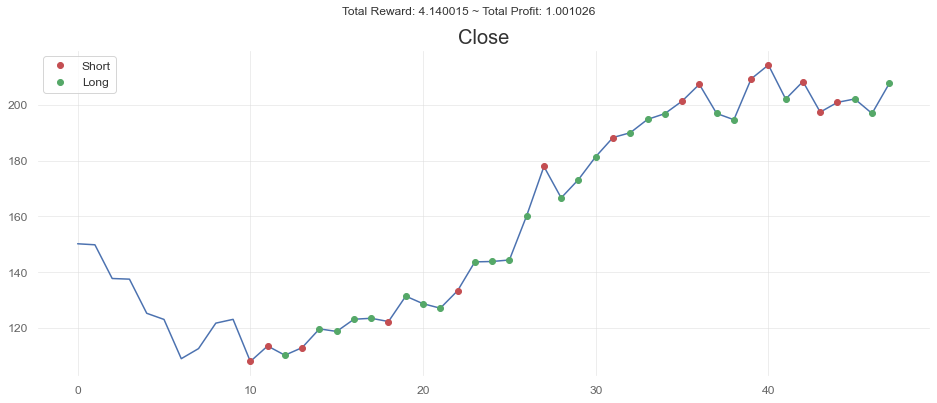

In [42]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


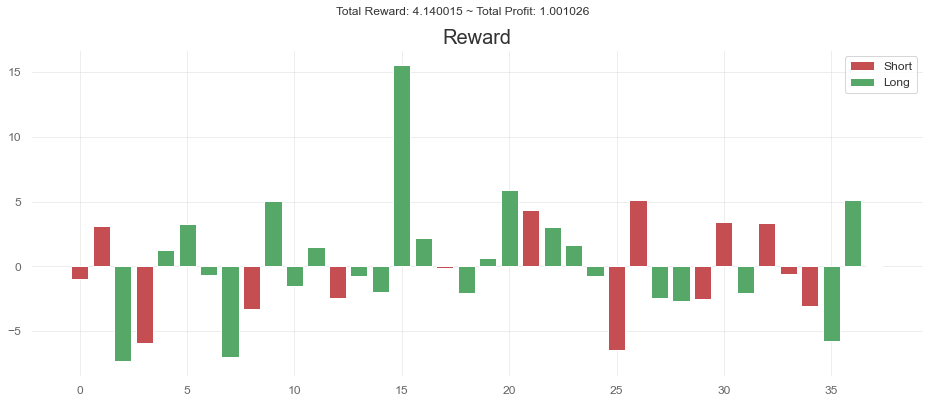

In [43]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


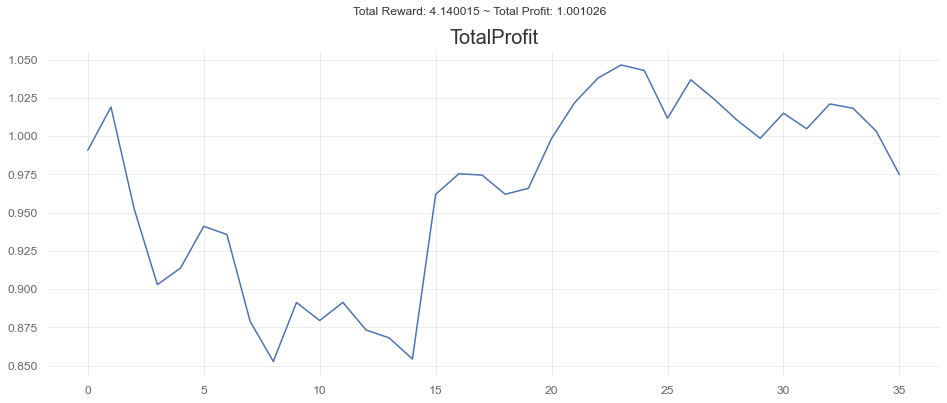

In [44]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [16]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)

目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數
注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]


第一個數字：大括號
第二個數字：有四個打橫
第三個數字：打橫入面有幾多個數字
(1, 4, 6)
[[[1 2 3 4 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]]] 

第一個數字：有幾多大組嘅數字
第二個數字：入面有幾多個小組
第三個數字：每個小組入面有幾多個數字
(4, 3, 2)
[[[1 2]
  [3 4]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]]
